In [184]:
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
import numpy as np
import networkx as nx

from networkx.algorithms.approximation import maximum_independent_set

import qcopt

matplotlib.rc('xtick', labelsize=13)     
matplotlib.rc('ytick', labelsize=13)
plt.rcParams["font.family"] = "Times New Roman"

In [155]:
onlinemis_N20 = 1.082142857142857
onlinemis_N60 = 1.1055965817596252
onlinemis_N100 = 1.0992965435797255

# Data Loading

In [2]:
def get_pickles(N, graph_type, npm, ns, verbose=0, quantum=True):
    if quantum:
        print(f'LOADING Quantum N{N}_{graph_type}_NS{ns}_NPM{npm}')
    else:
        print(f'LOADING Classical N{N}_{graph_type}_NS{ns}')
        
    retval = []
    
    if quantum:
        base_path = f'benchmark_results/QLS_N{N}_{graph_type}_graphs/'
        graph_dirs = glob.glob(base_path + f'NS{ns}_NPM{npm}/*')
    else:
        base_path = f'benchmark_results/CLS_N{N}_{graph_type}_graphs/'
        graph_dirs = glob.glob(base_path + f'NS{ns}/*')
    if verbose:
        print('base path:', base_path)
    
    
    graph_dirs = sorted(graph_dirs, key=lambda fn: int(fn.split('/')[-1].strip('G')))
    
    for gd in graph_dirs:
        if verbose:
            print(gd)
        all_reps = glob.glob(gd+'/*')
        
        graphfn = f'benchmark_graphs/N{N}_{graph_type}_graphs/{gd.split("/")[-1]}.txt'

        G = qcopt.graph_funcs.graph_from_file(graphfn)
        graph_name = f'N{N}_{graph_type}_{gd.split("/")[-1]}'
        
        temp_pickles = []
        for pklfile in all_reps:
            with open(pklfile, 'rb') as pf:
                res = pickle.load(pf)
                temp_pickles.append((pklfile.split('_')[-1].strip('.pickle'), res['out']))

        # after collecting reps for this graph, store the results
        retval.append((G, temp_pickles, graph_name))
            
    return retval

def get_BH_independence_ratio(N, graph_type):
    all_bh_results = glob.glob(f'benchmark_results/BoppanaHalldorsson/N{N}_{graph_type}_graphs/*txt')
    all_bh_mis = []
    for result_fn in all_bh_results:
        with open(result_fn, 'r') as fn:
            for line in fn:
                all_bh_mis.append(float(line.split()[-1]))
                break
    if len(all_bh_mis) == 0:
        raise Exception('empty list!')
    return np.mean(all_bh_mis) / N

def get_qaoaplus_independence_ratio(N, graph_type, P):
    all_qaoa_graphs = glob.glob(f'benchmark_results/QAOA+_P{P}_qasm/N{N}_{graph_type}_graphs/G*')
    all_qaoa_mis = []
    for graph_dir in all_qaoa_graphs:
        all_pickles = glob.glob(f'{graph_dir}/*.pickle')
        top_mis = 0
        for pickle_fn in all_pickles:
            with open(pickle_fn, 'rb') as pf:
                out = pickle.load(pf)
            top_output = out['top_output']
            if len(top_output) > 0:
                most_likely_soln = None
                for soln in top_output:
                    if soln[-1]:
                        most_likely_soln = soln[0]
                        break
                if most_likely_soln is not None and qcopt.helper_funcs.hamming_weight(most_likely_soln) > top_mis:
                    top_mis = qcopt.helper_funcs.hamming_weight(most_likely_soln)
        all_qaoa_mis.append(top_mis)
    if len(all_qaoa_mis) == 0:
        raise Exception('empty list!')
    return np.mean(all_qaoa_mis) / N

def get_random_independence_ratio(N, graph_type):
    all_rand_results = glob.glob(f'benchmark_results/randomized_mis/N{N}_{graph_type}_graphs/*.txt')
    all_rand_mis = []
    for result_fn in all_rand_results:
        with open(result_fn, 'r') as fn:
            for line in fn:
                all_rand_mis.append(float(line.split()[-1]))
                break
    if len(all_rand_mis) == 0:
        raise Exception('empty list!')
    return np.mean(all_rand_mis) / N

# Plotting individual graph results

In [15]:
def plot_qls_approxs(data, savedir=None, show=True, verbose=0):
    
    G, bh_mis, outs, graph_name = data
    if verbose:
        print(graph_name)
        print('\tBoppana-Halldorsson MIS =', bh_mis)
    
    fig, ax = plt.subplots(dpi=150)

    outs = sorted(outs, key=lambda tup: int(tup[0].strip('rep')))
    for r, (rep, out) in enumerate(outs):
        qls_mis, history = out
        
        if verbose > 0:
            print('\t{}: QLS MIS = {}, {} iterations'.format(rep, hamming_weight(qls_mis), len(history)))
        
        x_vals, y_vals = [], []
        for i, iteration in enumerate(history):
            x_vals.append(i+1)
            approximation_ratio = abs(hamming_weight(iteration[-1]) / bh_mis)
            y_vals.append(approximation_ratio)

        ax.plot(x_vals, y_vals, alpha=0.3, label=rep)
        ax.scatter(x_vals, y_vals, alpha=0.3, s=20)
        
    ax.axhline(y=1, ls='--', c='k', alpha=0.2)

    ax.set_title('QLS on {}'.format(graph_name))
    ax.set_ylabel('Boppana-Halldorsson Approximation Ratio')
    ax.set_xlabel('Iteration')
    ax.legend()
    
    if not savedir is None:
        if savedir[-1] != '/':
            savedir += '/'
        plt.savefig(savedir + graph_name + '.png')
        
    if show:
        plt.show()
    plt.close()
    
    #if len(iterations_to_opt) > 0:
    #    retval = np.mean(iterations_to_opt)
    #else:
    #    retval = None
    #return retval

In [39]:
data = get_pickles(20, 'd', 3, 5, verbose=1)

base path: benchmark_results/QLS_N20_d3_graphs/
benchmark_results/QLS_N20_d3_graphs/NPM_5/G1
benchmark_results/QLS_N20_d3_graphs/NPM_5/G2
benchmark_results/QLS_N20_d3_graphs/NPM_5/G3
benchmark_results/QLS_N20_d3_graphs/NPM_5/G4
benchmark_results/QLS_N20_d3_graphs/NPM_5/G5
benchmark_results/QLS_N20_d3_graphs/NPM_5/G6
benchmark_results/QLS_N20_d3_graphs/NPM_5/G7
benchmark_results/QLS_N20_d3_graphs/NPM_5/G8
benchmark_results/QLS_N20_d3_graphs/NPM_5/G9
benchmark_results/QLS_N20_d3_graphs/NPM_5/G10
benchmark_results/QLS_N20_d3_graphs/NPM_5/G11
benchmark_results/QLS_N20_d3_graphs/NPM_5/G12
benchmark_results/QLS_N20_d3_graphs/NPM_5/G13
benchmark_results/QLS_N20_d3_graphs/NPM_5/G14
benchmark_results/QLS_N20_d3_graphs/NPM_5/G15
benchmark_results/QLS_N20_d3_graphs/NPM_5/G16
benchmark_results/QLS_N20_d3_graphs/NPM_5/G17
benchmark_results/QLS_N20_d3_graphs/NPM_5/G18
benchmark_results/QLS_N20_d3_graphs/NPM_5/G19
benchmark_results/QLS_N20_d3_graphs/NPM_5/G20


20
N20_d3_G1
	Boppana-Halldorsson MIS = 8
	rep1: QLS MIS = 7, 4 iterations
	rep2: QLS MIS = 8, 4 iterations
	rep3: QLS MIS = 8, 4 iterations
	rep4: QLS MIS = 8, 4 iterations
	rep5: QLS MIS = 7, 4 iterations
	rep6: QLS MIS = 7, 3 iterations
	rep7: QLS MIS = 7, 3 iterations
	rep8: QLS MIS = 7, 4 iterations
	rep9: QLS MIS = 8, 4 iterations
	rep10: QLS MIS = 8, 4 iterations


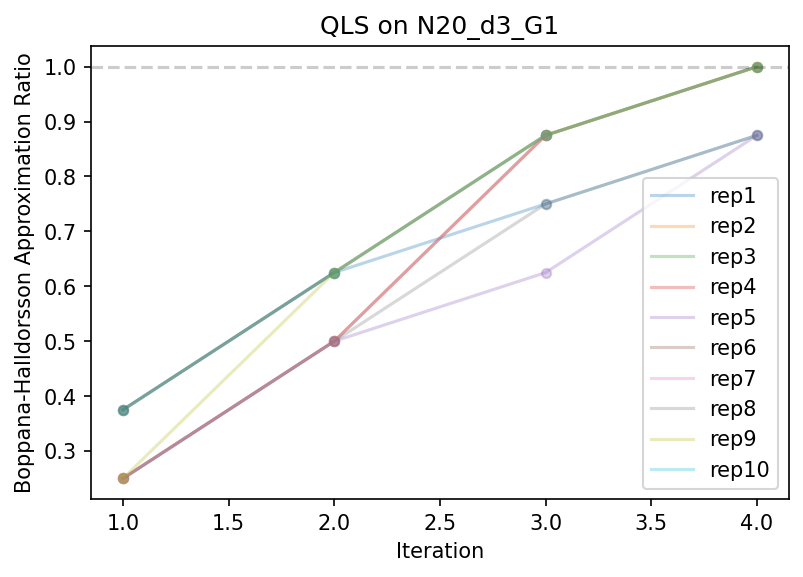

In [40]:
print(len(data))
plot_qls_approxs(data[0], verbose=1)

In [25]:
for N in [20, 60, 100]:
    data = get_pickles(N, 'd', 3, 5)
    savedir = 'figures/N{}_d3_QLS_iterations/'.format(N)
    for dat in data:
        plot_qls_approxs(dat, savedir=savedir, show=False, verbose=0)

base path: benchmark_results/QLS_N20_d3_graphs/
benchmark_results/QLS_N20_d3_graphs/NPM_5/G1
benchmark_results/QLS_N20_d3_graphs/NPM_5/G2
benchmark_results/QLS_N20_d3_graphs/NPM_5/G3
benchmark_results/QLS_N20_d3_graphs/NPM_5/G4
benchmark_results/QLS_N20_d3_graphs/NPM_5/G5
benchmark_results/QLS_N20_d3_graphs/NPM_5/G6
benchmark_results/QLS_N20_d3_graphs/NPM_5/G7
benchmark_results/QLS_N20_d3_graphs/NPM_5/G8
benchmark_results/QLS_N20_d3_graphs/NPM_5/G9
benchmark_results/QLS_N20_d3_graphs/NPM_5/G10
benchmark_results/QLS_N20_d3_graphs/NPM_5/G11
benchmark_results/QLS_N20_d3_graphs/NPM_5/G12
benchmark_results/QLS_N20_d3_graphs/NPM_5/G13
benchmark_results/QLS_N20_d3_graphs/NPM_5/G14
benchmark_results/QLS_N20_d3_graphs/NPM_5/G15
benchmark_results/QLS_N20_d3_graphs/NPM_5/G16
benchmark_results/QLS_N20_d3_graphs/NPM_5/G17
benchmark_results/QLS_N20_d3_graphs/NPM_5/G18
benchmark_results/QLS_N20_d3_graphs/NPM_5/G19
benchmark_results/QLS_N20_d3_graphs/NPM_5/G20
N20_d3_G1
	Boppana-Halldorsson MIS = 8
N2

# Plotting average performance over all graphs and all reps

In [316]:
def avg_all_graphs_all_reps(all_data, N, graph_type, verbose=0, extra_data=None, savefn=None):
    ns_fmt_dict = {2:'-o', 3:'--o', 4:':o'}
    plt_tab_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink']
    npm_color_dict = {key: color for key, color in zip(list(set([d[1] for d in all_data])), plt_tab_colors)}
    fig, ax = plt.subplots(dpi=150, figsize=[9,6])
    
    # For each set of data with NPM = k
    for (ns, npm, data) in all_data:
        quantum = True
        if npm == -1:
            quantum = False
        if verbose:
            if quantum:
                print(f'NS{ns} NPM{npm}, {len(data)} graphs')
            else:
                print(f'NS{ns}, {len(data)} graphs')
        all_graph_y_vals = []
        # For each graph within that data set
        for (G, outs, graph_name) in data:
            if verbose:
                print(f'{graph_name}, {len(outs)}')
            all_rep_y_vals = []
            # For each repetition on each graph
            for (rep, out) in outs:
                qls_mis, history = out
                temp_y_vals = []
                # For each iteration within every repetition
                for iteration in history:
                    # Compute independence ratio: |mis| / N
                    independence_ratio = abs(qcopt.helper_funcs.hamming_weight(iteration[-1]) / len(G.nodes))
                    temp_y_vals.append(independence_ratio)
                all_rep_y_vals.append((qcopt.helper_funcs.hamming_weight(qls_mis) / len(G.nodes), temp_y_vals))
            
            # Once all the reps have been collected, take the best repetition
            all_graph_y_vals.append(sorted(all_rep_y_vals, key=lambda tup: tup[0])[-1][1])
        
        # Once all the graphs have been collected, average over them
        max_iters = max([len(graph) for graph in all_graph_y_vals])
        #if npm == 4 and N == 60:
        #    max_iters -= 1
        #if npm == 3 and N == 100:
        #    max_iters -= 1
        avg_y_vals = []
        std_y_vals = []
        for i in range(max_iters):
            cur_iter_vals = []
            for graph in all_graph_y_vals:
                if i < len(graph):
                    cur_iter_vals.append(graph[i])
            avg_y_vals.append(np.mean(cur_iter_vals))
            std_y_vals.append(np.std(cur_iter_vals))
            
        # After all the data has been averaged, plot the results
        if quantum:
            label = f'QLS $N_s = {ns}$, $npm = {npm}$'
            fmt = ns_fmt_dict[ns]
            color = npm_color_dict[npm]
        else:
            label = f'CLS $N_s = {ns}$'
            fmt = ns_fmt_dict[ns]
            color = 'grey'
            
        xvals = np.arange(1, len(avg_y_vals)+1)
        ax.errorbar(xvals, avg_y_vals, label=label, fmt=fmt, c=color, ms=4)

        y1 = [m+s for m, s in zip(avg_y_vals, std_y_vals)]
        y2 = [m-s for m, s in zip(avg_y_vals, std_y_vals)]
        ax.fill_between(xvals, y1, y2, alpha=0.1, color=color)
    
    if extra_data is not None:
        for (label, val, color, ls) in extra_data:
            ax.axhline(y=val, ls=ls, alpha=1, label=label, color=color)
        
    ax.legend(fontsize=8, ncol=2)
    ax.set_ylabel('Independence Ratio', fontsize=13)
    ax.set_xlabel('Iteration', fontsize=13)
    ax.set_title(f'Average QLS performance ({N} node, {graph_type} graphs)')
    
    if savefn is not None:
        plt.savefig(savefn)
    
    plt.show()
    plt.close()

## N = 20

### 3-regular graphs

In [319]:
all_data = []
extra_data = []
N = 20
graph_type = 'd3'
for ns in [2,3,4]:
    for npm in [2, 4, 6, 8, 10]:
        all_data.append((ns, npm, get_pickles(N, graph_type, npm, ns)))
    all_data.append((ns, -1, get_pickles(N, graph_type, -1, ns, quantum=False)))

# Get Boppana-Halldorsson data
extra_data.append(('BH', get_BH_independence_ratio(N, graph_type), 'k', '--'))
# Get QAOA+ data
extra_data.append(('QAOA+ $p=1$', get_qaoaplus_independence_ratio(N, graph_type, 1), 'pink', ':'))
extra_data.append(('QAOA+ $p=4$', get_qaoaplus_independence_ratio(N, graph_type, 4), 'pink', ':'))
extra_data.append(('QAOA+ $p=8$', get_qaoaplus_independence_ratio(N, graph_type, 8), 'pink', ':'))
extra_data.append(('QAOA+ $p=12$', get_qaoaplus_independence_ratio(N, graph_type, 12), 'red', ':'))
# Get random data
extra_data.append(('Random', get_random_independence_ratio(N, graph_type), 'green', '--'))

LOADING Quantum N20_d3_NS2_NPM2
LOADING Quantum N20_d3_NS2_NPM4
LOADING Quantum N20_d3_NS2_NPM6
LOADING Quantum N20_d3_NS2_NPM8
LOADING Quantum N20_d3_NS2_NPM10
LOADING Classical N20_d3_NS2
LOADING Quantum N20_d3_NS3_NPM2
LOADING Quantum N20_d3_NS3_NPM4
LOADING Quantum N20_d3_NS3_NPM6
LOADING Quantum N20_d3_NS3_NPM8
LOADING Quantum N20_d3_NS3_NPM10
LOADING Classical N20_d3_NS3
LOADING Quantum N20_d3_NS4_NPM2
LOADING Quantum N20_d3_NS4_NPM4
LOADING Quantum N20_d3_NS4_NPM6
LOADING Quantum N20_d3_NS4_NPM8
LOADING Quantum N20_d3_NS4_NPM10
LOADING Classical N20_d3_NS4


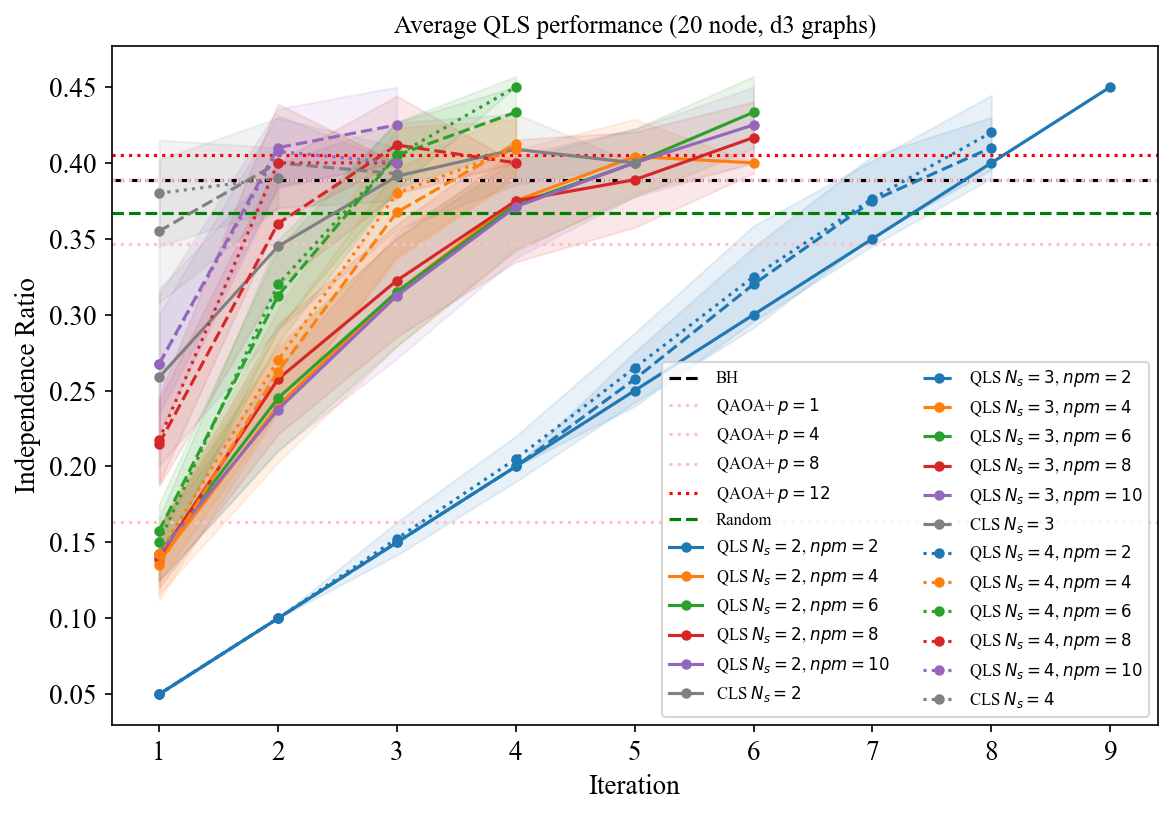

In [321]:
savefn = 'figures/qls_N20.pdf'
avg_all_graphs_all_reps(all_data, N, graph_type, extra_data=extra_data, savefn=None, verbose=0)

### Planted-partition graphs

In [326]:
all_data = []
extra_data = []
N = 20
graph_type = 'com1_pin10_pout2'
for ns in [2,3,4]:
    for npm in [2, 4, 6, 8, 10]:
        all_data.append((ns, npm, get_pickles(N, graph_type, npm, ns)))
    all_data.append((ns, -1, get_pickles(N, graph_type, -1, ns, quantum=False)))

# Get Boppana-Halldorsson data
extra_data.append(('BH', get_BH_independence_ratio(N, graph_type), 'k', '--'))
# Get QAOA+ data
extra_data.append(('QAOA+ $p=1$', get_qaoaplus_independence_ratio(N, graph_type, 1), 'green', ':'))
extra_data.append(('QAOA+ $p=4$', get_qaoaplus_independence_ratio(N, graph_type, 4), 'pink', ':'))
extra_data.append(('QAOA+ $p=8$', get_qaoaplus_independence_ratio(N, graph_type, 8), 'orange', ':'))
extra_data.append(('QAOA+ $p=12$', get_qaoaplus_independence_ratio(N, graph_type, 12), 'red', ':'))
# Get random data
extra_data.append(('Random', get_random_independence_ratio(N, graph_type), 'green', '--'))

LOADING Quantum N20_com1_pin10_pout2_NS2_NPM2
LOADING Quantum N20_com1_pin10_pout2_NS2_NPM4
LOADING Quantum N20_com1_pin10_pout2_NS2_NPM6
LOADING Quantum N20_com1_pin10_pout2_NS2_NPM8
LOADING Quantum N20_com1_pin10_pout2_NS2_NPM10
LOADING Classical N20_com1_pin10_pout2_NS2
LOADING Quantum N20_com1_pin10_pout2_NS3_NPM2
LOADING Quantum N20_com1_pin10_pout2_NS3_NPM4
LOADING Quantum N20_com1_pin10_pout2_NS3_NPM6
LOADING Quantum N20_com1_pin10_pout2_NS3_NPM8
LOADING Quantum N20_com1_pin10_pout2_NS3_NPM10
LOADING Classical N20_com1_pin10_pout2_NS3
LOADING Quantum N20_com1_pin10_pout2_NS4_NPM2
LOADING Quantum N20_com1_pin10_pout2_NS4_NPM4
LOADING Quantum N20_com1_pin10_pout2_NS4_NPM6
LOADING Quantum N20_com1_pin10_pout2_NS4_NPM8
LOADING Quantum N20_com1_pin10_pout2_NS4_NPM10
LOADING Classical N20_com1_pin10_pout2_NS4


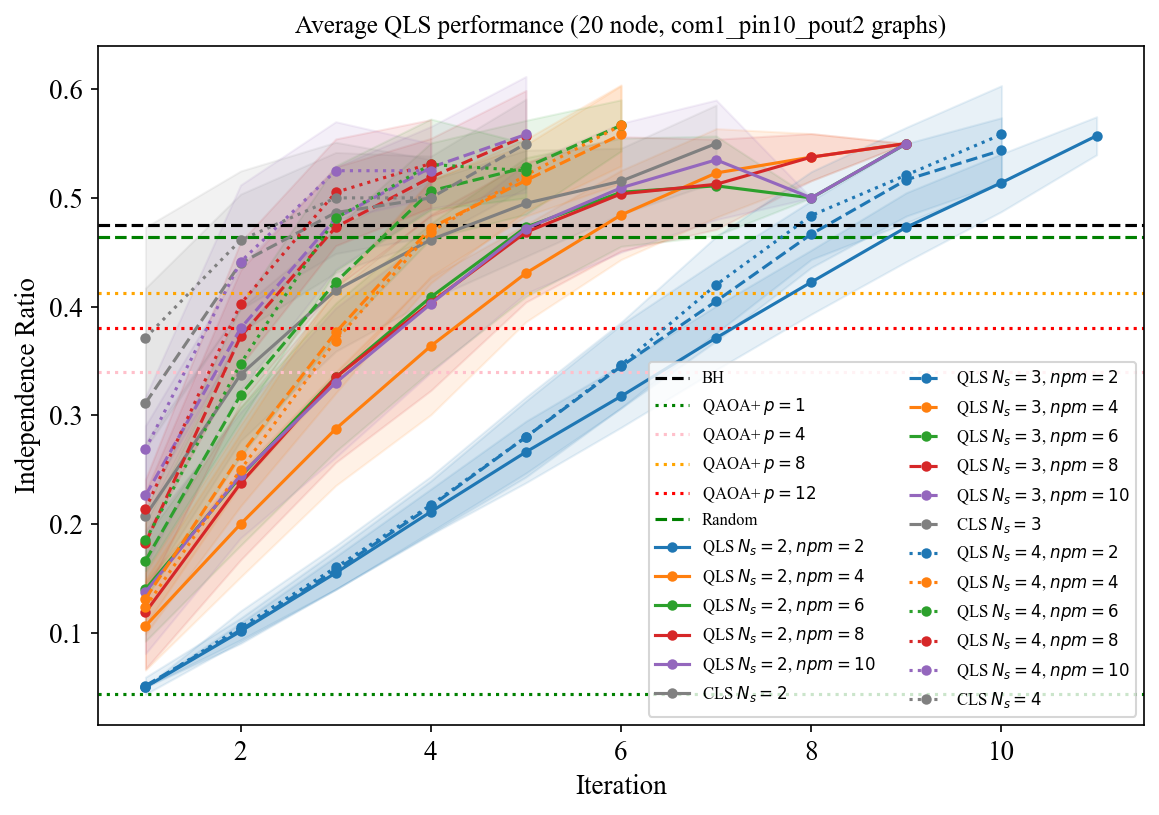

In [327]:
savefn = 'figures/qls_N20.pdf'
avg_all_graphs_all_reps(all_data, N, graph_type, extra_data=extra_data, savefn=None, verbose=0)

### Erdos-Renyi graphs

In [328]:
all_data = []
extra_data = []
N = 20
graph_type = 'er3'
for ns in [2,3,4]:
    for npm in [2, 4, 6, 8, 10]:
        all_data.append((ns, npm, get_pickles(N, graph_type, npm, ns)))
    all_data.append((ns, -1, get_pickles(N, graph_type, -1, ns, quantum=False)))

# Get Boppana-Halldorsson data
extra_data.append(('BH', get_BH_independence_ratio(N, graph_type), 'k', '--'))
# Get QAOA+ data
extra_data.append(('QAOA+ $p=1$', get_qaoaplus_independence_ratio(N, graph_type, 1), 'green', ':'))
extra_data.append(('QAOA+ $p=4$', get_qaoaplus_independence_ratio(N, graph_type, 4), 'pink', ':'))
extra_data.append(('QAOA+ $p=8$', get_qaoaplus_independence_ratio(N, graph_type, 8), 'orange', ':'))
extra_data.append(('QAOA+ $p=12$', get_qaoaplus_independence_ratio(N, graph_type, 12), 'red', ':'))
# Get random data
extra_data.append(('Random', get_random_independence_ratio(N, graph_type), 'green', '--'))

LOADING Quantum N20_er3_NS2_NPM2
LOADING Quantum N20_er3_NS2_NPM4
LOADING Quantum N20_er3_NS2_NPM6
LOADING Quantum N20_er3_NS2_NPM8
LOADING Quantum N20_er3_NS2_NPM10
LOADING Classical N20_er3_NS2
LOADING Quantum N20_er3_NS3_NPM2
LOADING Quantum N20_er3_NS3_NPM4
LOADING Quantum N20_er3_NS3_NPM6
LOADING Quantum N20_er3_NS3_NPM8
LOADING Quantum N20_er3_NS3_NPM10
LOADING Classical N20_er3_NS3
LOADING Quantum N20_er3_NS4_NPM2
LOADING Quantum N20_er3_NS4_NPM4
LOADING Quantum N20_er3_NS4_NPM6
LOADING Quantum N20_er3_NS4_NPM8
LOADING Quantum N20_er3_NS4_NPM10
LOADING Classical N20_er3_NS4


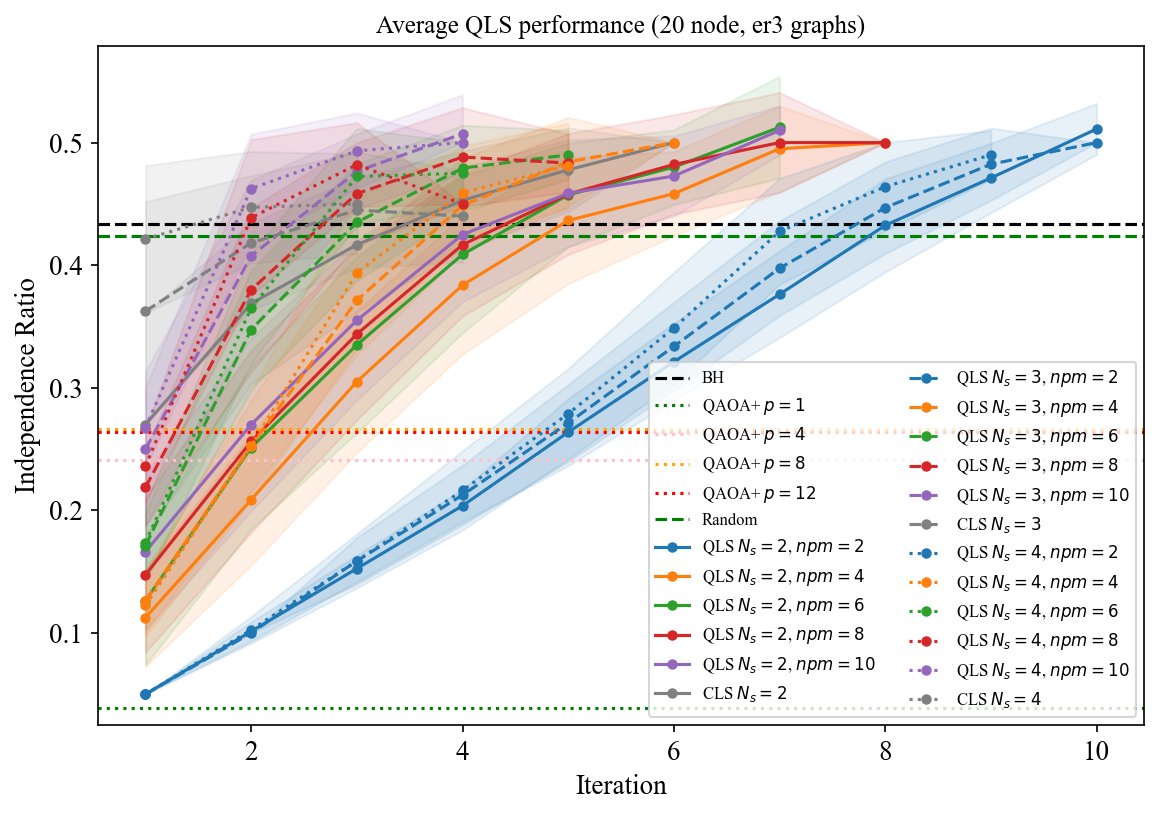

In [329]:
savefn = 'figures/qls_N20.pdf'
avg_all_graphs_all_reps(all_data, N, graph_type, extra_data=extra_data, savefn=None, verbose=0)

## N = 60

### 3-regular graphs

In [17]:
all_data = []
extra_data = []
N = 60
graph_type = 'd3'
for ns in [2,3,4]:
    for npm in [2, 4, 6, 8, 10]:
        all_data.append((ns, npm, get_pickles(N, graph_type, npm, ns)))
    all_data.append((ns, -1, get_pickles(N, graph_type, -1, ns, quantum=False)))

# Get Boppana-Halldorsson data
extra_data.append(('BH', get_BH_independence_ratio(N, graph_type), 'k', '--'))
# Get random data
extra_data.append(('Random', get_random_independence_ratio(N, graph_type), 'green', '--'))

LOADING Quantum N60_d3_NS2_NPM2
LOADING Quantum N60_d3_NS2_NPM4
LOADING Quantum N60_d3_NS2_NPM6
LOADING Quantum N60_d3_NS2_NPM8
LOADING Quantum N60_d3_NS2_NPM10
LOADING Classical N60_d3_NS2
LOADING Quantum N60_d3_NS3_NPM2
LOADING Quantum N60_d3_NS3_NPM4
LOADING Quantum N60_d3_NS3_NPM6
LOADING Quantum N60_d3_NS3_NPM8
LOADING Quantum N60_d3_NS3_NPM10
LOADING Classical N60_d3_NS3
LOADING Quantum N60_d3_NS4_NPM2
LOADING Quantum N60_d3_NS4_NPM4
LOADING Quantum N60_d3_NS4_NPM6
LOADING Quantum N60_d3_NS4_NPM8
LOADING Quantum N60_d3_NS4_NPM10
LOADING Classical N60_d3_NS4


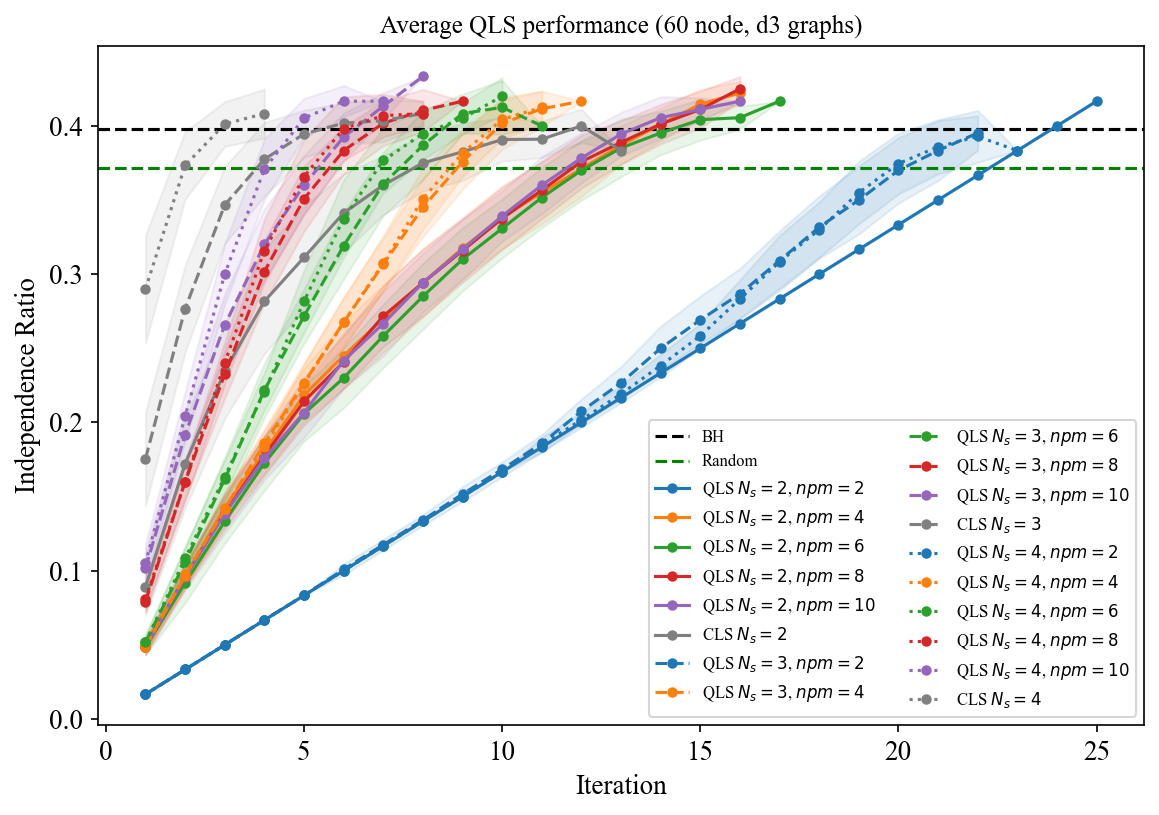

In [18]:
savefn = 'figures/qls_N60.pdf'
avg_all_graphs_all_reps(all_data, N, graph_type, extra_data=extra_data, savefn=None, verbose=0)

### Planted-partition graphs

In [19]:
all_data = []
extra_data = []
N = 60
graph_type = 'com3_pin10_pout2'
for ns in [2,3,4]:
    for npm in [2, 4, 6, 8]:
        all_data.append((ns, npm, get_pickles(N, graph_type, npm, ns)))
    all_data.append((ns, -1, get_pickles(N, graph_type, -1, ns, quantum=False)))

# Get Boppana-Halldorsson data
extra_data.append(('BH', get_BH_independence_ratio(N, graph_type), 'k', '--'))
# Get random data
extra_data.append(('Random', get_random_independence_ratio(N, graph_type), 'green', '--'))

LOADING Quantum N60_com3_pin10_pout2_NS2_NPM2
LOADING Quantum N60_com3_pin10_pout2_NS2_NPM4
LOADING Quantum N60_com3_pin10_pout2_NS2_NPM6
LOADING Quantum N60_com3_pin10_pout2_NS2_NPM8
LOADING Classical N60_com3_pin10_pout2_NS2
LOADING Quantum N60_com3_pin10_pout2_NS3_NPM2
LOADING Quantum N60_com3_pin10_pout2_NS3_NPM4
LOADING Quantum N60_com3_pin10_pout2_NS3_NPM6
LOADING Quantum N60_com3_pin10_pout2_NS3_NPM8
LOADING Classical N60_com3_pin10_pout2_NS3
LOADING Quantum N60_com3_pin10_pout2_NS4_NPM2
LOADING Quantum N60_com3_pin10_pout2_NS4_NPM4
LOADING Quantum N60_com3_pin10_pout2_NS4_NPM6
LOADING Quantum N60_com3_pin10_pout2_NS4_NPM8
LOADING Classical N60_com3_pin10_pout2_NS4


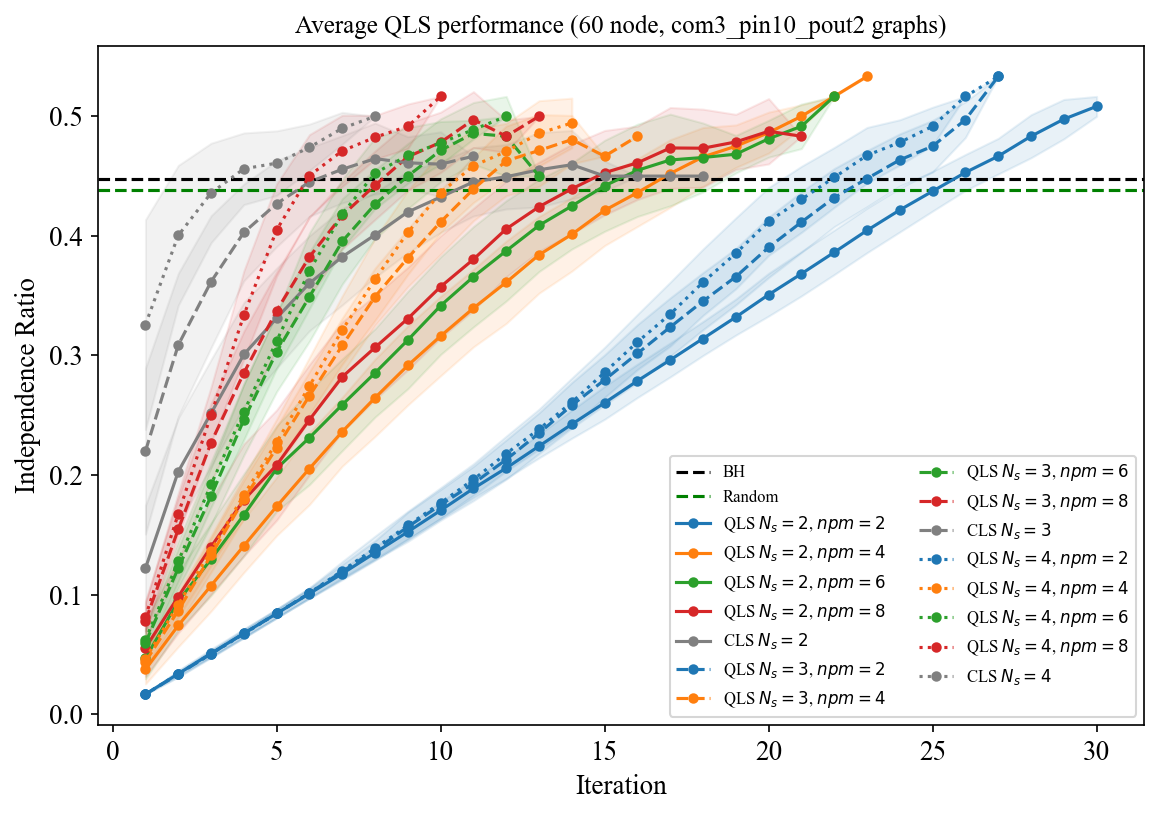

In [20]:
savefn = 'figures/qls_N20.pdf'
avg_all_graphs_all_reps(all_data, N, graph_type, extra_data=extra_data, savefn=None, verbose=0)

### Erdos-Renyi graphs

In [21]:
all_data = []
extra_data = []
N = 60
graph_type = 'er3'
for ns in [2,3,4]:
    for npm in [2, 4, 6, 8]:
        all_data.append((ns, npm, get_pickles(N, graph_type, npm, ns)))
    all_data.append((ns, -1, get_pickles(N, graph_type, -1, ns, quantum=False)))

# Get Boppana-Halldorsson data
extra_data.append(('BH', get_BH_independence_ratio(N, graph_type), 'k', '--'))
# Get random data
extra_data.append(('Random', get_random_independence_ratio(N, graph_type), 'green', '--'))

LOADING Quantum N60_er3_NS2_NPM2
LOADING Quantum N60_er3_NS2_NPM4
LOADING Quantum N60_er3_NS2_NPM6
LOADING Quantum N60_er3_NS2_NPM8
LOADING Classical N60_er3_NS2
LOADING Quantum N60_er3_NS3_NPM2
LOADING Quantum N60_er3_NS3_NPM4
LOADING Quantum N60_er3_NS3_NPM6
LOADING Quantum N60_er3_NS3_NPM8
LOADING Classical N60_er3_NS3
LOADING Quantum N60_er3_NS4_NPM2
LOADING Quantum N60_er3_NS4_NPM4
LOADING Quantum N60_er3_NS4_NPM6
LOADING Quantum N60_er3_NS4_NPM8
LOADING Classical N60_er3_NS4


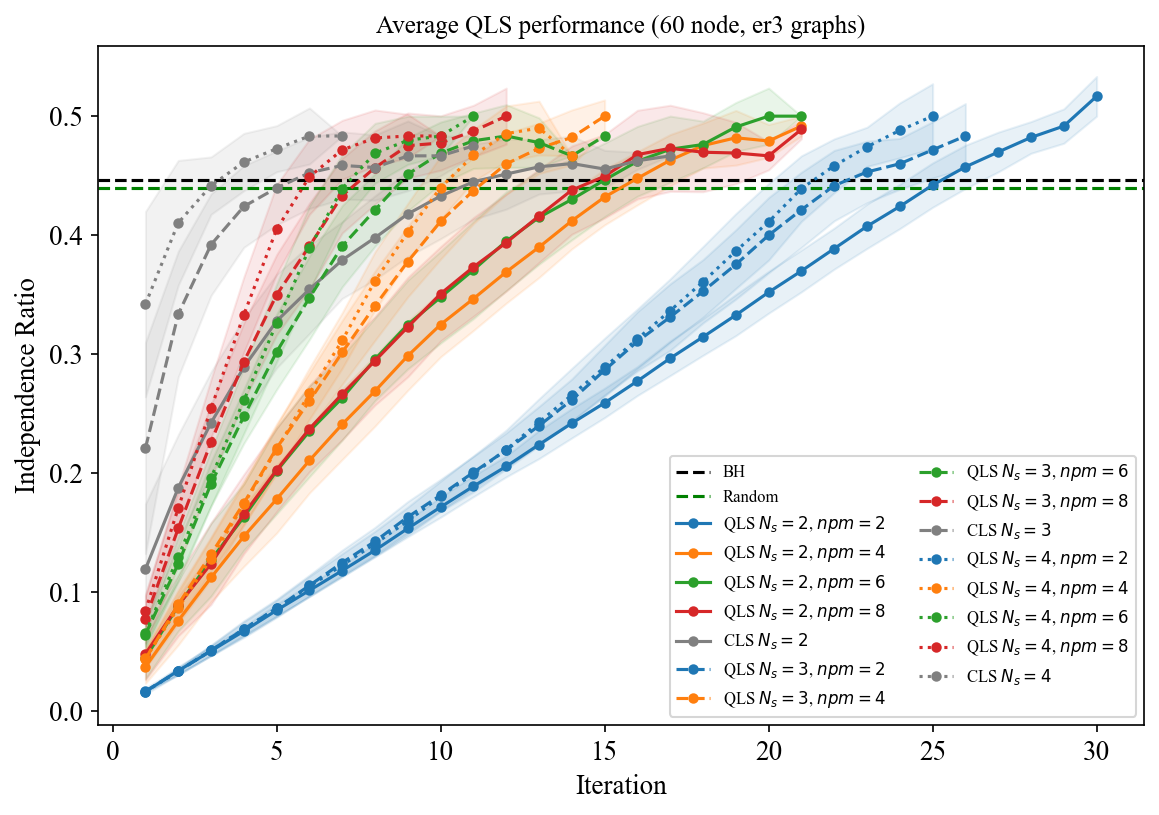

In [22]:
savefn = 'figures/qls_N20.pdf'
avg_all_graphs_all_reps(all_data, N, graph_type, extra_data=extra_data, savefn=None, verbose=0)

## N = 100

### 3-regular graphs

In [23]:
all_data = []
extra_data = []
N = 100
graph_type = 'd3'
for ns in [2,3,4]:
    for npm in [2, 4, 6, 8, 10]:
        all_data.append((ns, npm, get_pickles(N, graph_type, npm, ns)))
    all_data.append((ns, -1, get_pickles(N, graph_type, -1, ns, quantum=False)))

# Get Boppana-Halldorsson data
extra_data.append(('BH', get_BH_independence_ratio(N, graph_type), 'k', '--'))
# Get random data
extra_data.append(('Random', get_random_independence_ratio(N, graph_type), 'green', '--'))

LOADING Quantum N100_d3_NS2_NPM2
LOADING Quantum N100_d3_NS2_NPM4
LOADING Quantum N100_d3_NS2_NPM6
LOADING Quantum N100_d3_NS2_NPM8
LOADING Quantum N100_d3_NS2_NPM10
LOADING Classical N100_d3_NS2
LOADING Quantum N100_d3_NS3_NPM2
LOADING Quantum N100_d3_NS3_NPM4
LOADING Quantum N100_d3_NS3_NPM6
LOADING Quantum N100_d3_NS3_NPM8
LOADING Quantum N100_d3_NS3_NPM10
LOADING Classical N100_d3_NS3
LOADING Quantum N100_d3_NS4_NPM2
LOADING Quantum N100_d3_NS4_NPM4
LOADING Quantum N100_d3_NS4_NPM6
LOADING Quantum N100_d3_NS4_NPM8
LOADING Quantum N100_d3_NS4_NPM10
LOADING Classical N100_d3_NS4


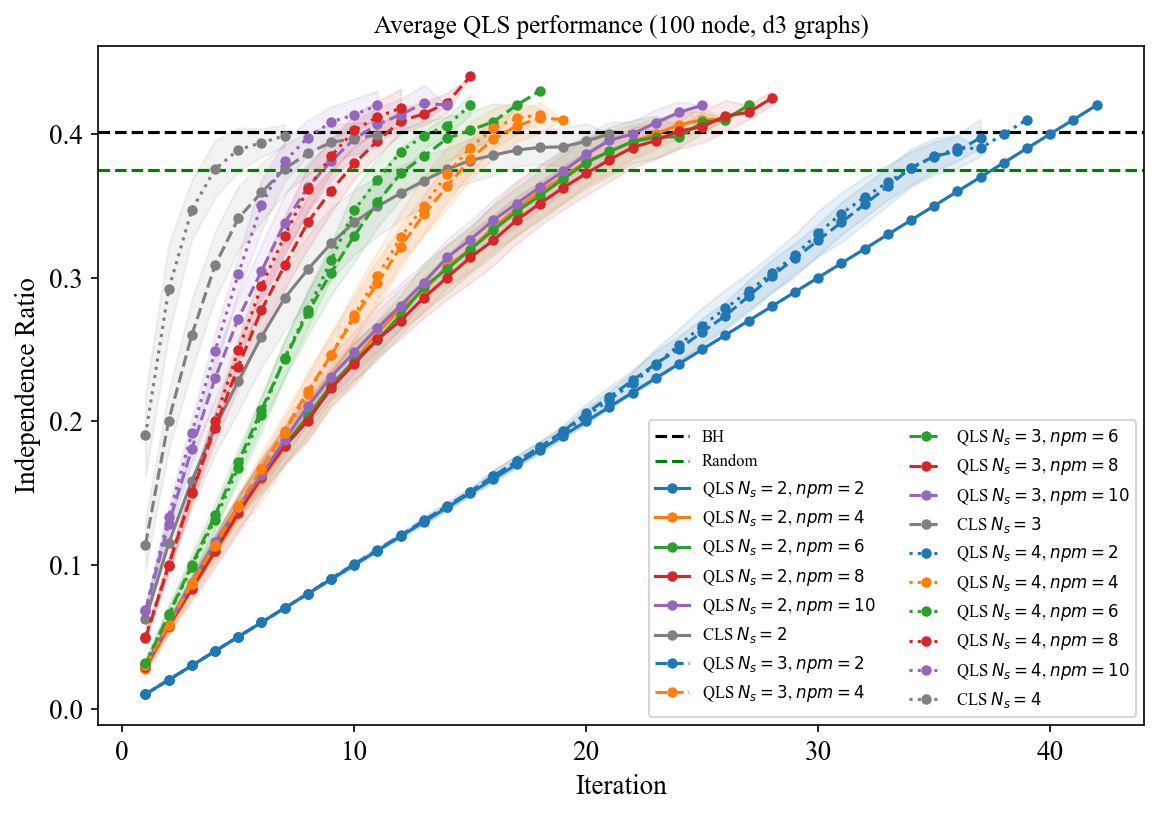

In [24]:
savefn = 'figures/qls_N100.pdf'
avg_all_graphs_all_reps(all_data, N, graph_type, extra_data=extra_data, savefn=None, verbose=0)

### Planted-partition graphs

In [25]:
all_data = []
extra_data = []
N = 100
graph_type = 'com5_pin10_pout2'
for ns in [2,3,4]:
    for npm in [2, 3, 4, 5, 6]:
        all_data.append((ns, npm, get_pickles(N, graph_type, npm, ns)))
    all_data.append((ns, -1, get_pickles(N, graph_type, -1, ns, quantum=False)))

# Get Boppana-Halldorsson data
extra_data.append(('BH', get_BH_independence_ratio(N, graph_type), 'k', '--'))
# Get random data
extra_data.append(('Random', get_random_independence_ratio(N, graph_type), 'green', '--'))

LOADING Quantum N100_com5_pin10_pout2_NS2_NPM2
LOADING Quantum N100_com5_pin10_pout2_NS2_NPM3
LOADING Quantum N100_com5_pin10_pout2_NS2_NPM4
LOADING Quantum N100_com5_pin10_pout2_NS2_NPM5
LOADING Quantum N100_com5_pin10_pout2_NS2_NPM6
LOADING Classical N100_com5_pin10_pout2_NS2
LOADING Quantum N100_com5_pin10_pout2_NS3_NPM2
LOADING Quantum N100_com5_pin10_pout2_NS3_NPM3
LOADING Quantum N100_com5_pin10_pout2_NS3_NPM4
LOADING Quantum N100_com5_pin10_pout2_NS3_NPM5
LOADING Quantum N100_com5_pin10_pout2_NS3_NPM6
LOADING Classical N100_com5_pin10_pout2_NS3
LOADING Quantum N100_com5_pin10_pout2_NS4_NPM2
LOADING Quantum N100_com5_pin10_pout2_NS4_NPM3
LOADING Quantum N100_com5_pin10_pout2_NS4_NPM4
LOADING Quantum N100_com5_pin10_pout2_NS4_NPM5
LOADING Quantum N100_com5_pin10_pout2_NS4_NPM6
LOADING Classical N100_com5_pin10_pout2_NS4


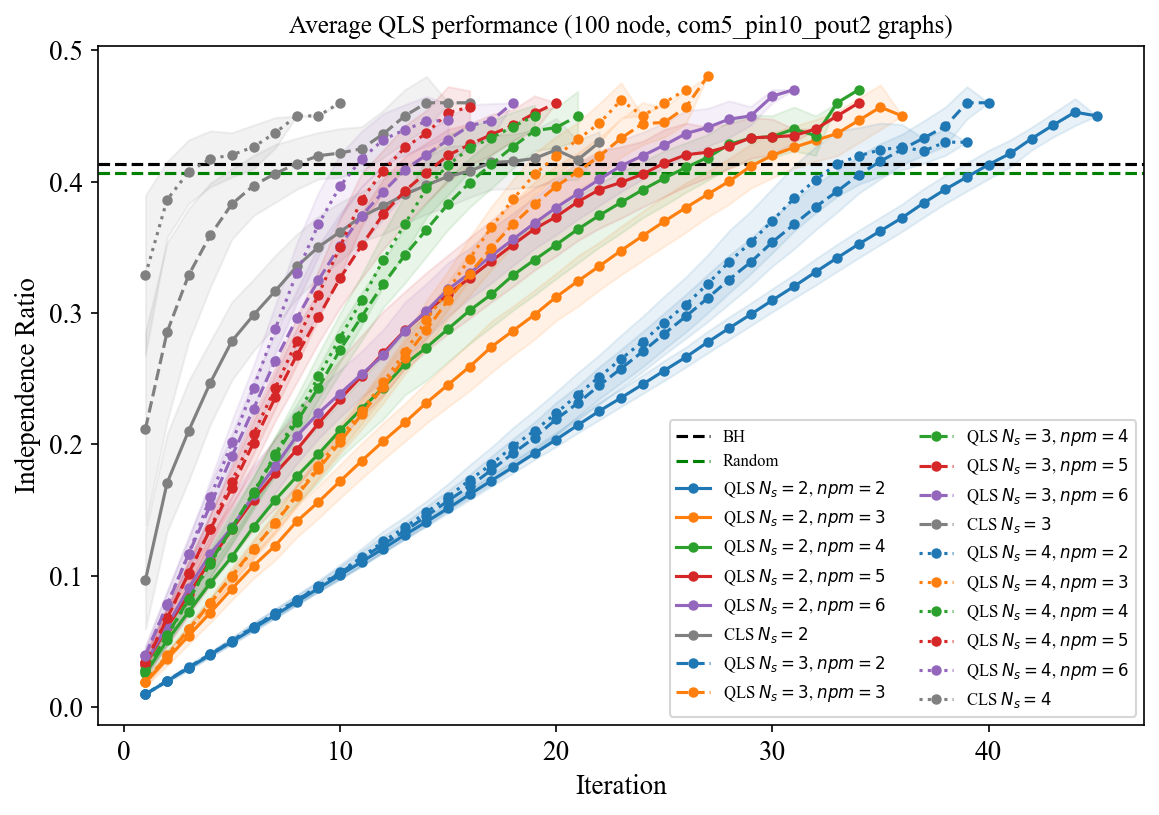

In [26]:
savefn = 'figures/qls_N20.pdf'
avg_all_graphs_all_reps(all_data, N, graph_type, extra_data=extra_data, savefn=None, verbose=0)

### Erdos-Renyi graphs

In [27]:
all_data = []
extra_data = []
N = 100
graph_type = 'er3'
for ns in [2,3,4]:
    for npm in [2, 3, 4, 5, 6]:
        all_data.append((ns, npm, get_pickles(N, graph_type, npm, ns)))
    all_data.append((ns, -1, get_pickles(N, graph_type, -1, ns, quantum=False)))

# Get Boppana-Halldorsson data
extra_data.append(('BH', get_BH_independence_ratio(N, graph_type), 'k', '--'))
# Get random data
extra_data.append(('Random', get_random_independence_ratio(N, graph_type), 'green', '--'))

LOADING Quantum N100_er3_NS2_NPM2
LOADING Quantum N100_er3_NS2_NPM3
LOADING Quantum N100_er3_NS2_NPM4
LOADING Quantum N100_er3_NS2_NPM5
LOADING Quantum N100_er3_NS2_NPM6
LOADING Classical N100_er3_NS2
LOADING Quantum N100_er3_NS3_NPM2
LOADING Quantum N100_er3_NS3_NPM3
LOADING Quantum N100_er3_NS3_NPM4
LOADING Quantum N100_er3_NS3_NPM5
LOADING Quantum N100_er3_NS3_NPM6
LOADING Classical N100_er3_NS3
LOADING Quantum N100_er3_NS4_NPM2
LOADING Quantum N100_er3_NS4_NPM3
LOADING Quantum N100_er3_NS4_NPM4
LOADING Quantum N100_er3_NS4_NPM5
LOADING Quantum N100_er3_NS4_NPM6
LOADING Classical N100_er3_NS4


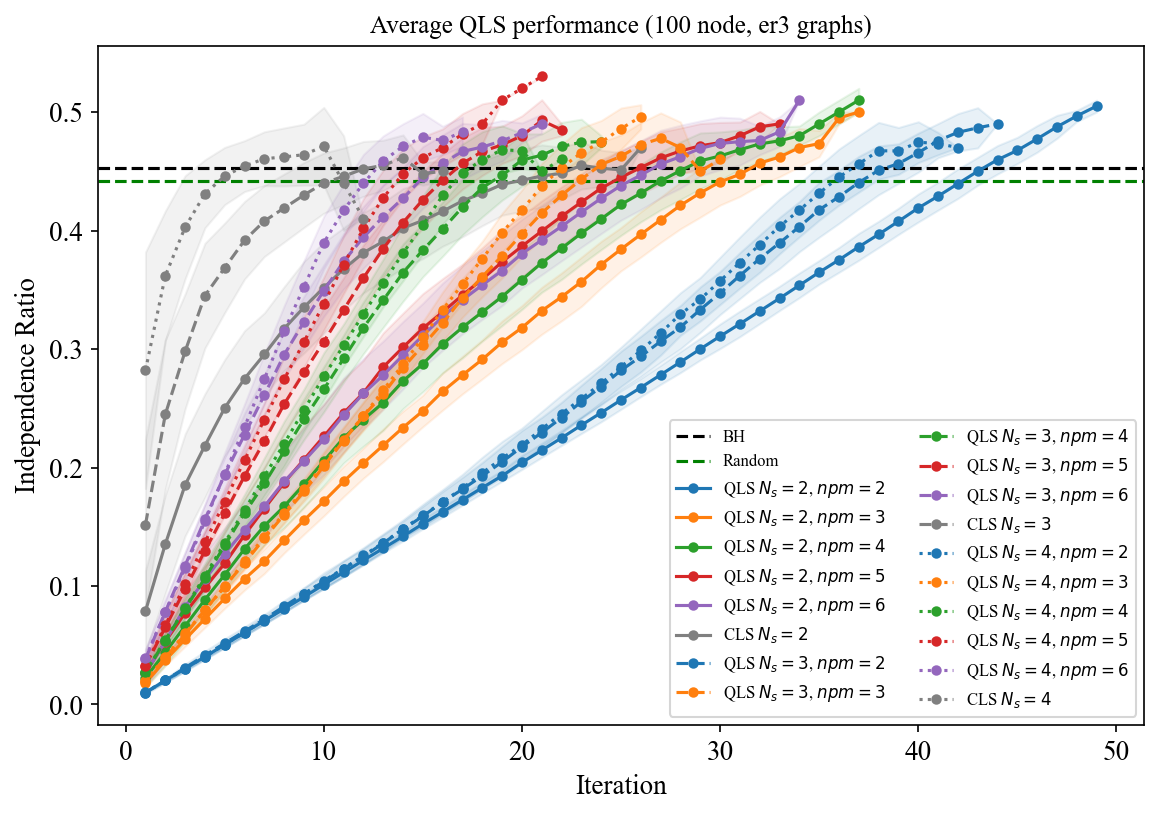

In [28]:
savefn = 'figures/qls_N20.pdf'
avg_all_graphs_all_reps(all_data, N, graph_type, extra_data=extra_data, savefn=None, verbose=0)

## Plot everything in a single figure

In [80]:
def one_plot_all_data(all_data, verbose=0, savefn=None):
    ms_fmt_dict = {2:'o', 3:'x', 4:'v'}
    plt_tab_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'grey']
    npm_color_dict = {key: color for key, color in zip([2,3,4,5,6,8,10, -1], plt_tab_colors)}
    fig, ax = plt.subplots(dpi=200, ncols=3, nrows=3, sharey=True, sharex='row', figsize=[14,9])
    
    for row in range(3):
        for col in range(3):
            cur_ax = ax[row][col]
            N, graph_type, data_dict = all_data[row][col]

            # For each set of local search data with (N_s, npm)
            for (ns, npm, data) in data_dict['local_search']:
                quantum = True
                if npm == -1:
                    quantum = False
                if verbose:
                    if quantum:
                        print(f'NS{ns} NPM{npm}, {len(data)} graphs')
                    else:
                        print(f'NS{ns}, {len(data)} graphs')
                all_graph_y_vals = []
                # For each graph within that data set
                for (G, outs, graph_name) in data:
                    if verbose:
                        print(f'{graph_name}, {len(outs)}')
                    all_rep_y_vals = []
                    # For each repetition on each graph
                    for (rep, out) in outs:
                        qls_mis, history = out
                        temp_y_vals = []
                        # For each iteration within every repetition
                        for iteration in history:
                            # Compute independence ratio: |mis| / N
                            independence_ratio = abs(qcopt.helper_funcs.hamming_weight(iteration[-1]) / len(G.nodes))
                            temp_y_vals.append(independence_ratio)
                        all_rep_y_vals.append((qcopt.helper_funcs.hamming_weight(qls_mis) / len(G.nodes), temp_y_vals))

                    # Once all the reps have been collected, take the best repetition
                    all_graph_y_vals.append(sorted(all_rep_y_vals, key=lambda tup: tup[0])[-1][1])

                # Once all the graphs have been collected, average over them
                max_iters = max([len(graph) for graph in all_graph_y_vals])
                avg_y_vals = []
                std_y_vals = []
                for i in range(max_iters):
                    cur_iter_vals = []
                    for graph in all_graph_y_vals:
                        if i < len(graph):
                            cur_iter_vals.append(graph[i])
                    avg_y_vals.append(np.mean(cur_iter_vals))
                    std_y_vals.append(np.std(cur_iter_vals))

                # After all the data has been averaged, plot the results
                if quantum:
                    label = f'QLS $N_s = {ns}$, $npm = {npm}$'
                else:
                    label = f'CLS $N_s = {ns}$'

                xvals = np.arange(1, len(avg_y_vals)+1)
                cur_ax.errorbar(xvals, avg_y_vals, label=label, c=npm_color_dict[npm], marker=ms_fmt_dict[ns],
                                markersize=4)

                y1 = [m+s for m, s in zip(avg_y_vals, std_y_vals)]
                y2 = [m-s for m, s in zip(avg_y_vals, std_y_vals)]
                cur_ax.fill_between(xvals, y1, y2, alpha=0.1, color=npm_color_dict[npm])

            # Plot other algorithms (BH, QAOA+, Random) that do not have iterations
            for (label, val, color, ls) in data_dict['extra_data']:
                cur_ax.axhline(y=val, ls=ls, alpha=1, label=label, color=color)
            
            title = {'d3':'3-regular', 'er3':r"Erdos-Renyi",
                     'com1_pin10_pout2':'(1,20) Community',
                     'com3_pin10_pout2':'(3,20) Community',
                     'com5_pin10_pout2':'(5,20) Community',}
            cur_ax.set_title(f'{N} node, {title[graph_type]} graphs')
    
    ax[1,0].legend(fontsize=8, ncol=2)
    ax[0,0].set_ylabel('Independence Ratio', fontsize=13)
    ax[2,0].set_xlabel('Iteration', fontsize=13)
    
    plt.tight_layout()
    
    if savefn is not None:
        plt.savefig(savefn)
    
    plt.show()
    plt.close()

In [33]:
# all_data will contain the data for plotting results in a 3x3 grid
# the data is stored as lists of lists: = [[3reg20(N, graph_type, data_dict), pp20,  er20],
#                                          [3reg60,                           pp60,  er60],
#                                          [3reg100,                          pp100, er100]]
# data_dict = {'local_search':[(ns, npm data), ...], 'extra_data':[(), ...]}
included_data = {
    '20d3': [(2,2), (2,4), (2,6), (2,8), (2,10), (4,2), (4,4), (4,6), (4,8), (4,10), (2,-1), (4,-1)],
    '20com1_pin10_pout2': [(2,2), (2,4), (2,6), (2,8), (2,10), (4,2), (4,4), (4,6), (4,8), (4,10), (2,-1), (4,-1)],
    '20er3': [(2,2), (2,4), (2,6), (2,8), (2,10), (4,2), (4,4), (4,6), (4,8), (4,10), (2,-1), (4,-1)],

    '60d3': [(2,2), (2,4), (2,6), (2,8), (4,2), (4,4), (4,6), (4,8), (2,-1), (4,-1)],
    '60com3_pin10_pout2': [(2,2), (2,4), (2,6), (2,8), (4,2), (4,4), (4,6), (4,8), (2,-1), (4,-1)],
    '60er3': [(2,2), (2,4), (2,6), (2,8), (4,2), (4,4), (4,6), (4,8), (2,-1), (4,-1)],

    '100d3': [(2,2), (2,4), (2,6), (4,2), (4,4), (4,6), (2,-1), (4,-1)],
    '100com5_pin10_pout2': [(2,2), (2,4), (2,6), (4,2), (4,4), (4,6), (2,-1), (4,-1)],
    '100er3': [(2,2), (2,4), (2,6), (4,2), (4,4), (4,6), (2,-1), (4,-1)],
}
all_data = []
for N in [20, 60, 100]:
    N_row = []
    for graph_type in ['d3', f'com{int(N/20)}_pin10_pout2', 'er3']:
        data_dict = {'local_search': [], 'extra_data': []}
        # load local search data (QLS and CLS)
        for ns, npm in included_data[f'{N}{graph_type}']:
            if npm == -1:
                quantum=False
            else:
                quantum=True
            data_dict['local_search'].append((ns, npm, get_pickles(N, graph_type, npm, ns, quantum=quantum)))
        # load extra data
        # Get Boppana-Halldorsson data
        data_dict['extra_data'].append(('BH', get_BH_independence_ratio(N, graph_type), 'k', '--'))
        # Get QAOA+ data
        if N == 20:
            data_dict['extra_data'].append(('QAOA+ $p=1$', get_qaoaplus_independence_ratio(N, graph_type, 1), 'pink', ':'))
            data_dict['extra_data'].append(('QAOA+ $p=4$', get_qaoaplus_independence_ratio(N, graph_type, 4), 'pink', ':'))
            data_dict['extra_data'].append(('QAOA+ $p=8$', get_qaoaplus_independence_ratio(N, graph_type, 8), 'pink', ':'))
        # Get random data
        data_dict['extra_data'].append(('Random', get_random_independence_ratio(N, graph_type), 'green', '--'))
        
        # Add ax[row][col] data to the row
        N_row.append((N, graph_type, data_dict))
    # Add the row to the list
    all_data.append(N_row)

LOADING Quantum N20_d3_NS2_NPM2
LOADING Quantum N20_d3_NS2_NPM4
LOADING Quantum N20_d3_NS2_NPM6
LOADING Quantum N20_d3_NS2_NPM8
LOADING Quantum N20_d3_NS2_NPM10
LOADING Quantum N20_d3_NS4_NPM2
LOADING Quantum N20_d3_NS4_NPM4
LOADING Quantum N20_d3_NS4_NPM6
LOADING Quantum N20_d3_NS4_NPM8
LOADING Quantum N20_d3_NS4_NPM10
LOADING Classical N20_d3_NS2
LOADING Classical N20_d3_NS4
LOADING Quantum N20_com1_pin10_pout2_NS2_NPM2
LOADING Quantum N20_com1_pin10_pout2_NS2_NPM4
LOADING Quantum N20_com1_pin10_pout2_NS2_NPM6
LOADING Quantum N20_com1_pin10_pout2_NS2_NPM8
LOADING Quantum N20_com1_pin10_pout2_NS2_NPM10
LOADING Quantum N20_com1_pin10_pout2_NS4_NPM2
LOADING Quantum N20_com1_pin10_pout2_NS4_NPM4
LOADING Quantum N20_com1_pin10_pout2_NS4_NPM6
LOADING Quantum N20_com1_pin10_pout2_NS4_NPM8
LOADING Quantum N20_com1_pin10_pout2_NS4_NPM10
LOADING Classical N20_com1_pin10_pout2_NS2
LOADING Classical N20_com1_pin10_pout2_NS4
LOADING Quantum N20_er3_NS2_NPM2
LOADING Quantum N20_er3_NS2_NPM4
LOADIN

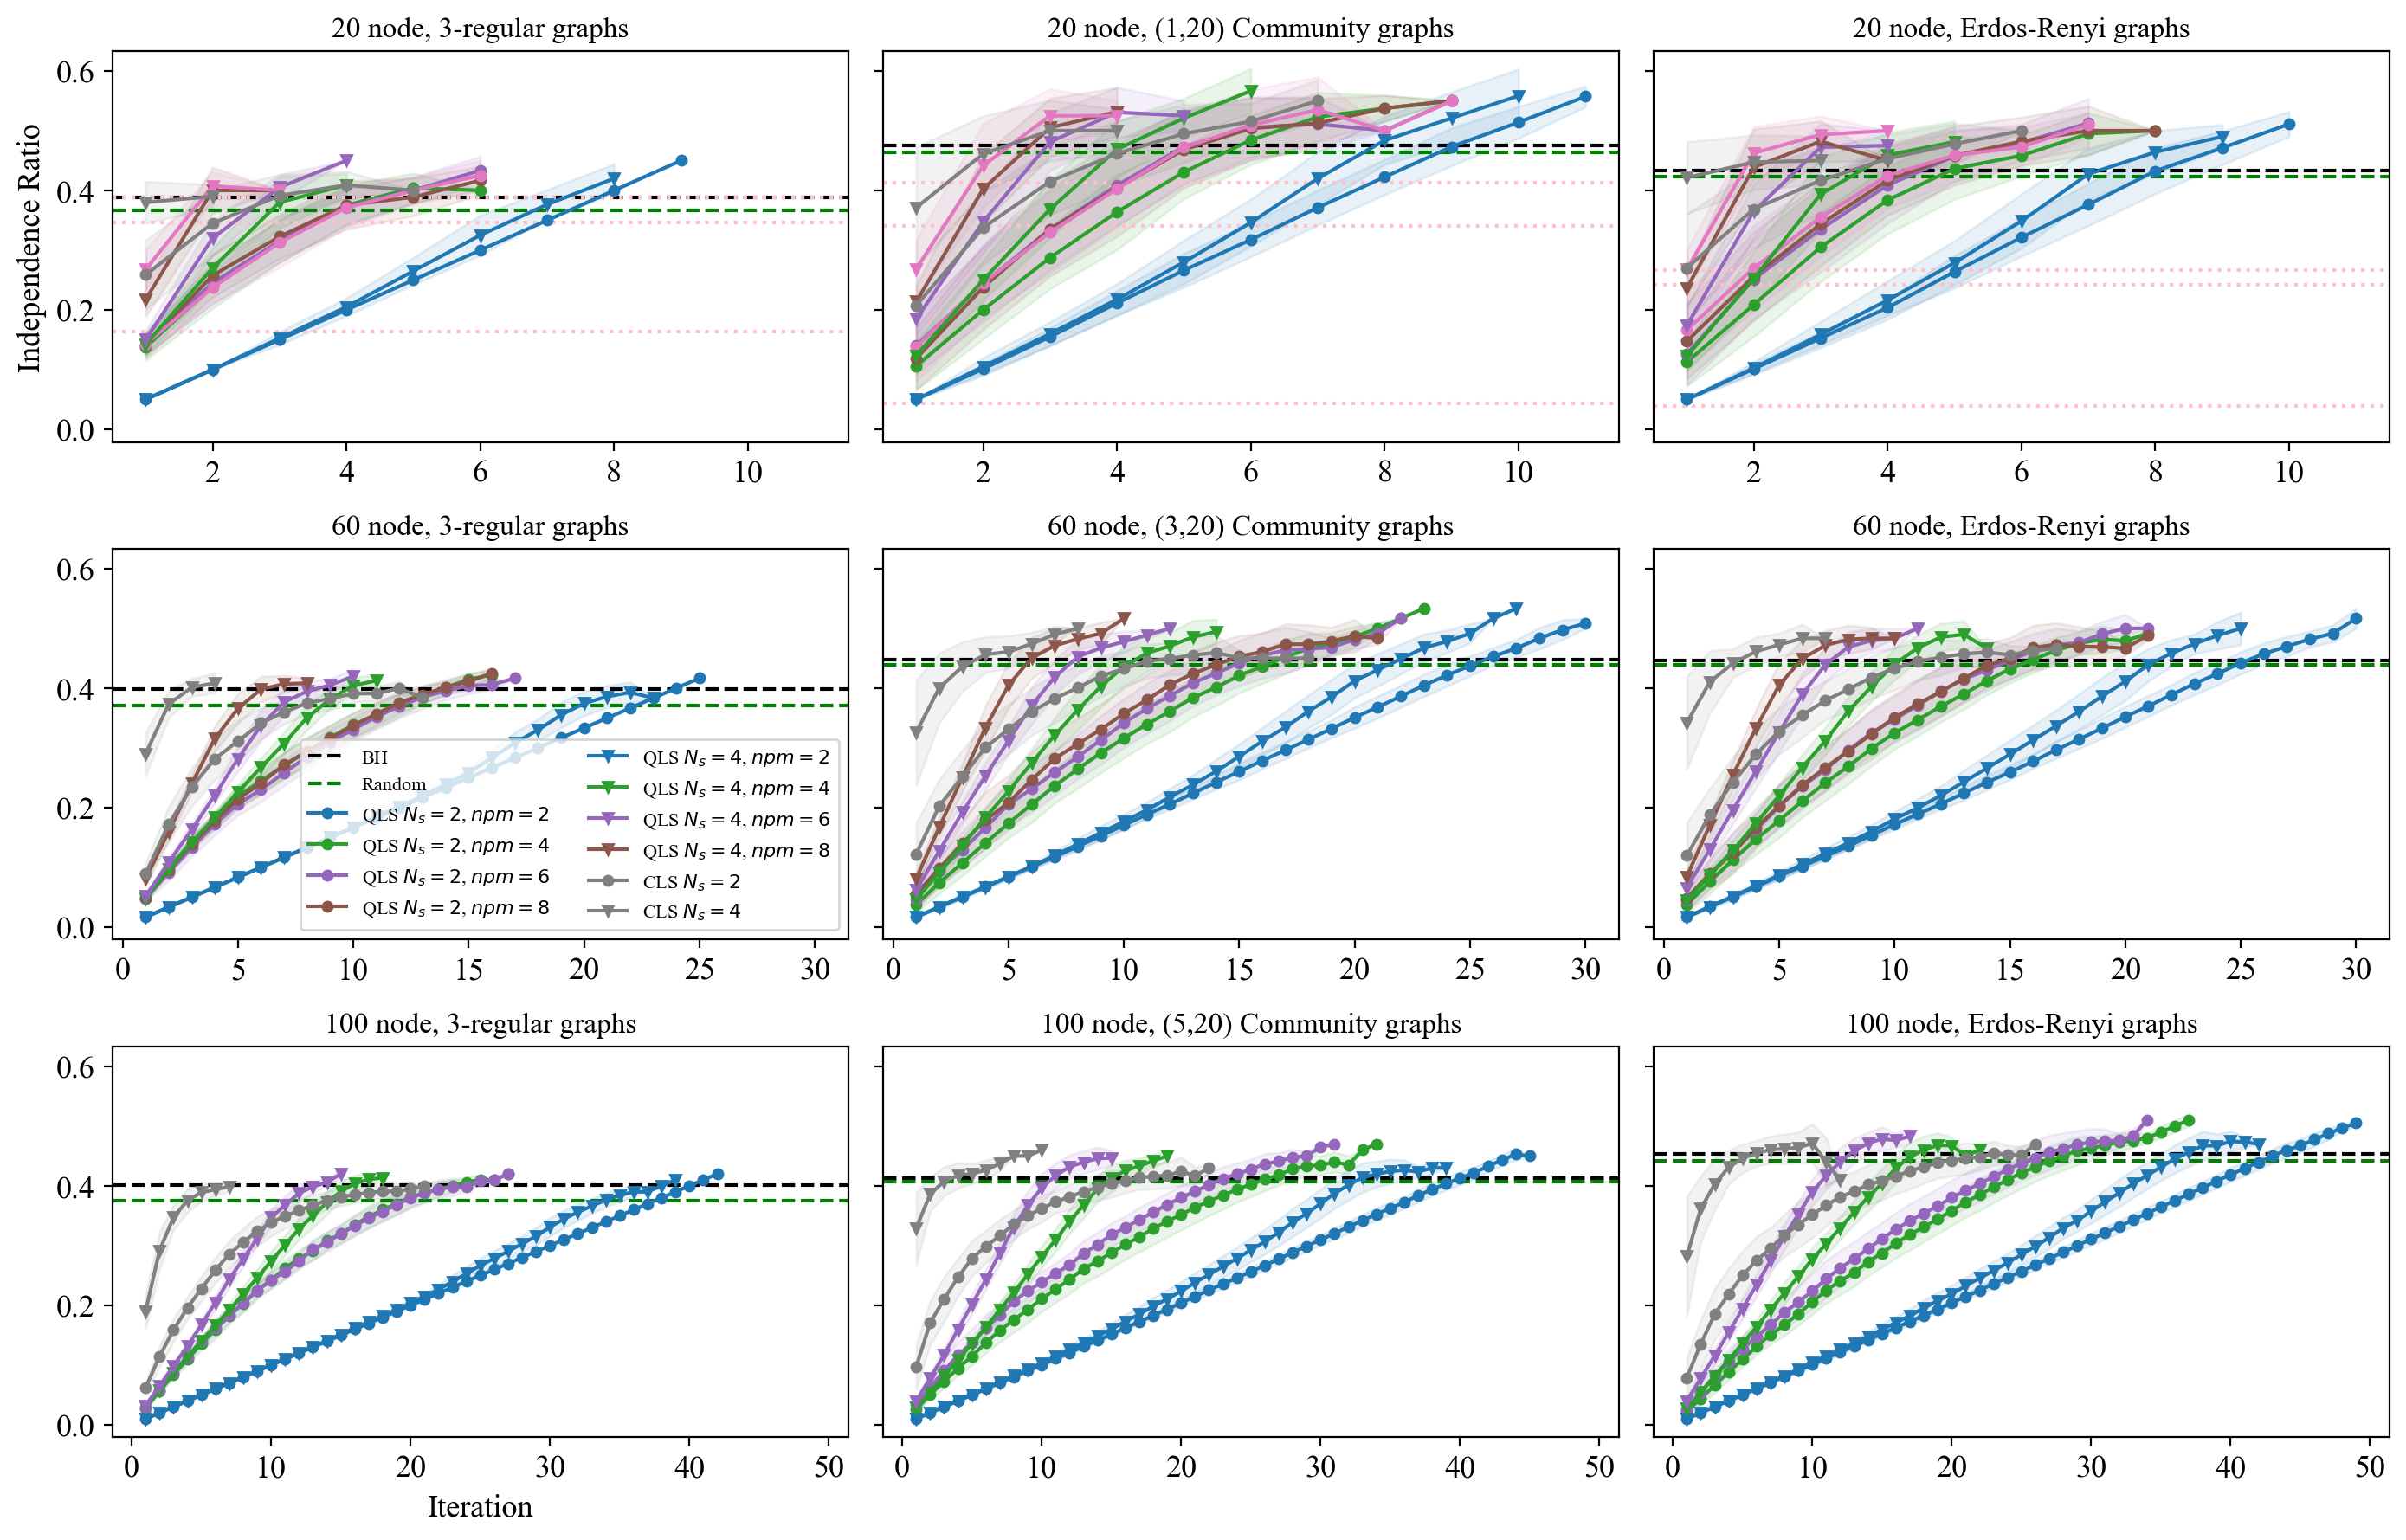

In [83]:
one_plot_all_data(all_data, verbose=0, savefn='figures/three_by_three.png')

# Plotting average approximation ratio as a function of NPM

In [137]:
def mis_performance(all_data, graph_type, graph_val, verbose=0, extra_data=None, savefn=None, classical_data=None):
    fig, ax = plt.subplots(dpi=150, figsize=[9,6])
    
    for (N, cur_data) in all_data:
        avg_y_vals = []
        std_y_vals = []
        x_vals = []
        # For each set of data with NS = n, NPM = k
        for (ns, npm, data) in cur_data:
            if verbose:
                print(f'NS = {ns}, NPM = {npm}, {len(data)} graphs')
            all_graph_y_vals = []
            # For each graph within that data set
            for (G, outs, graph_name) in data:
                if verbose:
                    print(f'\t{graph_name}, {len(outs)} reps')
                all_rep_y_vals = []
                # For each repetition on each graph
                for (rep, out) in outs:
                    qls_mis, history = out
                    # Compute independence ratio
                    all_rep_y_vals.append(hamming_weight(qls_mis) / bh_mis)

                # Once all the reps have been collected, take the best rep
                all_graph_y_vals.append(np.max(all_rep_y_vals))

            # Once all the graphs have been collected, average over them
            avg_y_vals.append(np.mean(all_graph_y_vals))
            std_y_vals.append(np.std(all_graph_y_vals))
            x_vals.append(npm)

        # After all the data has been averaged, plot the results
        ax.errorbar(x_vals, avg_y_vals, fmt='-o', ms=4, label=f'QLS ($N = {N}$, $N_s = {ns}$)')

        y1 = [m+s for m, s in zip(avg_y_vals, std_y_vals)]
        y2 = [m-s for m, s in zip(avg_y_vals, std_y_vals)]
        ax.fill_between(x_vals, y1, y2, alpha=0.2)
        
    if classical_data:
        for N, ns, data in classical_data:
            if verbose:
                print(f'Classical local search: N = {N}, NS = {ns}, {len(data)} graphs')
            all_graph_y_vals = []
            for G, outs, graph_name in data:
                if verbose:
                    print(f'\t{graph_name}, {len(outs)} reps')
                all_rep_y_vals = []
                for rep, out in outs:
                    cls_mis, history = out
                    # Compute independence ratio
                    all_rep_y_vals.append(hamming_weight(cls_mis) / bh_mis)
                
                # Retain the best out of len(out) reps
                all_graph_y_vals.append(np.max(all_rep_y_vals))
            
            avg_y_val = np.mean(all_graph_y_vals)
            std_y_vals.append(np.std(all_graph_y_vals))
            
            ax.axhline(y=avg_y_val, xmin=0.04, xmax=0.96, ls='-.', label=f'CLS ($N = {N}$, $N_s = {ns}$)')
        
    if extra_data:
        colors = ['tab:blue', 'tab:orange', 'tab:green']
        for i, (label, val) in enumerate(extra_data):
            ax.axhline(y=val, xmin=0.04, xmax=0.96, ls='--', alpha=0.4, label=label, c=colors[i])
    
    ax.axhline(y=1, xmin=0.04, xmax=0.96, ls='--', c='k', alpha=0.2)
    ax.legend(loc=[0.3,0.01], ncol=2, fontsize=8)
    ax.set_ylabel('Boppana-Halldorsson Approximation Ratio', fontsize=12)
    ax.set_xlabel('Number of Partial Mixers', fontsize=12)
    ax.set_title('Avg QLS performance on {}-regular graphs'.format(graph_val))
    
    if savefn is not None:
        plt.savefig(savefn)
    
    plt.show()
    plt.close()

In [117]:
all_data = []
graph_type = 'd'
graph_val = 3
for N in [20, 60, 100]:
    for ns in [2, 3, 4]:
        temp_data = []
        for npm in [2, 4, 6, 8, 10]:
            temp_data.append((ns, npm, get_pickles(N, graph_type, graph_val, npm, ns)))
        all_data.append((N, temp_data))

LOADING Quantum N20_d3_NS2_NPM2
LOADING Quantum N20_d3_NS2_NPM4
LOADING Quantum N20_d3_NS2_NPM6
LOADING Quantum N20_d3_NS2_NPM8
LOADING Quantum N20_d3_NS2_NPM10
LOADING Quantum N20_d3_NS3_NPM2
LOADING Quantum N20_d3_NS3_NPM4
LOADING Quantum N20_d3_NS3_NPM6
LOADING Quantum N20_d3_NS3_NPM8
LOADING Quantum N20_d3_NS3_NPM10
LOADING Quantum N20_d3_NS4_NPM2
LOADING Quantum N20_d3_NS4_NPM4
LOADING Quantum N20_d3_NS4_NPM6
LOADING Quantum N20_d3_NS4_NPM8
LOADING Quantum N20_d3_NS4_NPM10
LOADING Quantum N60_d3_NS2_NPM2
LOADING Quantum N60_d3_NS2_NPM4
LOADING Quantum N60_d3_NS2_NPM6
LOADING Quantum N60_d3_NS2_NPM8
LOADING Quantum N60_d3_NS2_NPM10
LOADING Quantum N60_d3_NS3_NPM2
LOADING Quantum N60_d3_NS3_NPM4
LOADING Quantum N60_d3_NS3_NPM6
LOADING Quantum N60_d3_NS3_NPM8
LOADING Quantum N60_d3_NS3_NPM10
LOADING Quantum N60_d3_NS4_NPM2
LOADING Quantum N60_d3_NS4_NPM4
LOADING Quantum N60_d3_NS4_NPM6
LOADING Quantum N60_d3_NS4_NPM8
LOADING Quantum N60_d3_NS4_NPM10
LOADING Quantum N100_d3_NS2_NPM2
L

In [118]:
all_classical_data = []
for N in [20, 60, 100]:
    for ns in [2, 3, 4]:
        all_classical_data.append((N, ns, get_pickles(N, graph_type, graph_val, -1, ns, quantum=False)))

LOADING Classical N20_d3_NS2
LOADING Classical N20_d3_NS3
LOADING Classical N20_d3_NS4
LOADING Classical N60_d3_NS2
LOADING Classical N60_d3_NS3
LOADING Classical N60_d3_NS4
LOADING Classical N100_d3_NS2
LOADING Classical N100_d3_NS3
LOADING Classical N100_d3_NS4


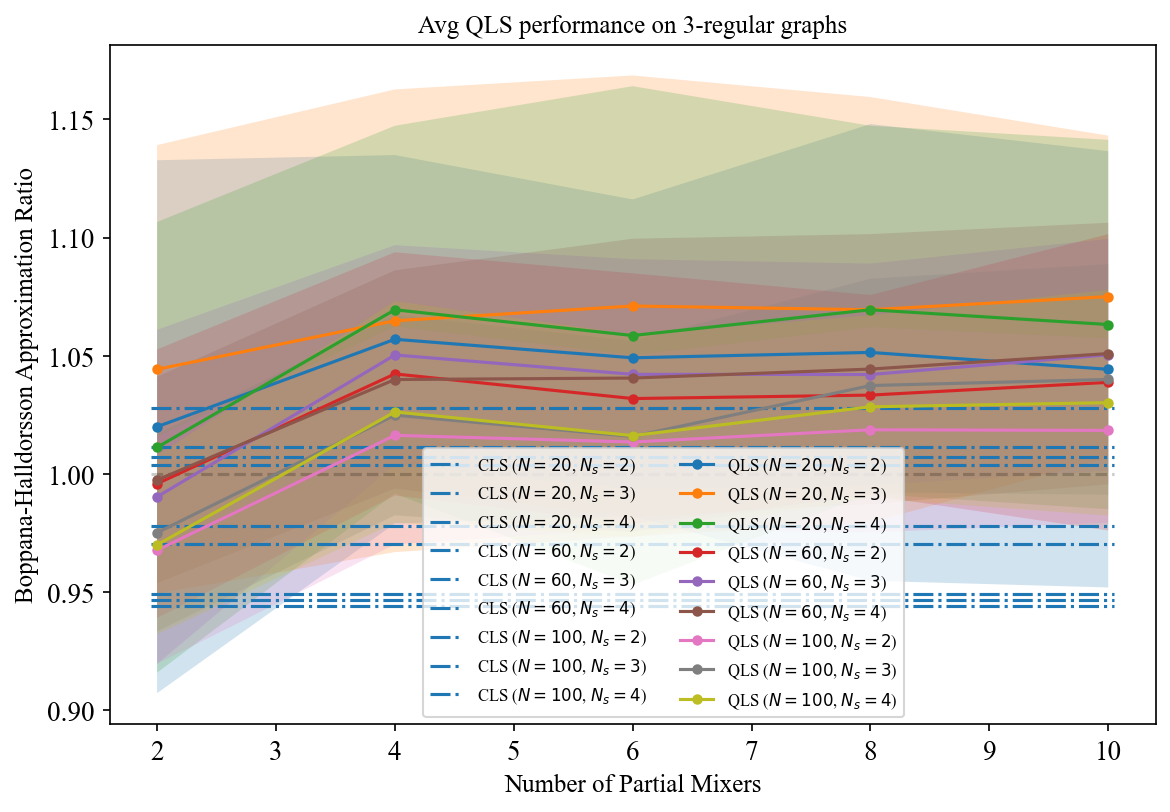

In [138]:
#extra_data = [('OnlineMIS (N=20)', onlinemis_N20), ('OnlineMIS (N=60)', onlinemis_N60), ('OnlineMIS (N=100)', onlinemis_N100)]
extra_data = None
savefn = 'figures/avg_qls_performance.pdf'
mis_performance(all_data, graph_type, graph_val, extra_data=extra_data, savefn=None, classical_data=all_classical_data, verbose=0)

# Plotting average NPM

In [224]:
def plot_npm(all_data, savefn=None):
    fig, ax = plt.subplots(dpi=150)
    
    plot_dict = {}
    all_npm_vals = []
    for (N, ndata) in all_data:
        #print('Num nodes:', N)
        cur_N_dict = {}
        for (npm, pdata) in ndata:
            all_npm_vals.append(npm)
            #print('\tNum partial mixers:', npm)
            temp_avg_npm = []
            for gdata in pdata:
                G, outs, graph_name = gdata
                #print('\t\t', graph_name)
                
                temp_reps = []
                # For each repetition on each graph
                for (rep, out) in outs:
                    qls_mis, history = out
                    # record the final independence ratio and the number of partial mixers at every iteration
                    temp_reps.append(((hamming_weight(qls_mis) / bh_mis), [len(itr[5]) for itr in history]))

                # Once all the reps have been collected, compute the average number of partial mixers for the best repetition
                best_rep = sorted(temp_reps, key=lambda tup: tup[0])[-1][1]
                temp_avg_npm.append(np.mean(best_rep))
            
            # After all graphs at this NPM have been collected, average them
            cur_N_dict[npm] = np.mean(temp_avg_npm)
        
        # Once all NPM's have been collected, save the results
        plot_dict[N] = cur_N_dict
    
    # Once all N values have been collected, plot!
    all_npm_vals = list(set(all_npm_vals))
    xlabels = list(plot_dict.keys())
    xvals = np.arange(1, len(plot_dict.keys()) + 1)
    width = 0.1
    offset = len(all_npm_vals) // 2 * width
    for i, npm_val in enumerate(all_npm_vals):
        yvals = [plot_dict[N][npm_val] for N in xlabels]
        cur_xvals = [xx - offset + i*width for xx in xvals]
        ax.bar(cur_xvals, yvals, label='NPM Limit = {}'.format(npm_val), width=width)

        
    ax.legend(fontsize=10, loc='lower right', ncol=2)
    ax.set_xticks(xvals)
    ax.set_xticklabels(xlabels)
    ax.set_ylabel('Avg Number of Partial Mixers', fontsize=12)
    ax.set_xlabel('Graph Size, N', fontsize=12)
    ax.set_title('Avg NPM for QLS on 3-regular graphs')
    
    if savefn is not None:
        plt.savefig(savefn)
    
    plt.show()
    plt.close()

In [218]:
all_data = []
graph_type = 'd'
graph_val = 3
for N in [20, 60, 100]:
    temp_data = []
    for npm in [2, 3, 4, 6, 8, 10]:
        temp_data.append((npm, get_pickles(N, graph_type, graph_val, npm)))
    all_data.append((N, temp_data))

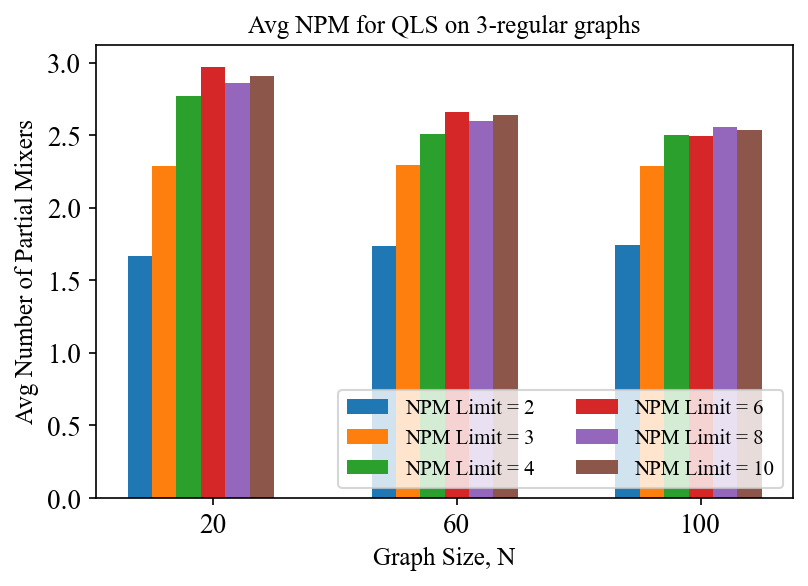

In [225]:
plot_npm(all_data, savefn='figures/avg_qls_npm.pdf')

# Plot average circuit size

In [172]:
def circuitsize(all_data, graph_type, verbose=0, extra_data=None, savefn=None, classical_data=None):
    npm_color_dict = {2:'tab:blue', 3:'tab:red', 4:'tab:orange', 6:'tab:green', 8:'tab:red', 10:'tab:purple'}
    ns_marker_dict = {2:'o', 3:'^', 4:'s'}
    for N, all_ns_data in all_data:
        if 'com' in graph_type:
            graph_type = f'com{int(N/20)}_pin10_pout2'
        fig, ax = plt.subplots(dpi=150, figsize=[4,6])
        max_x_val = 0
        for cur_data in all_ns_data:
            # For each set of data with NS = n, NPM = k
            for (ns, npm, data) in cur_data:
                if verbose:
                    print(f'NS = {ns}, NPM = {npm}, {len(data)} graphs')
                temp_all_graph_y_vals = []
                longest_rep = -1
                # For each graph within that data set
                for (G, outs, graph_name) in data:
                    if verbose:
                        print(f'\t{graph_name}, {len(outs)} reps')
                    all_rep_y_vals = []
                    # For each repetition on each graph
                    best_mis = -1
                    for (rep, out) in outs:
                        qls_mis, history = out
                        if qcopt.helper_funcs.hamming_weight(qls_mis) > best_mis:
                            best_history = history

                    # Take the best out of all reps
                    rep_circuit_sizes = []
                    for iteration in best_history:
                        # history.append((init_node, prev_mis_state, induced_G, opt_cost,
                        #                 opt_params, best_hot_nodes, qubits_to_nodes,
                        #                 nodes_to_qubits, cur_mis_state))
                        rep_circuit_sizes.append(len(iteration[6].keys()))

                    # Once all the reps have been collected, take the best rep
                    if len(rep_circuit_sizes) > longest_rep:
                        longest_rep = len(rep_circuit_sizes)
                    temp_all_graph_y_vals.append(rep_circuit_sizes)

                # Once all the graphs have been collected, average over them
                all_graph_y_vals = []
                for qls_execution in temp_all_graph_y_vals:
                    corrected_len_execution = [v for v in qls_execution]
                    if len(qls_execution) < longest_rep:
                        for _ in range(len(qls_execution), longest_rep):
                            corrected_len_execution.append(np.nan)
                    all_graph_y_vals.append(np.array(corrected_len_execution))
                all_graph_y_vals = np.array(all_graph_y_vals)
                avg_y_vals = np.nanmean(all_graph_y_vals, axis=0)
                std_y_vals = np.nanstd(all_graph_y_vals, axis=0)
                x_vals = np.arange(1,longest_rep+1)

                # After all the data has been averaged, plot the results
                y1 = [s for s in std_y_vals]
                y2 = [s if m-s > 0 else m for m, s in zip(avg_y_vals, std_y_vals)]
                ax.errorbar(x_vals, avg_y_vals, marker=ns_marker_dict[ns], ms=3, c=npm_color_dict[npm],
                            label=f'QLS ($N_s = {ns}$, $npm = {npm}$)', elinewidth=1, lw=1)

                y1 = [m+s for m,s in zip(avg_y_vals,std_y_vals)]
                y2 = [m-s if m-s > 0 else 0 for m, s in zip(avg_y_vals, std_y_vals)]
                #ax.fill_between(x_vals, y1, y2, alpha=0.1, color=npm_color_dict[npm])
                if x_vals[-1] > max_x_val:
                    max_x_val = x_vals[-1]
        
        # Plot classical local search results
        if classical_data:
            for N, ns, cls_data in classical_data[N]:
                temp_all_graph_y_vals = []
                longest_rep = -1
                # For each graph within that data set
                for G, all_reps, graph_name in cls_data:
                    if verbose:
                        print(f'\t{graph_name}, {len(all_reps)} reps')
                    all_rep_y_vals = []
                    # For each repetition on each graph
                    best_mis = -1
                    for rep, out in all_reps:
                        cls_mis, history = out
                        if qcopt.helper_funcs.hamming_weight(cls_mis) > best_mis:
                            best_history = history

                    # Take the best out of all reps
                    rep_neighborhood_sizes = []
                    for iteration in best_history:
                        # history.append((init_node, prev_mis_state, induced_G, cur_mis_state))
                        rep_neighborhood_sizes.append(len(iteration[2].nodes))

                    if len(rep_neighborhood_sizes) > longest_rep:
                        longest_rep = len(rep_neighborhood_sizes)
                    temp_all_graph_y_vals.append(rep_neighborhood_sizes)

                # Once all the graphs have been collected, average over them
                all_graph_y_vals = []
                for cls_execution in temp_all_graph_y_vals:
                    corrected_len_execution = [v for v in cls_execution]
                    if len(cls_execution) < longest_rep:
                        for _ in range(len(cls_execution), longest_rep):
                            corrected_len_execution.append(0)
                    all_graph_y_vals.append(np.array(corrected_len_execution))
                all_graph_y_vals = np.array(all_graph_y_vals)
                avg_y_vals = np.nanmean(all_graph_y_vals, axis=0)
                std_y_vals = np.nanstd(all_graph_y_vals, axis=0)
                x_vals = np.arange(1,longest_rep+1)
                
                # After all the data has been averaged, plot the results                
                y1 = [s for s in std_y_vals]
                y2 = [s if m-s > 0 else m for m, s in zip(avg_y_vals, std_y_vals)]
                ax.errorbar(x_vals, avg_y_vals, marker=ns_marker_dict[ns], ms=3, c='grey',
                            label=f'CLS ($N_s = {ns}$)', elinewidth=1, lw=1)
                
                y1 = [m+s for m,s in zip(avg_y_vals,std_y_vals)]
                y2 = [m-s if m-s > 0 else 0 for m, s in zip(avg_y_vals, std_y_vals)]
                #ax.fill_between(x_vals, y1, y2, alpha=0.1, color='grey')

        # Plot results
        ax.axhline(y=0, xmin=0.04, xmax=0.96, ls='--', c='k', alpha=0.2)
        ax.legend(ncol=1, fontsize=8)
        ax.set_ylabel('Qubits / Nodes', fontsize=12)
        ax.set_xlabel('Iteration', fontsize=12)
        ax.set_title(f'Avg Circuit size on N={N} {graph_type} graphs')
        ax.set_xticks(range(1,max_x_val+1, 5))

        if savefn is not None:
            plt.savefig(savefn)

        plt.show()
        plt.close()

### 3-regular graphs

In [119]:
all_data = []
graph_type = 'd3'
for N in [20, 60, 100]:
    ns_data = []
    for ns in [2, 3, 4]:
        temp_data = []
        for npm in [2, 4, 6, 8, 10]:
            temp_data.append((ns, npm, get_pickles(N, graph_type, npm, ns)))
        ns_data.append(temp_data)
    all_data.append((N, ns_data))

all_classical_data = {}
for N in [20, 60, 100]:
    all_classical_data[N] = []
    for ns in [2, 3, 4]:
        all_classical_data[N].append((N, ns, get_pickles(N, graph_type, -1, ns, quantum=False)))

LOADING Quantum N20_d3_NS2_NPM2
LOADING Quantum N20_d3_NS2_NPM4
LOADING Quantum N20_d3_NS2_NPM6
LOADING Quantum N20_d3_NS2_NPM8
LOADING Quantum N20_d3_NS2_NPM10
LOADING Quantum N20_d3_NS3_NPM2
LOADING Quantum N20_d3_NS3_NPM4
LOADING Quantum N20_d3_NS3_NPM6
LOADING Quantum N20_d3_NS3_NPM8
LOADING Quantum N20_d3_NS3_NPM10
LOADING Quantum N20_d3_NS4_NPM2
LOADING Quantum N20_d3_NS4_NPM4
LOADING Quantum N20_d3_NS4_NPM6
LOADING Quantum N20_d3_NS4_NPM8
LOADING Quantum N20_d3_NS4_NPM10
LOADING Quantum N60_d3_NS2_NPM2
LOADING Quantum N60_d3_NS2_NPM4
LOADING Quantum N60_d3_NS2_NPM6
LOADING Quantum N60_d3_NS2_NPM8
LOADING Quantum N60_d3_NS2_NPM10
LOADING Quantum N60_d3_NS3_NPM2
LOADING Quantum N60_d3_NS3_NPM4
LOADING Quantum N60_d3_NS3_NPM6
LOADING Quantum N60_d3_NS3_NPM8
LOADING Quantum N60_d3_NS3_NPM10
LOADING Quantum N60_d3_NS4_NPM2
LOADING Quantum N60_d3_NS4_NPM4
LOADING Quantum N60_d3_NS4_NPM6
LOADING Quantum N60_d3_NS4_NPM8
LOADING Quantum N60_d3_NS4_NPM10
LOADING Quantum N100_d3_NS2_NPM2
L

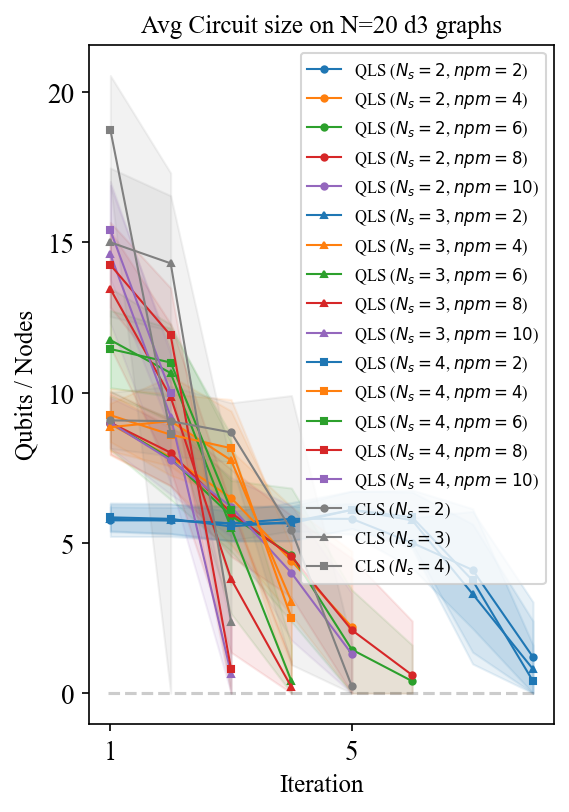

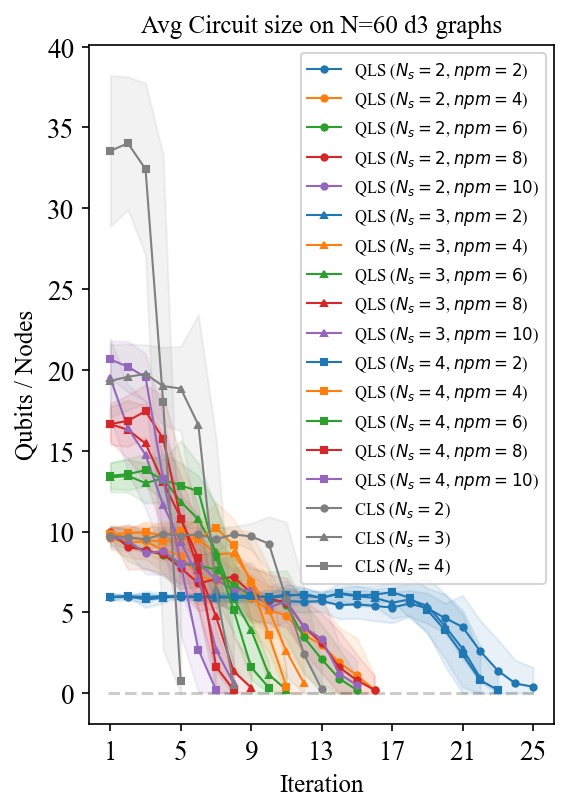

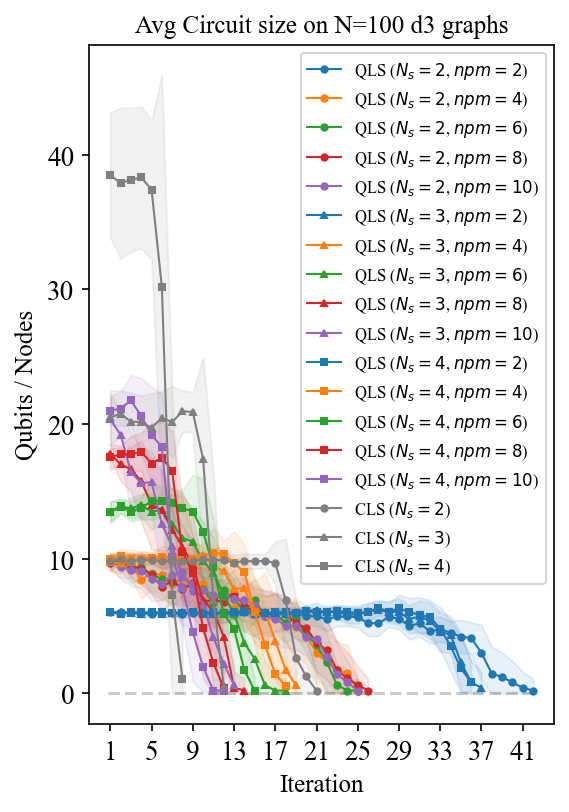

In [120]:
circuitsize(all_data, graph_type, savefn=None, classical_data=all_classical_data, verbose=0)

### Planted-partition graphs

In [29]:
all_data = []
for N in [20, 60, 100]:
    graph_type = f'com{int(N/20)}_pin10_pout2'
    ns_data = []
    for ns in [2, 3, 4]:
        temp_data = []
        for npm in [2, 4, 6]:
            temp_data.append((ns, npm, get_pickles(N, graph_type, npm, ns)))
        ns_data.append(temp_data)
    all_data.append((N, ns_data))

all_classical_data = {}
for N in [20, 60, 100]:
    graph_type = f'com{int(N/20)}_pin10_pout2'
    all_classical_data[N] = []
    for ns in [2, 3, 4]:
        all_classical_data[N].append((N, ns, get_pickles(N, graph_type, -1, ns, quantum=False)))

LOADING Quantum N20_com1_pin10_pout2_NS2_NPM2
LOADING Quantum N20_com1_pin10_pout2_NS2_NPM4
LOADING Quantum N20_com1_pin10_pout2_NS2_NPM6
LOADING Quantum N20_com1_pin10_pout2_NS3_NPM2
LOADING Quantum N20_com1_pin10_pout2_NS3_NPM4
LOADING Quantum N20_com1_pin10_pout2_NS3_NPM6
LOADING Quantum N20_com1_pin10_pout2_NS4_NPM2
LOADING Quantum N20_com1_pin10_pout2_NS4_NPM4
LOADING Quantum N20_com1_pin10_pout2_NS4_NPM6
LOADING Quantum N60_com3_pin10_pout2_NS2_NPM2
LOADING Quantum N60_com3_pin10_pout2_NS2_NPM4
LOADING Quantum N60_com3_pin10_pout2_NS2_NPM6
LOADING Quantum N60_com3_pin10_pout2_NS3_NPM2
LOADING Quantum N60_com3_pin10_pout2_NS3_NPM4
LOADING Quantum N60_com3_pin10_pout2_NS3_NPM6
LOADING Quantum N60_com3_pin10_pout2_NS4_NPM2
LOADING Quantum N60_com3_pin10_pout2_NS4_NPM4
LOADING Quantum N60_com3_pin10_pout2_NS4_NPM6
LOADING Quantum N100_com5_pin10_pout2_NS2_NPM2
LOADING Quantum N100_com5_pin10_pout2_NS2_NPM4
LOADING Quantum N100_com5_pin10_pout2_NS2_NPM6
LOADING Quantum N100_com5_pin10

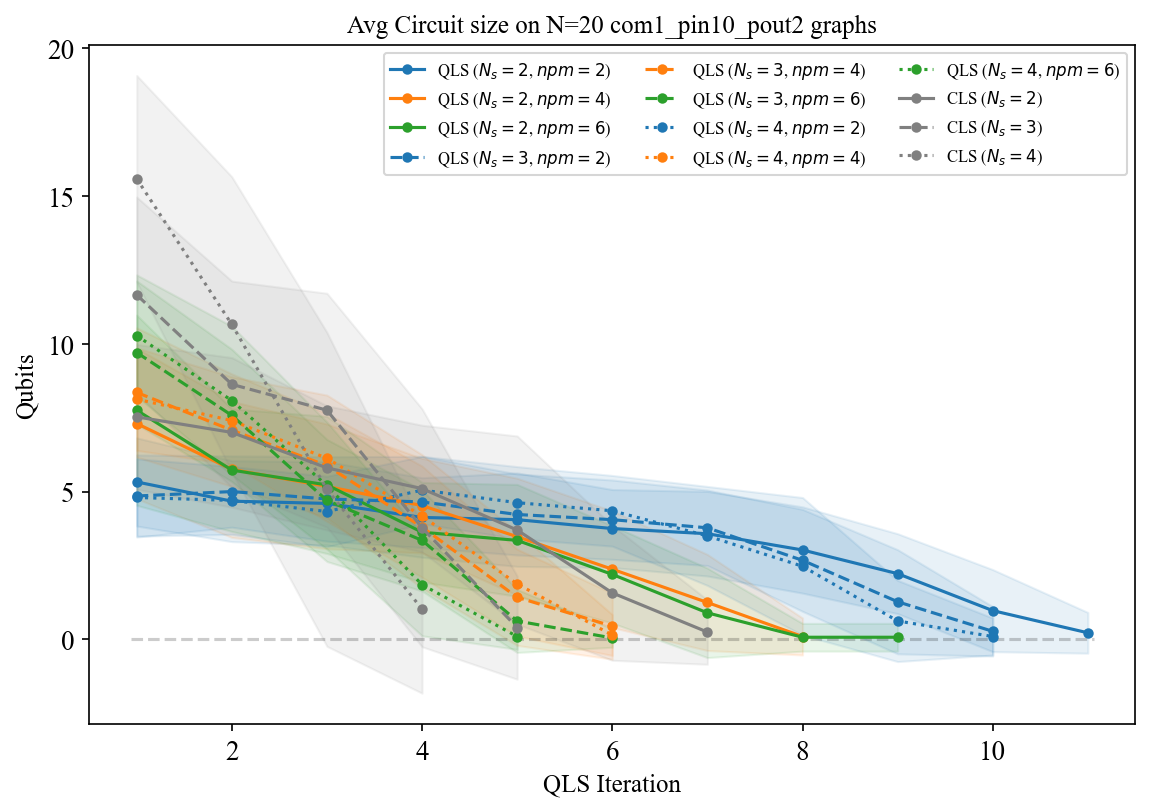

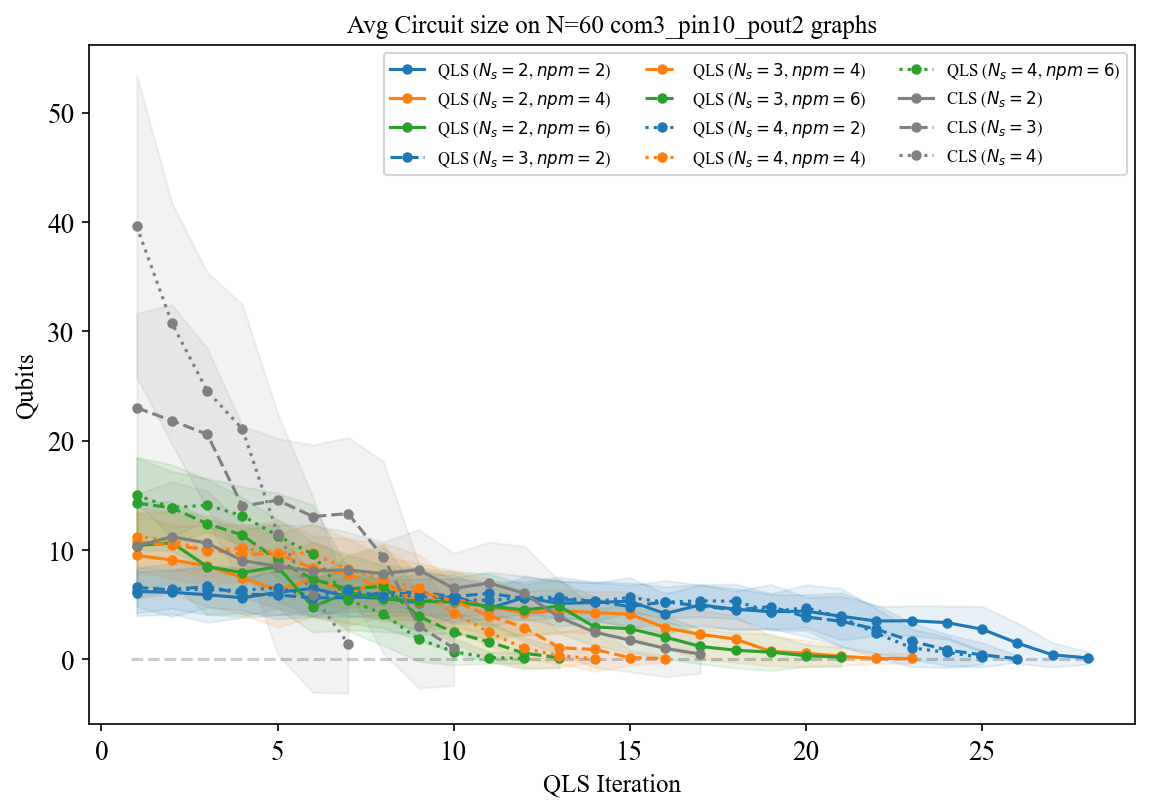

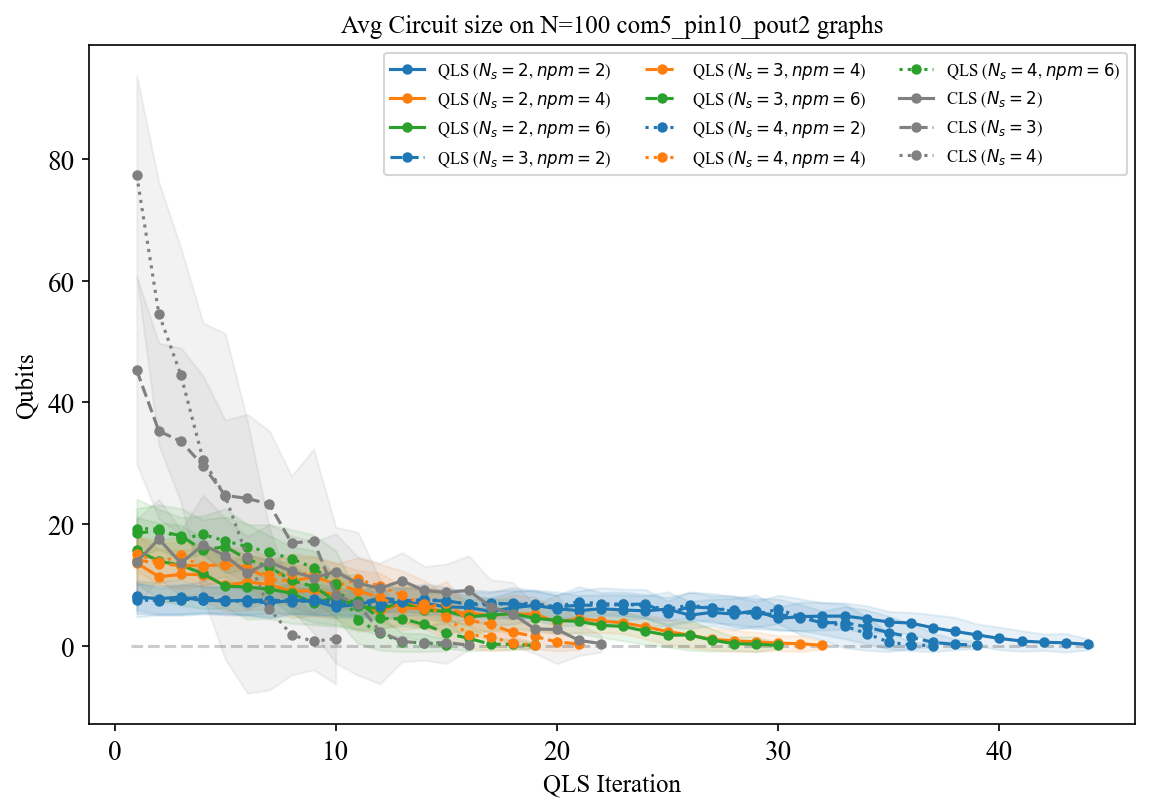

In [30]:
circuitsize(all_data, 'com', savefn=None, classical_data=all_classical_data, verbose=0)

### Erdos-Renyi graphs

In [31]:
all_data = []
graph_type = 'er3'
for N in [20, 60, 100]:
    ns_data = []
    for ns in [2, 3, 4]:
        temp_data = []
        for npm in [2, 4, 6]:
            temp_data.append((ns, npm, get_pickles(N, graph_type, npm, ns)))
        ns_data.append(temp_data)
    all_data.append((N, ns_data))

all_classical_data = {}
for N in [20, 60, 100]:
    all_classical_data[N] = []
    for ns in [2, 3, 4]:
        all_classical_data[N].append((N, ns, get_pickles(N, graph_type, -1, ns, quantum=False)))

LOADING Quantum N20_er3_NS2_NPM2
LOADING Quantum N20_er3_NS2_NPM4
LOADING Quantum N20_er3_NS2_NPM6
LOADING Quantum N20_er3_NS3_NPM2
LOADING Quantum N20_er3_NS3_NPM4
LOADING Quantum N20_er3_NS3_NPM6
LOADING Quantum N20_er3_NS4_NPM2
LOADING Quantum N20_er3_NS4_NPM4
LOADING Quantum N20_er3_NS4_NPM6
LOADING Quantum N60_er3_NS2_NPM2
LOADING Quantum N60_er3_NS2_NPM4
LOADING Quantum N60_er3_NS2_NPM6
LOADING Quantum N60_er3_NS3_NPM2
LOADING Quantum N60_er3_NS3_NPM4
LOADING Quantum N60_er3_NS3_NPM6
LOADING Quantum N60_er3_NS4_NPM2
LOADING Quantum N60_er3_NS4_NPM4
LOADING Quantum N60_er3_NS4_NPM6
LOADING Quantum N100_er3_NS2_NPM2
LOADING Quantum N100_er3_NS2_NPM4
LOADING Quantum N100_er3_NS2_NPM6
LOADING Quantum N100_er3_NS3_NPM2
LOADING Quantum N100_er3_NS3_NPM4
LOADING Quantum N100_er3_NS3_NPM6
LOADING Quantum N100_er3_NS4_NPM2
LOADING Quantum N100_er3_NS4_NPM4
LOADING Quantum N100_er3_NS4_NPM6
LOADING Classical N20_er3_NS2
LOADING Classical N20_er3_NS3
LOADING Classical N20_er3_NS4
LOADING Cl

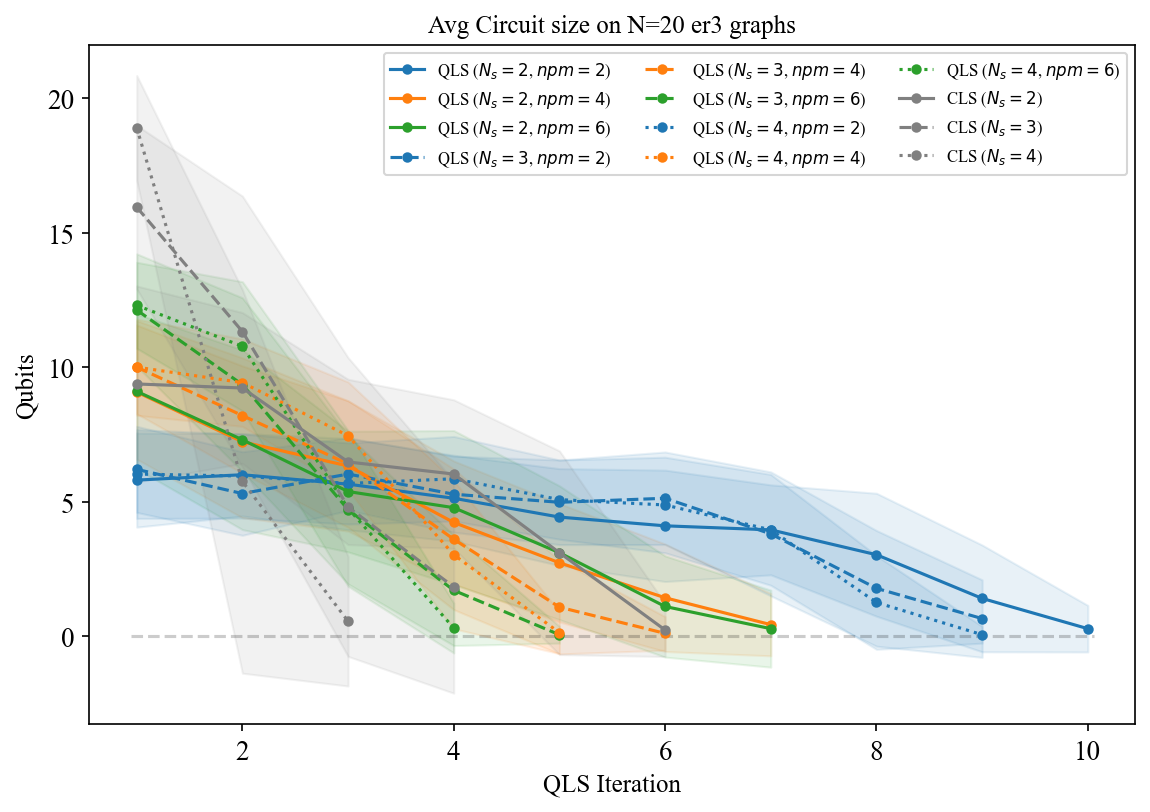

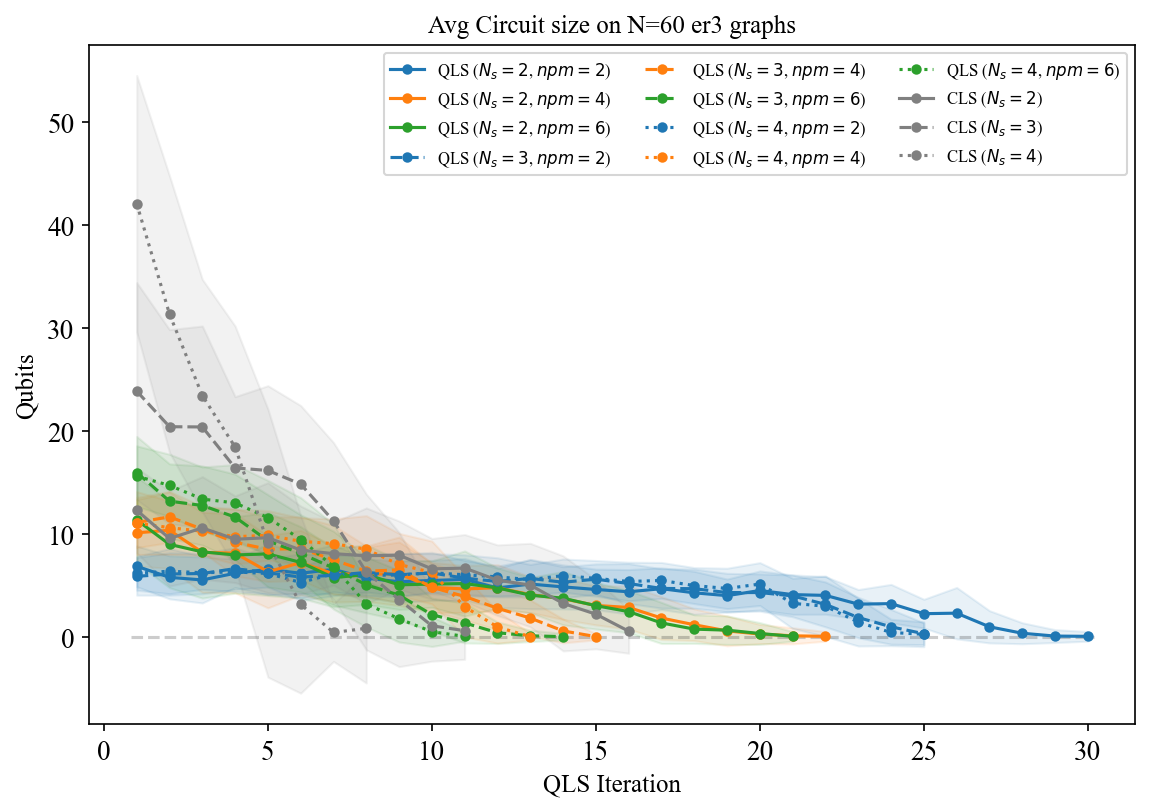

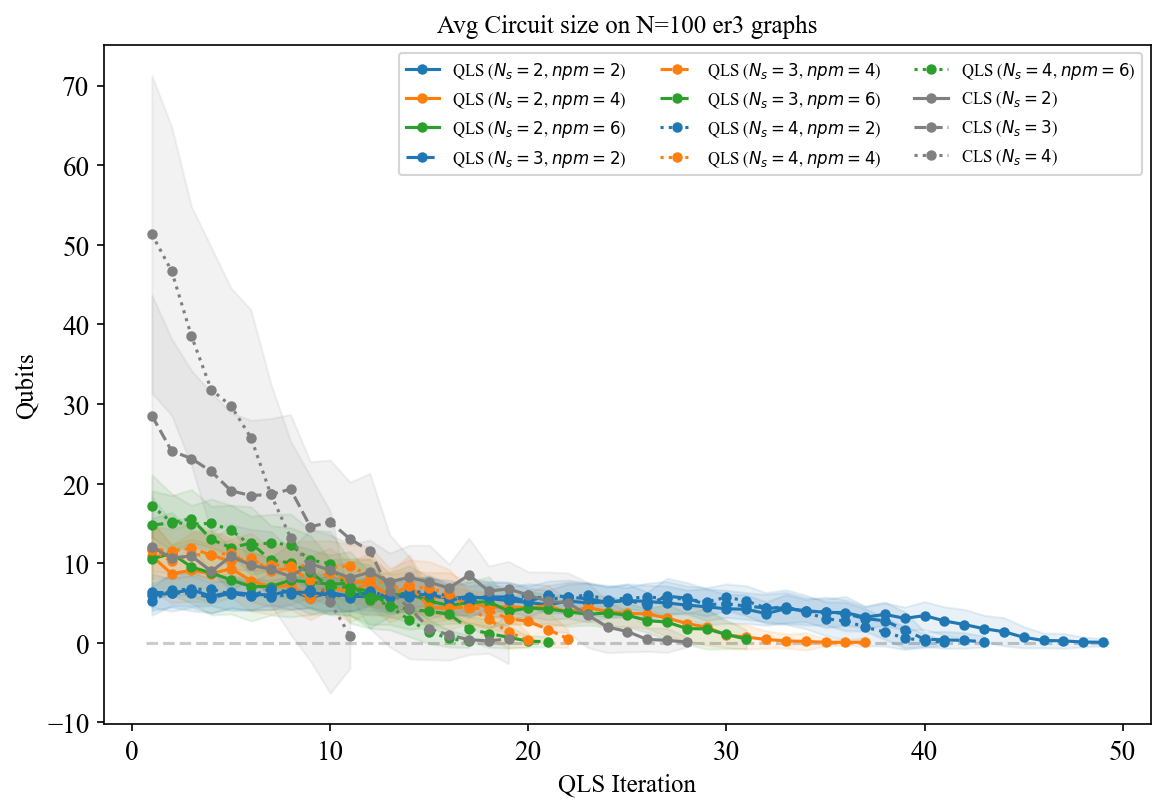

In [32]:
circuitsize(all_data, 'er3', savefn=None, classical_data=all_classical_data, verbose=0)

### Paper plot

In [173]:
all_data = []
graph_type = 'd3'
npms = {2:[2,6,10], 4:[2,6,10]}
for N in [100]:
    ns_data = []
    for ns in [2, 4]:
        temp_data = []
        for npm in npms[ns]:
            temp_data.append((ns, npm, get_pickles(N, graph_type, npm, ns)))
        ns_data.append(temp_data)
    all_data.append((N, ns_data))

all_classical_data = {}
for N in [100]:
    all_classical_data[N] = []
    for ns in [2, 3, 4]:
        all_classical_data[N].append((N, ns, get_pickles(N, graph_type, -1, ns, quantum=False)))

LOADING Quantum N100_d3_NS2_NPM2
LOADING Quantum N100_d3_NS2_NPM6
LOADING Quantum N100_d3_NS2_NPM10
LOADING Quantum N100_d3_NS4_NPM2
LOADING Quantum N100_d3_NS4_NPM6
LOADING Quantum N100_d3_NS4_NPM10
LOADING Classical N100_d3_NS2
LOADING Classical N100_d3_NS3
LOADING Classical N100_d3_NS4


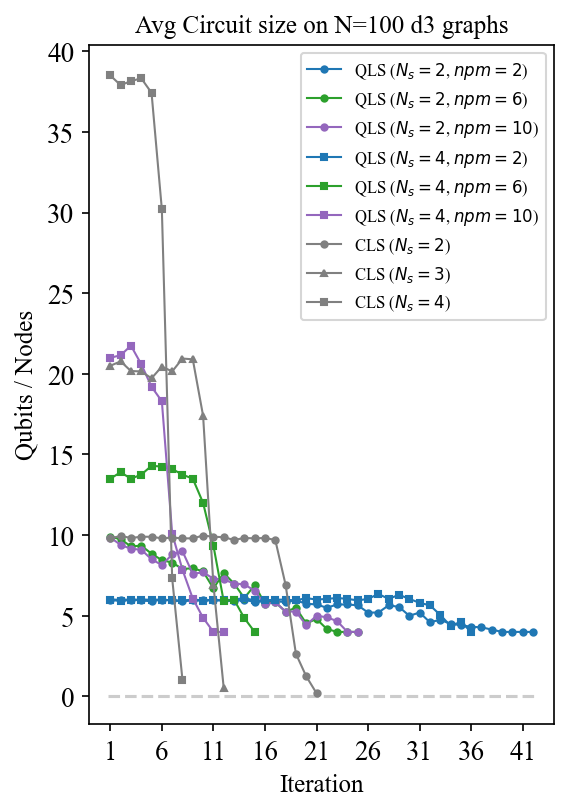

In [174]:
savefn = 'figures/circuit_size_d3.png'
#savefn = None
circuitsize(all_data, graph_type, savefn=savefn, classical_data=all_classical_data, verbose=0)

In [175]:
all_data = []
graph_type = 'com5_pin10_pout2'
npms = {2:[2,6], 4:[2,4,6]}
for N in [100]:
    ns_data = []
    for ns in [2, 4]:
        temp_data = []
        for npm in npms[ns]:
            temp_data.append((ns, npm, get_pickles(N, graph_type, npm, ns)))
        ns_data.append(temp_data)
    all_data.append((N, ns_data))

all_classical_data = {}
for N in [100]:
    all_classical_data[N] = []
    for ns in [2, 3, 4]:
        all_classical_data[N].append((N, ns, get_pickles(N, graph_type, -1, ns, quantum=False)))

LOADING Quantum N100_com5_pin10_pout2_NS2_NPM2
LOADING Quantum N100_com5_pin10_pout2_NS2_NPM6
LOADING Quantum N100_com5_pin10_pout2_NS4_NPM2
LOADING Quantum N100_com5_pin10_pout2_NS4_NPM4
LOADING Quantum N100_com5_pin10_pout2_NS4_NPM6
LOADING Classical N100_com5_pin10_pout2_NS2
LOADING Classical N100_com5_pin10_pout2_NS3
LOADING Classical N100_com5_pin10_pout2_NS4


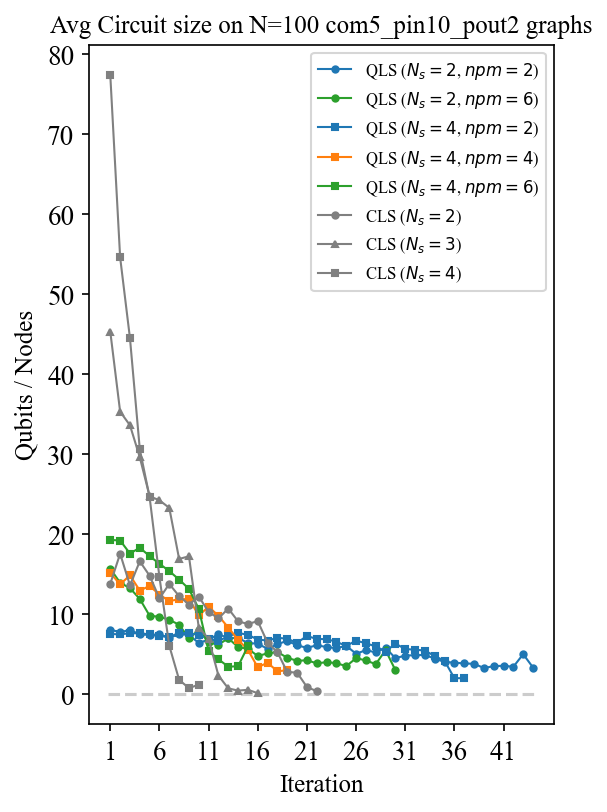

In [176]:
circuitsize(all_data, graph_type, savefn='figures/circuit_size_pp.png', classical_data=all_classical_data, verbose=0)

In [177]:
all_data = []
graph_type = 'er3'
npms = {2:[2,6], 4:[2,4,6]}
for N in [100]:
    ns_data = []
    for ns in [2, 4]:
        temp_data = []
        for npm in npms[ns]:
            temp_data.append((ns, npm, get_pickles(N, graph_type, npm, ns)))
        ns_data.append(temp_data)
    all_data.append((N, ns_data))

all_classical_data = {}
for N in [100]:
    all_classical_data[N] = []
    for ns in [2, 3, 4]:
        all_classical_data[N].append((N, ns, get_pickles(N, graph_type, -1, ns, quantum=False)))

LOADING Quantum N100_er3_NS2_NPM2
LOADING Quantum N100_er3_NS2_NPM6
LOADING Quantum N100_er3_NS4_NPM2
LOADING Quantum N100_er3_NS4_NPM4
LOADING Quantum N100_er3_NS4_NPM6
LOADING Classical N100_er3_NS2
LOADING Classical N100_er3_NS3
LOADING Classical N100_er3_NS4


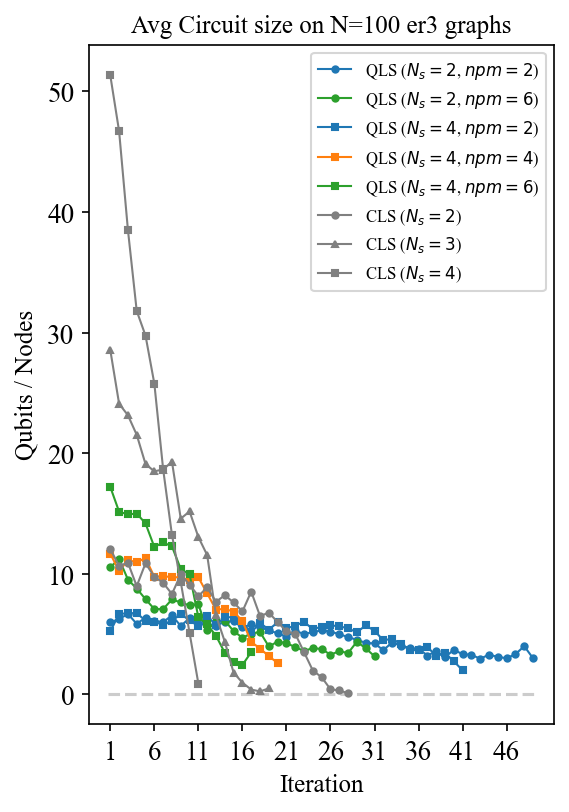

In [178]:
circuitsize(all_data, graph_type, savefn='figures/circuit_size_er.png', classical_data=all_classical_data, verbose=0)

# Circuit size, partial mixers, and gate count histogram

# Plot $N_s$ x $npm$ x independence ratio heatmap

In [364]:
def performance_heatmap(all_data, N, graph_type, verbose=0, extra_data=None, savefn=None):
    fig, ax = plt.subplots(dpi=150, figsize=[6,3])
    
    ns_dict = {ns: [] for (ns, npm, data) in all_data}
    
    # For each set of data with N_s = j, NPM = k
    # get the average independence ratio
    for (ns, npm, data) in all_data:
        if verbose:
            print(f'NS{ns} NPM{npm}, {len(data)} graphs')
        all_graph_y_vals = []
        # For each graph within that data set
        for (G, outs, graph_name) in data:
            all_rep_y_vals = []
            # For each repetition on each graph
            for (rep, out) in outs:
                qls_mis, history = out
                all_rep_y_vals.append(qcopt.helper_funcs.hamming_weight(qls_mis) / len(G.nodes))
            
            # Once all the reps have been collected, take the best repetition
            if verbose > 1:
                print(ns, npm, graph_name, len(outs))
            all_graph_y_vals.append(sorted(all_rep_y_vals)[-1])
        
        # Once all the graphs have been collected, average over them
        ns_dict[ns].append(np.mean(all_graph_y_vals))
            
    # After all the data has been averaged, plot the results
    ns_keys = list(set([ns for (ns, _, _) in all_data]))[::-1]
    npm_keys = sorted(list(set([npm for (_, npm, _) in all_data])))
    data_array = np.array([ns_dict[ns] for ns in ns_keys])
    
    im = ax.imshow(data_array, cmap='plasma')
    cbar = ax.figure.colorbar(im, ax=ax, )
    cbar.ax.set_ylabel('Independence Ratio', rotation=-90, va="bottom")
    
    ax.set_xticks(np.arange(len(npm_keys)))
    ax.set_xticklabels(npm_keys)
    ax.set_yticks(np.arange(len(ns_keys)))
    ax.set_yticklabels(ns_keys)
    
    ax.set_ylabel('$N_s$', fontsize=13)
    ax.set_xlabel('Number of partial mixers', fontsize=13)
    ax.set_title(f'Average QLS performance on {graph_type} graphs as a function of $(N_s, npm)$')
    
    if savefn is not None:
        plt.savefig(savefn)
    
    fig.tight_layout()
    
    plt.show()
    plt.close()

## N = 20

### 3-regular graphs

In [181]:
all_data = []
N = 20
graph_type = 'd3'
for ns in [2,3,4]:
    for npm in [2, 4, 6, 8, 10]:
        all_data.append((ns, npm, get_pickles(N, graph_type, npm, ns)))

LOADING Quantum N20_d3_NS2_NPM2
LOADING Quantum N20_d3_NS2_NPM4
LOADING Quantum N20_d3_NS2_NPM6
LOADING Quantum N20_d3_NS2_NPM8
LOADING Quantum N20_d3_NS2_NPM10
LOADING Quantum N20_d3_NS3_NPM2
LOADING Quantum N20_d3_NS3_NPM4
LOADING Quantum N20_d3_NS3_NPM6
LOADING Quantum N20_d3_NS3_NPM8
LOADING Quantum N20_d3_NS3_NPM10
LOADING Quantum N20_d3_NS4_NPM2
LOADING Quantum N20_d3_NS4_NPM4
LOADING Quantum N20_d3_NS4_NPM6
LOADING Quantum N20_d3_NS4_NPM8
LOADING Quantum N20_d3_NS4_NPM10


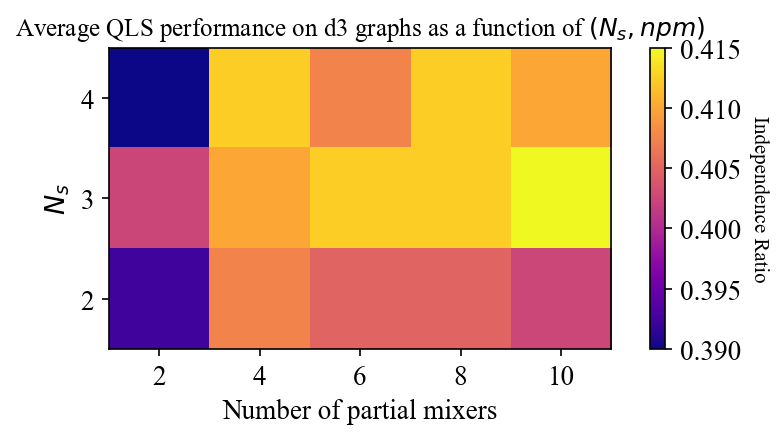

In [182]:
savefn = 'figures/qls_N20.pdf'
performance_heatmap(all_data, N, graph_type, savefn=None, verbose=0)

### Planted-partition graphs

In [183]:
all_data = []
N = 20
graph_type = 'com1_pin10_pout2'
for ns in [2,3,4]:
    for npm in [2, 4, 6, 8, 10]:
        all_data.append((ns, npm, get_pickles(N, graph_type, npm, ns)))

LOADING Quantum N20_com1_pin10_pout2_NS2_NPM2
LOADING Quantum N20_com1_pin10_pout2_NS2_NPM4
LOADING Quantum N20_com1_pin10_pout2_NS2_NPM6
LOADING Quantum N20_com1_pin10_pout2_NS2_NPM8
LOADING Quantum N20_com1_pin10_pout2_NS2_NPM10
LOADING Quantum N20_com1_pin10_pout2_NS3_NPM2
LOADING Quantum N20_com1_pin10_pout2_NS3_NPM4
LOADING Quantum N20_com1_pin10_pout2_NS3_NPM6
LOADING Quantum N20_com1_pin10_pout2_NS3_NPM8
LOADING Quantum N20_com1_pin10_pout2_NS3_NPM10
LOADING Quantum N20_com1_pin10_pout2_NS4_NPM2
LOADING Quantum N20_com1_pin10_pout2_NS4_NPM4
LOADING Quantum N20_com1_pin10_pout2_NS4_NPM6
LOADING Quantum N20_com1_pin10_pout2_NS4_NPM8
LOADING Quantum N20_com1_pin10_pout2_NS4_NPM10


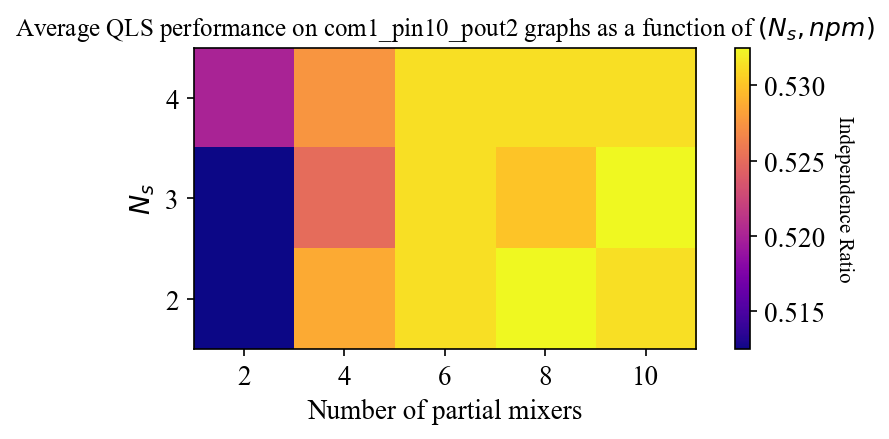

In [184]:
savefn = 'figures/qls_N20.pdf'
performance_heatmap(all_data, N, graph_type, savefn=None, verbose=0)

### Erdos-Renyi graphs

In [360]:
all_data = []
N = 20
graph_type = 'er3'
for ns in [2,3,4]:
    for npm in [2, 4, 6, 8, 10]:
        all_data.append((ns, npm, get_pickles(N, graph_type, npm, ns)))

LOADING Quantum N20_er3_NS2_NPM2
LOADING Quantum N20_er3_NS2_NPM4
LOADING Quantum N20_er3_NS2_NPM6
LOADING Quantum N20_er3_NS2_NPM8
LOADING Quantum N20_er3_NS2_NPM10
LOADING Quantum N20_er3_NS3_NPM2
LOADING Quantum N20_er3_NS3_NPM4
LOADING Quantum N20_er3_NS3_NPM6
LOADING Quantum N20_er3_NS3_NPM8
LOADING Quantum N20_er3_NS3_NPM10
LOADING Quantum N20_er3_NS4_NPM2
LOADING Quantum N20_er3_NS4_NPM4
LOADING Quantum N20_er3_NS4_NPM6
LOADING Quantum N20_er3_NS4_NPM8
LOADING Quantum N20_er3_NS4_NPM10


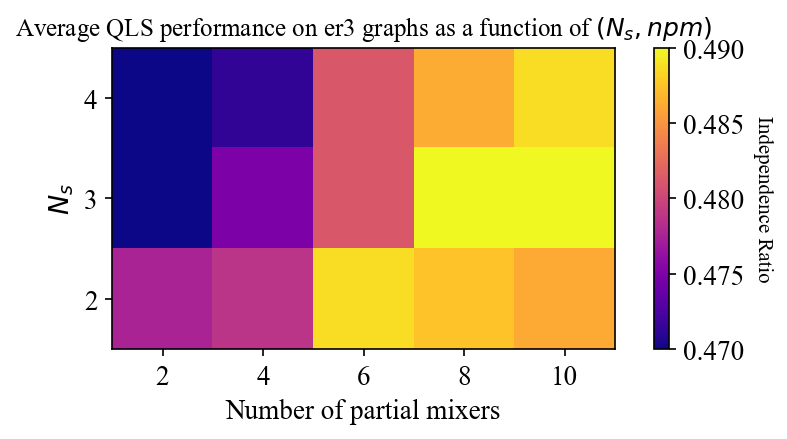

In [365]:
savefn = 'figures/qls_N20.pdf'
performance_heatmap(all_data, N, graph_type, savefn=None, verbose=0)

## N = 60

### 3-regular graphs

In [185]:
all_data = []
N = 60
graph_type = 'd3'
for ns in [2,3,4]:
    for npm in [2, 4, 6, 8, 10]:
        all_data.append((ns, npm, get_pickles(N, graph_type, npm, ns)))

LOADING Quantum N60_d3_NS2_NPM2
LOADING Quantum N60_d3_NS2_NPM4
LOADING Quantum N60_d3_NS2_NPM6
LOADING Quantum N60_d3_NS2_NPM8
LOADING Quantum N60_d3_NS2_NPM10
LOADING Quantum N60_d3_NS3_NPM2
LOADING Quantum N60_d3_NS3_NPM4
LOADING Quantum N60_d3_NS3_NPM6
LOADING Quantum N60_d3_NS3_NPM8
LOADING Quantum N60_d3_NS3_NPM10
LOADING Quantum N60_d3_NS4_NPM2
LOADING Quantum N60_d3_NS4_NPM4
LOADING Quantum N60_d3_NS4_NPM6
LOADING Quantum N60_d3_NS4_NPM8
LOADING Quantum N60_d3_NS4_NPM10


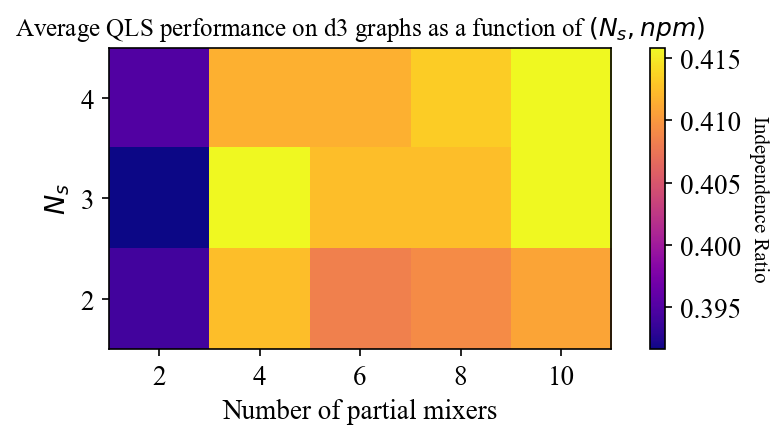

In [186]:
savefn = 'figures/qls_N20.pdf'
performance_heatmap(all_data, N, graph_type, savefn=None, verbose=0)

### Planted-partition graphs

In [187]:
all_data = []
N = 60
graph_type = 'com3_pin10_pout2'
for ns in [2,3,4]:
    for npm in [2, 4, 6, 8]:
        all_data.append((ns, npm, get_pickles(N, graph_type, npm, ns)))

LOADING Quantum N60_com3_pin10_pout2_NS2_NPM2
LOADING Quantum N60_com3_pin10_pout2_NS2_NPM4
LOADING Quantum N60_com3_pin10_pout2_NS2_NPM6
LOADING Quantum N60_com3_pin10_pout2_NS2_NPM8
LOADING Quantum N60_com3_pin10_pout2_NS3_NPM2
LOADING Quantum N60_com3_pin10_pout2_NS3_NPM4
LOADING Quantum N60_com3_pin10_pout2_NS3_NPM6
LOADING Quantum N60_com3_pin10_pout2_NS3_NPM8
LOADING Quantum N60_com3_pin10_pout2_NS4_NPM2
LOADING Quantum N60_com3_pin10_pout2_NS4_NPM4
LOADING Quantum N60_com3_pin10_pout2_NS4_NPM6
LOADING Quantum N60_com3_pin10_pout2_NS4_NPM8


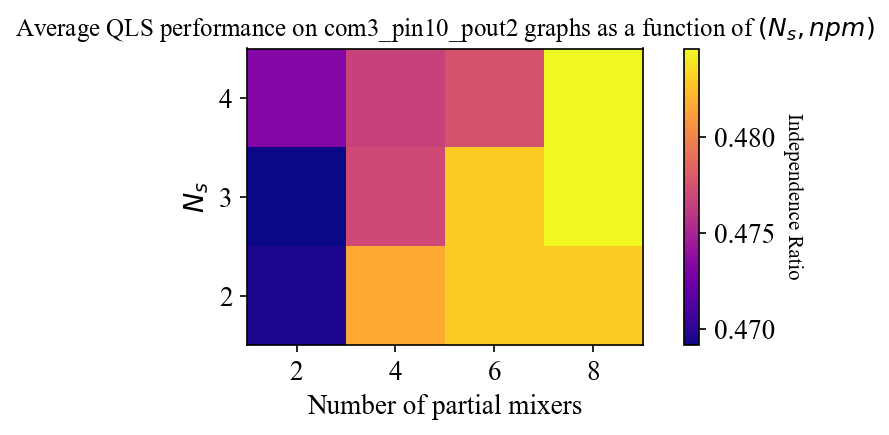

In [188]:
savefn = 'figures/qls_N20.pdf'
performance_heatmap(all_data, N, graph_type, savefn=None, verbose=0)

### Erdos-Renyi graphs

In [366]:
all_data = []
N = 60
graph_type = 'er3'
for ns in [2,3,4]:
    for npm in [2, 4, 6, 8]:
        all_data.append((ns, npm, get_pickles(N, graph_type, npm, ns)))

LOADING Quantum N60_er3_NS2_NPM2
LOADING Quantum N60_er3_NS2_NPM4
LOADING Quantum N60_er3_NS2_NPM6
LOADING Quantum N60_er3_NS2_NPM8
LOADING Quantum N60_er3_NS3_NPM2
LOADING Quantum N60_er3_NS3_NPM4
LOADING Quantum N60_er3_NS3_NPM6
LOADING Quantum N60_er3_NS3_NPM8
LOADING Quantum N60_er3_NS4_NPM2
LOADING Quantum N60_er3_NS4_NPM4
LOADING Quantum N60_er3_NS4_NPM6
LOADING Quantum N60_er3_NS4_NPM8


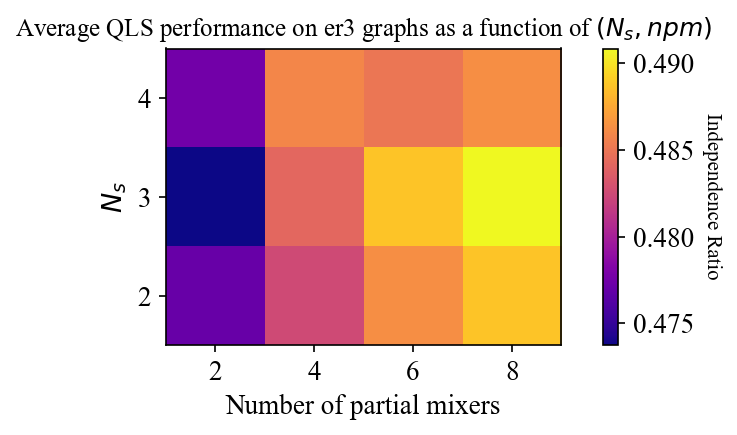

In [367]:
savefn = 'figures/qls_N20.pdf'
performance_heatmap(all_data, N, graph_type, savefn=None, verbose=0)

## N = 100

### 3-regular graphs

In [189]:
all_data = []
N = 100
graph_type = 'd3'
for ns in [2,3,4]:
    for npm in [2, 4, 6, 8, 10]:
        all_data.append((ns, npm, get_pickles(N, graph_type, npm, ns)))

LOADING Quantum N100_d3_NS2_NPM2
LOADING Quantum N100_d3_NS2_NPM4
LOADING Quantum N100_d3_NS2_NPM6
LOADING Quantum N100_d3_NS2_NPM8
LOADING Quantum N100_d3_NS2_NPM10
LOADING Quantum N100_d3_NS3_NPM2
LOADING Quantum N100_d3_NS3_NPM4
LOADING Quantum N100_d3_NS3_NPM6
LOADING Quantum N100_d3_NS3_NPM8
LOADING Quantum N100_d3_NS3_NPM10
LOADING Quantum N100_d3_NS4_NPM2
LOADING Quantum N100_d3_NS4_NPM4
LOADING Quantum N100_d3_NS4_NPM6
LOADING Quantum N100_d3_NS4_NPM8
LOADING Quantum N100_d3_NS4_NPM10


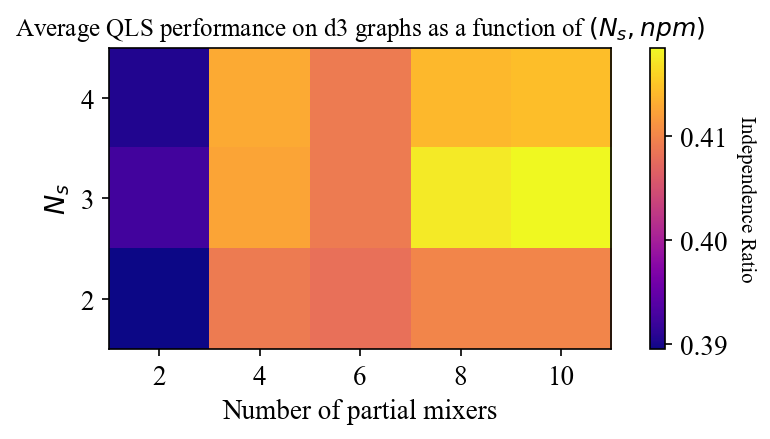

In [190]:
savefn = 'figures/qls_N20.pdf'
performance_heatmap(all_data, N, graph_type, savefn=None, verbose=0)

### Planted-partition graphs

In [191]:
all_data = []
N = 100
graph_type = 'com5_pin10_pout2'
for ns in [2,3,4]:
    for npm in [2, 3, 4, 5, 6]:
        all_data.append((ns, npm, get_pickles(N, graph_type, npm, ns)))

LOADING Quantum N100_com5_pin10_pout2_NS2_NPM2
LOADING Quantum N100_com5_pin10_pout2_NS2_NPM3
LOADING Quantum N100_com5_pin10_pout2_NS2_NPM4
LOADING Quantum N100_com5_pin10_pout2_NS2_NPM5
LOADING Quantum N100_com5_pin10_pout2_NS2_NPM6
LOADING Quantum N100_com5_pin10_pout2_NS3_NPM2
LOADING Quantum N100_com5_pin10_pout2_NS3_NPM3
LOADING Quantum N100_com5_pin10_pout2_NS3_NPM4
LOADING Quantum N100_com5_pin10_pout2_NS3_NPM5
LOADING Quantum N100_com5_pin10_pout2_NS3_NPM6
LOADING Quantum N100_com5_pin10_pout2_NS4_NPM2
LOADING Quantum N100_com5_pin10_pout2_NS4_NPM3
LOADING Quantum N100_com5_pin10_pout2_NS4_NPM4
LOADING Quantum N100_com5_pin10_pout2_NS4_NPM5
LOADING Quantum N100_com5_pin10_pout2_NS4_NPM6


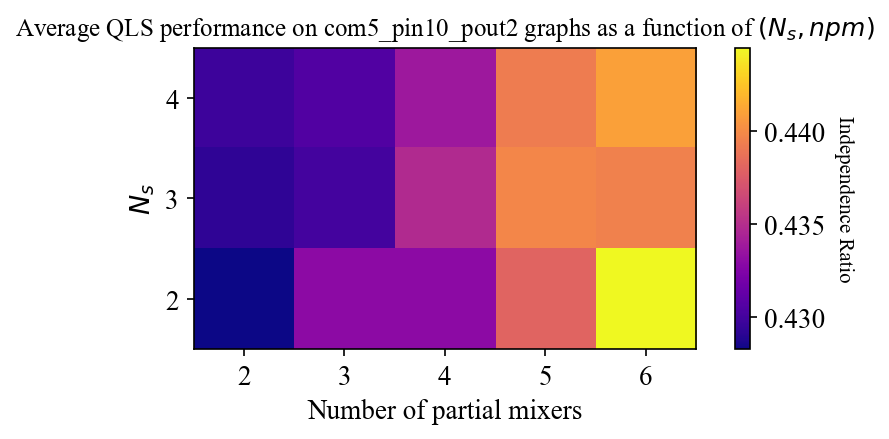

In [192]:
savefn = 'figures/qls_N20.pdf'
performance_heatmap(all_data, N, graph_type, savefn=None, verbose=0)

### Erdos-Renyi graphs

In [368]:
all_data = []
N = 100
graph_type = 'er3'
for ns in [2,3,4]:
    for npm in [2, 3, 4, 5, 6]:
        all_data.append((ns, npm, get_pickles(N, graph_type, npm, ns)))

LOADING Quantum N100_er3_NS2_NPM2
LOADING Quantum N100_er3_NS2_NPM3
LOADING Quantum N100_er3_NS2_NPM4
LOADING Quantum N100_er3_NS2_NPM5
LOADING Quantum N100_er3_NS2_NPM6
LOADING Quantum N100_er3_NS3_NPM2
LOADING Quantum N100_er3_NS3_NPM3
LOADING Quantum N100_er3_NS3_NPM4
LOADING Quantum N100_er3_NS3_NPM5
LOADING Quantum N100_er3_NS3_NPM6
LOADING Quantum N100_er3_NS4_NPM2
LOADING Quantum N100_er3_NS4_NPM3
LOADING Quantum N100_er3_NS4_NPM4
LOADING Quantum N100_er3_NS4_NPM5
LOADING Quantum N100_er3_NS4_NPM6


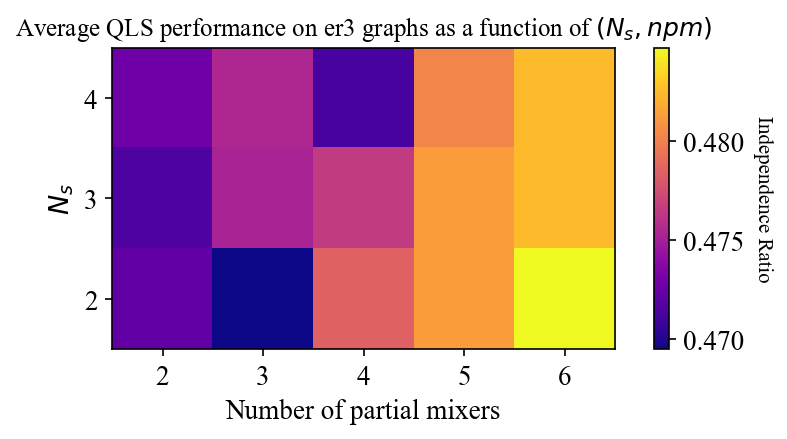

In [369]:
savefn = 'figures/qls_N20.pdf'
performance_heatmap(all_data, N, graph_type, savefn=None, verbose=0)

# Plot $N_s$ x $npm$ x num_iterations heatmap

In [373]:
def runtime_heatmap(all_data, N, graph_type, verbose=0, extra_data=None, savefn=None):
    fig, ax = plt.subplots(dpi=150, figsize=[6,3])
    
    ns_dict = {ns: [] for (ns, npm, data) in all_data}
    
    # For each set of data with N_s = j, NPM = k
    # get the average independence ratio
    for (ns, npm, data) in all_data:
        if verbose:
            print(f'NS{ns} NPM{npm}, {len(data)} graphs')
        all_graph_y_vals = []
        # For each graph within that data set
        for (G, outs, graph_name) in data:
            all_rep_y_vals = []
            # For each repetition on each graph
            for (rep, out) in outs:
                qls_mis, history = out
                all_rep_y_vals.append((qcopt.helper_funcs.hamming_weight(qls_mis) / len(G.nodes), len(history)))
            
            # Once all the reps have been collected, take the best repetition
            if verbose > 1:
                print(ns, npm, graph_name, len(outs))
            all_graph_y_vals.append(sorted(all_rep_y_vals, key=lambda t: t[0])[-1][1])
        
        # Once all the graphs have been collected, average over them
        ns_dict[ns].append(np.mean(all_graph_y_vals))
            
    # After all the data has been averaged, plot the results
    ns_keys = list(set([ns for (ns, _, _) in all_data]))[::-1]
    npm_keys = sorted(list(set([npm for (_, npm, _) in all_data])))
    data_array = np.array([ns_dict[ns] for ns in ns_keys])
    
    im = ax.imshow(data_array, cmap='plasma')
    cbar = ax.figure.colorbar(im, ax=ax, )
    cbar.ax.set_ylabel('Iterations', rotation=-90, va="bottom")
    
    ax.set_xticks(np.arange(len(npm_keys)))
    ax.set_xticklabels(npm_keys)
    ax.set_yticks(np.arange(len(ns_keys)))
    ax.set_yticklabels(ns_keys)
    
    ax.set_ylabel('$N_s$', fontsize=13)
    ax.set_xlabel('Number of partial mixers', fontsize=13)
    ax.set_title(f'Average QLS iterations on {graph_type} graphs as a function of $(N_s, npm)$')
    
    if savefn is not None:
        plt.savefig(savefn)
    
    fig.tight_layout()
    
    plt.show()
    plt.close()

## N = 20

### 3-regular graphs

In [205]:
all_data = []
N = 20
graph_type = 'd3'
for ns in [2,3,4]:
    for npm in [2, 4, 6, 8, 10]:
        all_data.append((ns, npm, get_pickles(N, graph_type, npm, ns)))

LOADING Quantum N20_d3_NS2_NPM2
LOADING Quantum N20_d3_NS2_NPM4
LOADING Quantum N20_d3_NS2_NPM6
LOADING Quantum N20_d3_NS2_NPM8
LOADING Quantum N20_d3_NS2_NPM10
LOADING Quantum N20_d3_NS3_NPM2
LOADING Quantum N20_d3_NS3_NPM4
LOADING Quantum N20_d3_NS3_NPM6
LOADING Quantum N20_d3_NS3_NPM8
LOADING Quantum N20_d3_NS3_NPM10
LOADING Quantum N20_d3_NS4_NPM2
LOADING Quantum N20_d3_NS4_NPM4
LOADING Quantum N20_d3_NS4_NPM6
LOADING Quantum N20_d3_NS4_NPM8
LOADING Quantum N20_d3_NS4_NPM10


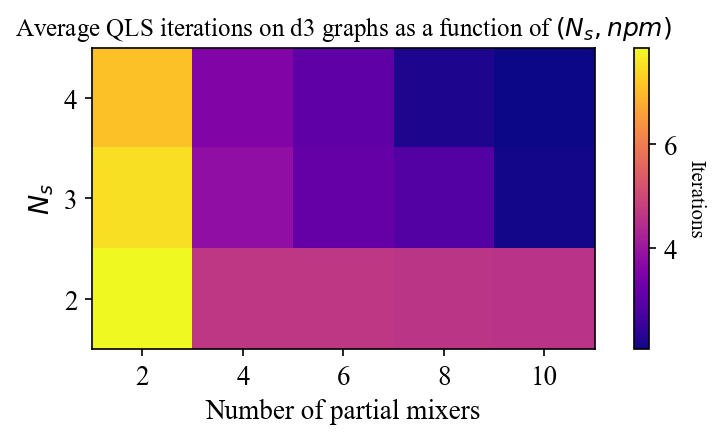

In [206]:
savefn = 'figures/qls_N20.pdf'
runtime_heatmap(all_data, N, graph_type, savefn=None, verbose=0)

### Planted-partition graphs

In [207]:
all_data = []
N = 20
graph_type = 'com1_pin10_pout2'
for ns in [2,3,4]:
    for npm in [2, 4, 6, 8, 10]:
        all_data.append((ns, npm, get_pickles(N, graph_type, npm, ns)))

LOADING Quantum N20_com1_pin10_pout2_NS2_NPM2
LOADING Quantum N20_com1_pin10_pout2_NS2_NPM4
LOADING Quantum N20_com1_pin10_pout2_NS2_NPM6
LOADING Quantum N20_com1_pin10_pout2_NS2_NPM8
LOADING Quantum N20_com1_pin10_pout2_NS2_NPM10
LOADING Quantum N20_com1_pin10_pout2_NS3_NPM2
LOADING Quantum N20_com1_pin10_pout2_NS3_NPM4
LOADING Quantum N20_com1_pin10_pout2_NS3_NPM6
LOADING Quantum N20_com1_pin10_pout2_NS3_NPM8
LOADING Quantum N20_com1_pin10_pout2_NS3_NPM10
LOADING Quantum N20_com1_pin10_pout2_NS4_NPM2
LOADING Quantum N20_com1_pin10_pout2_NS4_NPM4
LOADING Quantum N20_com1_pin10_pout2_NS4_NPM6
LOADING Quantum N20_com1_pin10_pout2_NS4_NPM8
LOADING Quantum N20_com1_pin10_pout2_NS4_NPM10


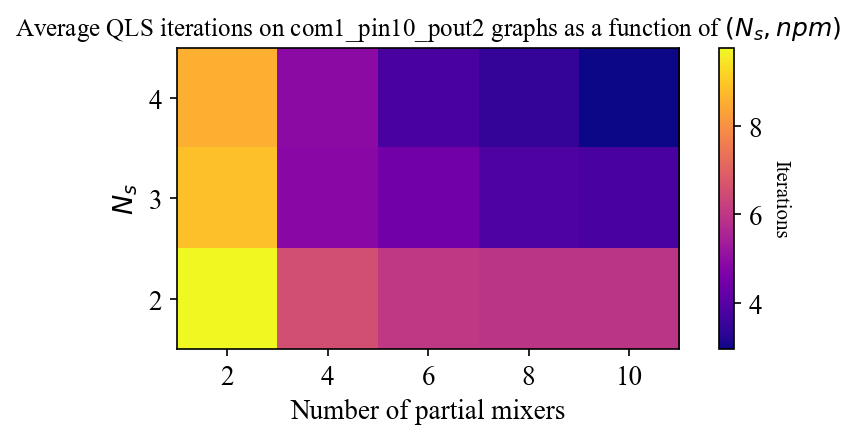

In [208]:
savefn = 'figures/qls_N20.pdf'
runtime_heatmap(all_data, N, graph_type, savefn=None, verbose=0)

### Erdos-Renyi graphs

In [370]:
all_data = []
N = 20
graph_type = 'er3'
for ns in [2,3,4]:
    for npm in [2, 4, 6, 8, 10]:
        all_data.append((ns, npm, get_pickles(N, graph_type, npm, ns)))

LOADING Quantum N20_er3_NS2_NPM2
LOADING Quantum N20_er3_NS2_NPM4
LOADING Quantum N20_er3_NS2_NPM6
LOADING Quantum N20_er3_NS2_NPM8
LOADING Quantum N20_er3_NS2_NPM10
LOADING Quantum N20_er3_NS3_NPM2
LOADING Quantum N20_er3_NS3_NPM4
LOADING Quantum N20_er3_NS3_NPM6
LOADING Quantum N20_er3_NS3_NPM8
LOADING Quantum N20_er3_NS3_NPM10
LOADING Quantum N20_er3_NS4_NPM2
LOADING Quantum N20_er3_NS4_NPM4
LOADING Quantum N20_er3_NS4_NPM6
LOADING Quantum N20_er3_NS4_NPM8
LOADING Quantum N20_er3_NS4_NPM10


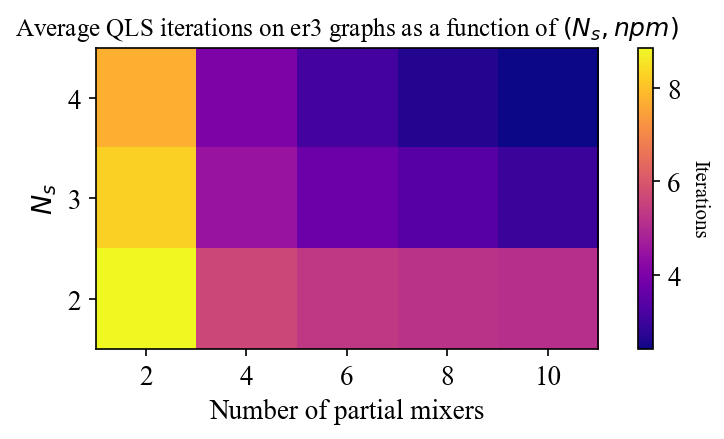

In [374]:
savefn = 'figures/qls_N20.pdf'
runtime_heatmap(all_data, N, graph_type, savefn=None, verbose=0)

## N = 60

### 3-regular graphs

In [209]:
all_data = []
N = 60
graph_type = 'd3'
for ns in [2,3,4]:
    for npm in [2, 4, 6, 8, 10]:
        all_data.append((ns, npm, get_pickles(N, graph_type, npm, ns)))

LOADING Quantum N60_d3_NS2_NPM2
LOADING Quantum N60_d3_NS2_NPM4
LOADING Quantum N60_d3_NS2_NPM6
LOADING Quantum N60_d3_NS2_NPM8
LOADING Quantum N60_d3_NS2_NPM10
LOADING Quantum N60_d3_NS3_NPM2
LOADING Quantum N60_d3_NS3_NPM4
LOADING Quantum N60_d3_NS3_NPM6
LOADING Quantum N60_d3_NS3_NPM8
LOADING Quantum N60_d3_NS3_NPM10
LOADING Quantum N60_d3_NS4_NPM2
LOADING Quantum N60_d3_NS4_NPM4
LOADING Quantum N60_d3_NS4_NPM6
LOADING Quantum N60_d3_NS4_NPM8
LOADING Quantum N60_d3_NS4_NPM10


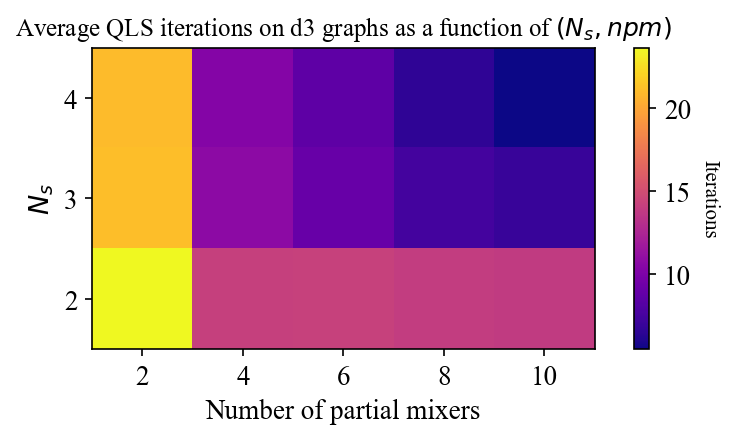

In [210]:
savefn = 'figures/qls_N20.pdf'
runtime_heatmap(all_data, N, graph_type, savefn=None, verbose=0)

### Planted-partition graphs

In [211]:
all_data = []
N = 60
graph_type = 'com3_pin10_pout2'
for ns in [2,3,4]:
    for npm in [2, 4, 6, 8]:
        all_data.append((ns, npm, get_pickles(N, graph_type, npm, ns)))

LOADING Quantum N60_com3_pin10_pout2_NS2_NPM2
LOADING Quantum N60_com3_pin10_pout2_NS2_NPM4
LOADING Quantum N60_com3_pin10_pout2_NS2_NPM6
LOADING Quantum N60_com3_pin10_pout2_NS2_NPM8
LOADING Quantum N60_com3_pin10_pout2_NS3_NPM2
LOADING Quantum N60_com3_pin10_pout2_NS3_NPM4
LOADING Quantum N60_com3_pin10_pout2_NS3_NPM6
LOADING Quantum N60_com3_pin10_pout2_NS3_NPM8
LOADING Quantum N60_com3_pin10_pout2_NS4_NPM2
LOADING Quantum N60_com3_pin10_pout2_NS4_NPM4
LOADING Quantum N60_com3_pin10_pout2_NS4_NPM6
LOADING Quantum N60_com3_pin10_pout2_NS4_NPM8


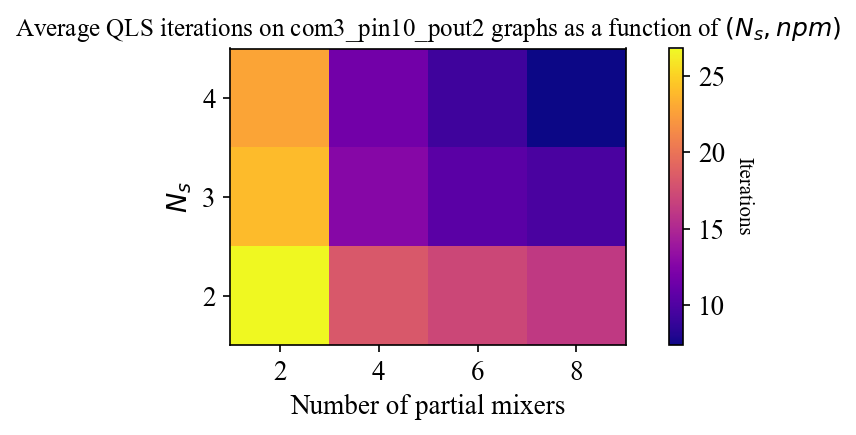

In [212]:
savefn = 'figures/qls_N20.pdf'
runtime_heatmap(all_data, N, graph_type, savefn=None, verbose=0)

### Erdos-Renyi graphs

In [375]:
all_data = []
N = 60
graph_type = 'er3'
for ns in [2,3,4]:
    for npm in [2, 4, 6, 8]:
        all_data.append((ns, npm, get_pickles(N, graph_type, npm, ns)))

LOADING Quantum N60_er3_NS2_NPM2
LOADING Quantum N60_er3_NS2_NPM4
LOADING Quantum N60_er3_NS2_NPM6
LOADING Quantum N60_er3_NS2_NPM8
LOADING Quantum N60_er3_NS3_NPM2
LOADING Quantum N60_er3_NS3_NPM4
LOADING Quantum N60_er3_NS3_NPM6
LOADING Quantum N60_er3_NS3_NPM8
LOADING Quantum N60_er3_NS4_NPM2
LOADING Quantum N60_er3_NS4_NPM4
LOADING Quantum N60_er3_NS4_NPM6
LOADING Quantum N60_er3_NS4_NPM8


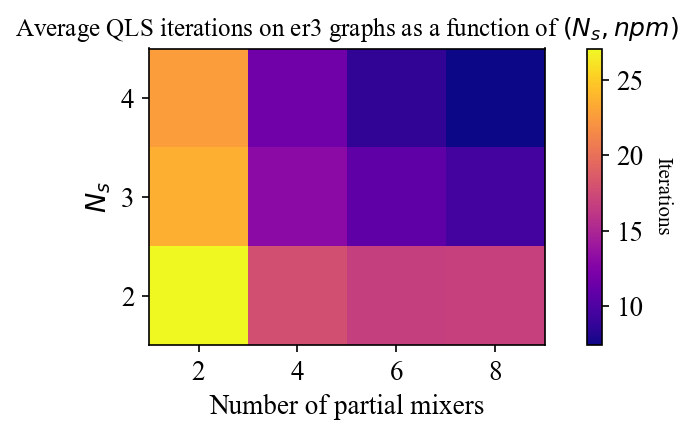

In [376]:
savefn = 'figures/qls_N20.pdf'
runtime_heatmap(all_data, N, graph_type, savefn=None, verbose=0)

## N = 100

### 3-regular graphs

In [213]:
all_data = []
N = 100
graph_type = 'd3'
for ns in [2,3,4]:
    for npm in [2, 4, 6, 8, 10]:
        all_data.append((ns, npm, get_pickles(N, graph_type, npm, ns)))

LOADING Quantum N100_d3_NS2_NPM2
LOADING Quantum N100_d3_NS2_NPM4
LOADING Quantum N100_d3_NS2_NPM6
LOADING Quantum N100_d3_NS2_NPM8
LOADING Quantum N100_d3_NS2_NPM10
LOADING Quantum N100_d3_NS3_NPM2
LOADING Quantum N100_d3_NS3_NPM4
LOADING Quantum N100_d3_NS3_NPM6
LOADING Quantum N100_d3_NS3_NPM8
LOADING Quantum N100_d3_NS3_NPM10
LOADING Quantum N100_d3_NS4_NPM2
LOADING Quantum N100_d3_NS4_NPM4
LOADING Quantum N100_d3_NS4_NPM6
LOADING Quantum N100_d3_NS4_NPM8
LOADING Quantum N100_d3_NS4_NPM10


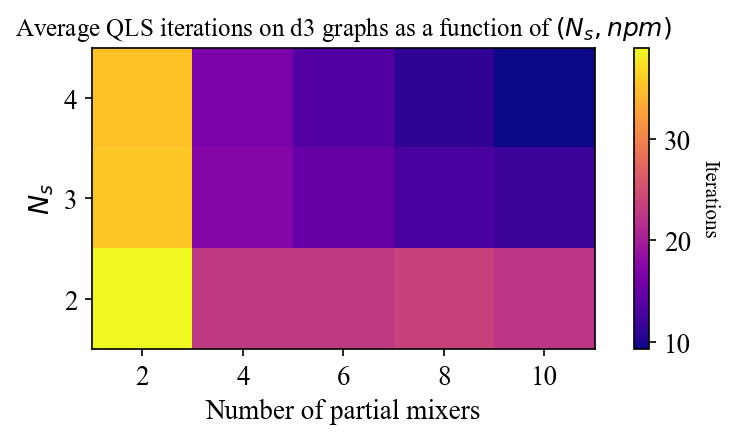

In [214]:
savefn = 'figures/qls_N20.pdf'
runtime_heatmap(all_data, N, graph_type, savefn=None, verbose=0)

### Planted-partition graphs

In [215]:
all_data = []
N = 100
graph_type = 'com5_pin10_pout2'
for ns in [2,3,4]:
    for npm in [2, 3, 4, 5, 6]:
        all_data.append((ns, npm, get_pickles(N, graph_type, npm, ns)))

LOADING Quantum N100_com5_pin10_pout2_NS2_NPM2
LOADING Quantum N100_com5_pin10_pout2_NS2_NPM3
LOADING Quantum N100_com5_pin10_pout2_NS2_NPM4
LOADING Quantum N100_com5_pin10_pout2_NS2_NPM5
LOADING Quantum N100_com5_pin10_pout2_NS2_NPM6
LOADING Quantum N100_com5_pin10_pout2_NS3_NPM2
LOADING Quantum N100_com5_pin10_pout2_NS3_NPM3
LOADING Quantum N100_com5_pin10_pout2_NS3_NPM4
LOADING Quantum N100_com5_pin10_pout2_NS3_NPM5
LOADING Quantum N100_com5_pin10_pout2_NS3_NPM6
LOADING Quantum N100_com5_pin10_pout2_NS4_NPM2
LOADING Quantum N100_com5_pin10_pout2_NS4_NPM3
LOADING Quantum N100_com5_pin10_pout2_NS4_NPM4
LOADING Quantum N100_com5_pin10_pout2_NS4_NPM5
LOADING Quantum N100_com5_pin10_pout2_NS4_NPM6


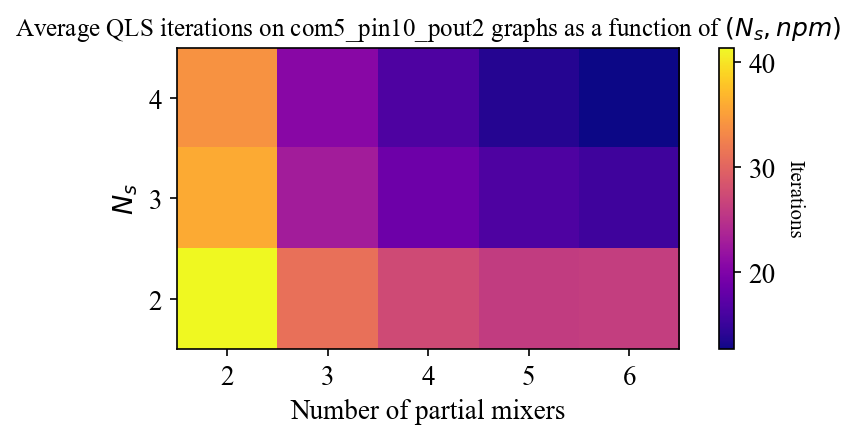

In [216]:
savefn = 'figures/qls_N20.pdf'
runtime_heatmap(all_data, N, graph_type, savefn=None, verbose=0)

### Erdos-Renyi graphs

In [377]:
all_data = []
N = 100
graph_type = 'er3'
for ns in [2,3,4]:
    for npm in [2, 3, 4, 5, 6]:
        all_data.append((ns, npm, get_pickles(N, graph_type, npm, ns)))

LOADING Quantum N100_er3_NS2_NPM2
LOADING Quantum N100_er3_NS2_NPM3
LOADING Quantum N100_er3_NS2_NPM4
LOADING Quantum N100_er3_NS2_NPM5
LOADING Quantum N100_er3_NS2_NPM6
LOADING Quantum N100_er3_NS3_NPM2
LOADING Quantum N100_er3_NS3_NPM3
LOADING Quantum N100_er3_NS3_NPM4
LOADING Quantum N100_er3_NS3_NPM5
LOADING Quantum N100_er3_NS3_NPM6
LOADING Quantum N100_er3_NS4_NPM2
LOADING Quantum N100_er3_NS4_NPM3
LOADING Quantum N100_er3_NS4_NPM4
LOADING Quantum N100_er3_NS4_NPM5
LOADING Quantum N100_er3_NS4_NPM6


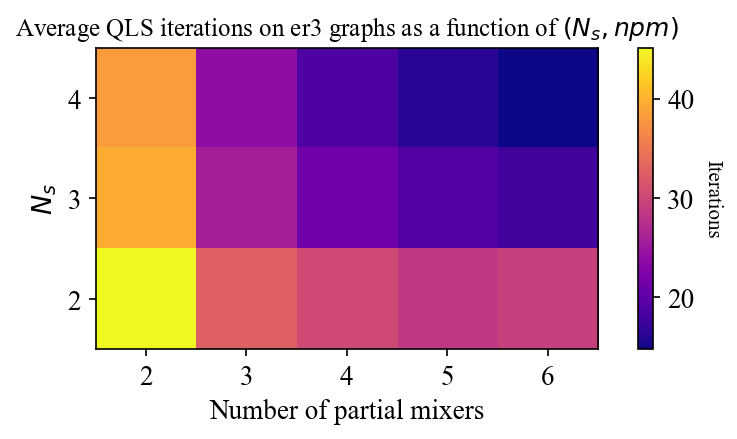

In [378]:
savefn = 'figures/qls_N20.pdf'
runtime_heatmap(all_data, N, graph_type, savefn=None, verbose=0)

# Plot example heatmaps together

In [426]:
def double_heatmap(all_data, N, graph_type, verbose=0, extra_data=None, savefn=None):
    fig, (ax1, ax2) = plt.subplots(nrows=2, dpi=150, sharex=True, figsize=[7,5])
    
    ns_dict = {ns: [] for (ns, _, _) in all_data}
    
    # For each set of data with N_s = j, NPM = k
    # get the average independence ratio
    for (ns, npm, data) in all_data:
        if verbose:
            print(f'NS{ns} NPM{npm}, {len(data)} graphs')
        all_graph_y_vals = []
        # For each graph within that data set
        for (G, outs, graph_name) in data:
            all_rep_y_vals = []
            # For each repetition on each graph
            for (rep, out) in outs:
                qls_mis, history = out
                all_rep_y_vals.append((qcopt.helper_funcs.hamming_weight(qls_mis) / len(G.nodes), len(history)))
            
            # Once all the reps have been collected, take the best repetition
            if verbose > 1:
                print(ns, npm, graph_name, len(outs))
            all_graph_y_vals.append(max(all_rep_y_vals, key=lambda t: t[0]))
        
        # Once all the graphs have been collected, average over them
        ns_dict[ns].append((np.mean([v[0] for v in all_graph_y_vals]), np.mean([v[1] for v in all_graph_y_vals])))
            
    # After all the data has been averaged, plot the results
    ns_keys = list(set([ns for (ns, _, _) in all_data]))[::-1]
    npm_keys = sorted(list(set([npm for (_, npm, _) in all_data])))
    performance_data = np.array([[v[0] for v in ns_dict[ns]] for ns in ns_keys])
    iteration_data = np.array([[v[1] for v in ns_dict[ns]] for ns in ns_keys])
    
    im1 = ax1.imshow(performance_data, cmap='winter')
    cbar1 = ax1.figure.colorbar(im1, ax=ax1, pad=0.01)
    cbar1.ax.set_ylabel('Independence Ratio', rotation=-90, va="bottom", fontsize=13)
    
    im2 = ax2.imshow(iteration_data, cmap='plasma')
    cbar2 = ax2.figure.colorbar(im2, ax=ax2, pad=0.01)
    cbar2.ax.set_ylabel('Iterations', rotation=-90, va="bottom", fontsize=13)
    
    ax1.set_yticks(np.arange(len(ns_keys)))
    ax1.set_yticklabels(ns_keys)
    
    ax2.set_xticks(np.arange(len(npm_keys)))
    ax2.set_xticklabels(npm_keys)
    ax2.set_yticks(np.arange(len(ns_keys)))
    ax2.set_yticklabels(ns_keys)
    
    ax1.set_ylabel('$N_s$', fontsize=13)
    ax2.set_ylabel('$N_s$', fontsize=13)
    ax2.set_xlabel('Number of partial mixers', fontsize=13)
    ax1.set_title(f'Average QLS performance and runtime\n on (3, 20)-Community graphs')
    
    if savefn is not None:
        plt.savefig(savefn)
    
    fig.tight_layout()
    
    plt.show()
    plt.close()

In [406]:
all_data = []
N = 60
graph_type = 'com3_pin10_pout2'
for ns in [2,3,4]:
    for npm in [2, 4, 6, 8]:
        all_data.append((ns, npm, get_pickles(N, graph_type, npm, ns)))

LOADING Quantum N60_com3_pin10_pout2_NS2_NPM2
LOADING Quantum N60_com3_pin10_pout2_NS2_NPM4
LOADING Quantum N60_com3_pin10_pout2_NS2_NPM6
LOADING Quantum N60_com3_pin10_pout2_NS2_NPM8
LOADING Quantum N60_com3_pin10_pout2_NS3_NPM2
LOADING Quantum N60_com3_pin10_pout2_NS3_NPM4
LOADING Quantum N60_com3_pin10_pout2_NS3_NPM6
LOADING Quantum N60_com3_pin10_pout2_NS3_NPM8
LOADING Quantum N60_com3_pin10_pout2_NS4_NPM2
LOADING Quantum N60_com3_pin10_pout2_NS4_NPM4
LOADING Quantum N60_com3_pin10_pout2_NS4_NPM6
LOADING Quantum N60_com3_pin10_pout2_NS4_NPM8


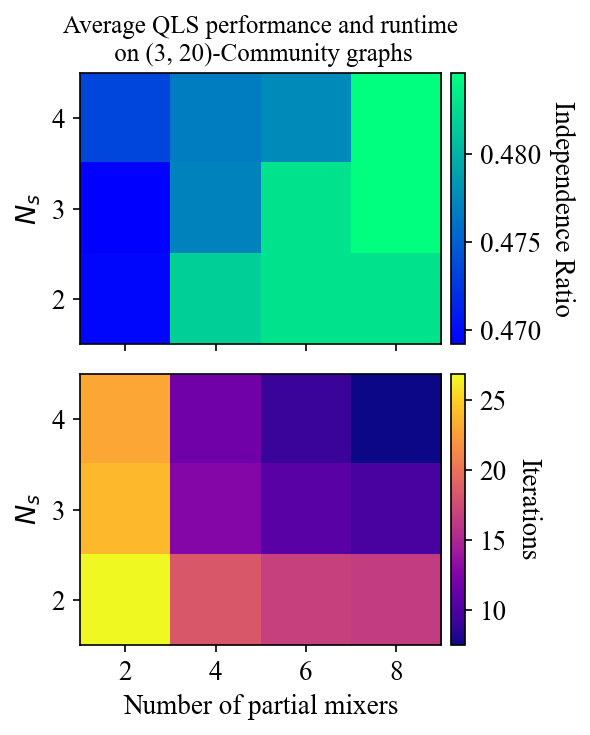

In [427]:
double_heatmap(all_data, N, graph_type, savefn='figures/double_heatmap.png', verbose=0)

# Plot average performance across all algorithms

In [543]:
def bar_chart(all_data, verbose=0, savefn=None):
    fig, axes = plt.subplots(ncols=9, figsize=(16, 3), dpi=200, sharey=True)
    data_keys = ['d3 20', 'pp 20', 'er 20', 'd3 60', 'pp 60', 'er 60', 'd3 100', 'pp 100', 'er 100']
    c = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'grey']
    all_algs = all_data['d3']['20'].keys()
    colors = {alg:c[i] for i, alg in enumerate(all_algs)}
    xlabels = {'d3':'3-regular', 'pp':'Community', 'er':'Erdos-Renyi'}
    for ax, key in zip(axes, data_keys):
        graph_type, graph_size = key.split()
        alg_data = all_data[graph_type][graph_size]
        yvals, labels = [], []
        for alg, indratio in alg_data.items():
            labels.append(alg)
            yvals.append(indratio)
        xvals = range(len(labels))
        ax.bar(xvals, yvals, color=[colors[alg] for alg in labels])
        ax.set_xlabel(f'N = {graph_size}\n{xlabels[graph_type]}', fontsize=13)
    
    # Turn off spines and ticks
    axes[0].spines.right.set_visible(False)
    for i in range(1,len(axes)-1):
        axes[i].spines.right.set_visible(False)
        axes[i].spines.left.set_visible(False)
        axes[i].tick_params(left=False)
    axes[-1].spines.left.set_visible(False)
    axes[-1].tick_params(left=False)
    
    # Set x labels
    for ax in axes:
        ax.spines.top.set_visible(False)
        ax.spines.bottom.set_visible(False)
        ax.tick_params(bottom=False)
        ax.tick_params(labelbottom=False)
    
    custom_lines = [Line2D([0], [0], color=colors[alg], lw=4) for alg in all_algs]

    axes[0].set_ylabel('Independence Ratio', fontsize=13)
    axes[0].legend(custom_lines, all_algs, ncol=len(all_algs), loc=(3.15, 1.02), fontsize=13)
    axes[-1].axhline(y=0, xmin=-9.6, xmax=1, color="black", clip_on=False, lw=1)
    axes[-1].axhline(y=0.55, xmin=-9.6, xmax=1, color="black", clip_on=False, lw=1)
    
    #plt.tight_layout()
    
    if savefn:
        plt.savefig(savefn, bbox_inches="tight")
        
    plt.show()
    plt.close()

## Data processing
For each graph type (3-regular, planted-partition, and Erdos-Renyi) at each size (N=20,60,100) load in the relevant data and do the averaging here
rather than having the plot function do so.

In [461]:
def process_local_search(N, graph_type, mnd, npm, quantum=True):
    # Return a single float that is the average independence ratio for local search at these parameters
    all_graph_y_vals = []
    for (G, outs, graph_name) in get_pickles(N, graph_type, npm, mnd, quantum=quantum):
        all_rep_y_vals = []
        # For each repetition on each graph
        for (rep, out) in outs:
            mis, history = out
            all_rep_y_vals.append(qcopt.helper_funcs.hamming_weight(mis) / len(G.nodes))

        # Once all the reps have been collected, take the best repetition
        all_graph_y_vals.append(max(all_rep_y_vals))

    # Once all the graphs have been collected, average over them
    return np.mean(all_graph_y_vals), np.std(all_graph_y_vals)

# Gather the QLS, CLS, QAOA+, BH data for:
# 3-regular graphs
d3_data = {
    '20':{'QLS $N_s=3, npm=4$': process_local_search(20, 'd3', 3, 4),
          'CLS $N_s=3$': process_local_search(20, 'd3', 3, -1, quantum=False),
          'QAOA+ $p=8$': get_qaoaplus_independence_ratio(20, 'd3', 8),
          'BH':get_BH_independence_ratio(20, 'd3'),
          'RAND': get_random_independence_ratio(20, 'd3')},
    '60':{'QLS $N_s=3, npm=4$': process_local_search(60, 'd3', 3, 4),
          'CLS $N_s=3$': process_local_search(60, 'd3', 3, -1, quantum=False),
          'BH':get_BH_independence_ratio(60, 'd3'),
          'RAND': get_random_independence_ratio(60, 'd3')},
    '100':{'QLS $N_s=3, npm=4$': process_local_search(100, 'd3', 3, 4),
           'CLS $N_s=3$': process_local_search(100, 'd3', 3, -1, quantum=False),
           'BH':get_BH_independence_ratio(100, 'd3'),
           'RAND': get_random_independence_ratio(100, 'd3')},
}

# planted-partition graphs
pp_data = {
    '20':{'QLS $N_s=3, npm=4$': process_local_search(20, 'com1_pin10_pout2', 3, 4),
          'CLS $N_s=3$': process_local_search(20, 'com1_pin10_pout2', 3, -1, quantum=False),
          'QAOA+ $p=8$': get_qaoaplus_independence_ratio(20, 'com1_pin10_pout2', 8),
          'BH':get_BH_independence_ratio(20, 'com1_pin10_pout2'),
          'RAND': get_random_independence_ratio(20, 'com1_pin10_pout2')},
    '60':{'QLS $N_s=3, npm=4$': process_local_search(60, 'com3_pin10_pout2', 3, 4),
          'CLS $N_s=3$': process_local_search(60, 'com3_pin10_pout2', 3, -1, quantum=False),
          'BH':get_BH_independence_ratio(60, 'com3_pin10_pout2'),
          'RAND': get_random_independence_ratio(60, 'com3_pin10_pout2')},
    '100':{'QLS $N_s=3, npm=4$': process_local_search(100, 'com5_pin10_pout2', 3, 4),
           'CLS $N_s=3$': process_local_search(100, 'com5_pin10_pout2', 3, -1, quantum=False),
           'BH':get_BH_independence_ratio(100, 'com5_pin10_pout2'),
           'RAND': get_random_independence_ratio(100, 'com5_pin10_pout2')},
}

# Erdos-Renyi graphs
er_data = {
    '20':{'QLS $N_s=3, npm=4$': process_local_search(20, 'er3', 3, 4),
          'CLS $N_s=3$': process_local_search(20, 'er3', 3, -1, quantum=False),
          'QAOA+ $p=8$': get_qaoaplus_independence_ratio(20, 'er3', 8),
          'BH':get_BH_independence_ratio(20, 'er3'),
          'RAND': get_random_independence_ratio(20, 'er3')},
    '60':{'QLS $N_s=3, npm=4$': process_local_search(60, 'er3', 3, 4),
          'CLS $N_s=3$': process_local_search(60, 'er3', 3, -1, quantum=False),
          'BH':get_BH_independence_ratio(60, 'er3'),
          'RAND': get_random_independence_ratio(60, 'er3')},
    '100':{'QLS $N_s=3, npm=4$': process_local_search(100, 'er3', 3, 4),
           'CLS $N_s=3$': process_local_search(100, 'er3', 3, -1, quantum=False),
           'BH':get_BH_independence_ratio(100, 'er3'),
           'RAND': get_random_independence_ratio(100, 'er3')},
}

LOADING Quantum N20_d3_NS3_NPM4
LOADING Classical N20_d3_NS3
LOADING Quantum N60_d3_NS3_NPM4
LOADING Classical N60_d3_NS3
LOADING Quantum N100_d3_NS3_NPM4
LOADING Classical N100_d3_NS3
LOADING Quantum N20_com1_pin10_pout2_NS3_NPM4
LOADING Classical N20_com1_pin10_pout2_NS3
LOADING Quantum N60_com3_pin10_pout2_NS3_NPM4
LOADING Classical N60_com3_pin10_pout2_NS3
LOADING Quantum N100_com5_pin10_pout2_NS3_NPM4
LOADING Classical N100_com5_pin10_pout2_NS3
LOADING Quantum N20_er3_NS3_NPM4
LOADING Classical N20_er3_NS3
LOADING Quantum N60_er3_NS3_NPM4
LOADING Classical N60_er3_NS3
LOADING Quantum N100_er3_NS3_NPM4
LOADING Classical N100_er3_NS3


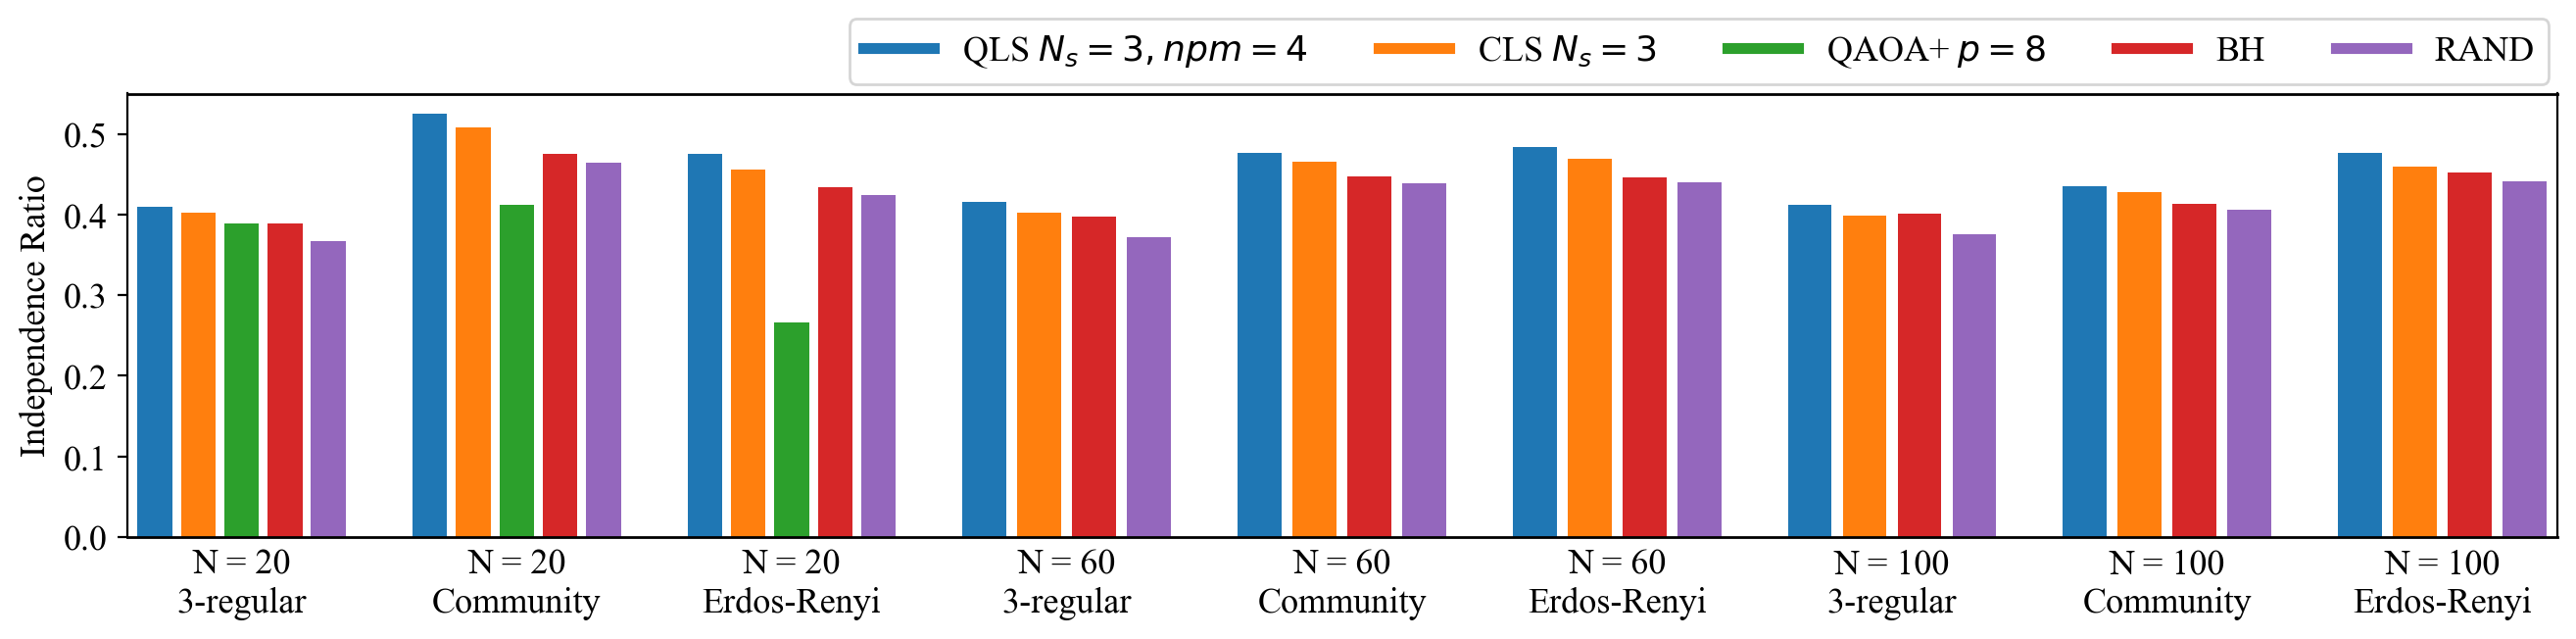

In [545]:
bar_chart({'d3':d3_data, 'pp':pp_data, 'er':er_data}, verbose=0, savefn='figures/all_bars.png')

# Graph analysis

## Node degree histogram

In [181]:
def node_degree_histogram(node_sizes, savefn=None):
    label_dict = {'d3':'3-regular', 'co':'Community', 'er':'Erdos-Renyi'}
    
    fig = plt.figure(figsize=(8, 8), dpi=200)
    subfigs = fig.subfigures(nrows=3)
    subaxes = []
    
    for subfig, N in zip(subfigs, node_sizes):
        (ax1, ax2) = subfig.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [1, 4]})
        subaxes.append((ax1,ax2))

        subfig.subplots_adjust(hspace=-0.1)  # adjust space between axes

        all_data = []
        for graph_type in ['d3', f'com{int(N/20)}_pin10_pout2', 'er3']:
            all_graph_fns = glob.glob(f'benchmark_graphs/N{N}_{graph_type}_graphs/G*.txt')
            node_degrees = []
            for graph_fn in all_graph_fns:
                G = qcopt.graph_funcs.graph_from_file(graph_fn)
                node_degrees.extend([tup[1] for tup in list(G.degree)])
            all_data.append((graph_type, node_degrees))

        ax1.hist([t[1] for t in all_data], bins=np.arange(0.5, 9.5), label=[label_dict[t[0][:2]] for t in all_data],
                align='mid', density=True, rwidth=0.5)
        ax2.hist([t[1] for t in all_data], bins=np.arange(0.5, 9.5), label=[label_dict[t[0][:2]] for t in all_data],
                align='mid', density=True, rwidth=0.5)
    

        # zoom-in / limit the view to different portions of the data
        ax1.set_ylim(.94, 1.01)  # outliers only
        ax2.set_ylim(0, .4)  # most of the data

        # hide the spines between ax and ax2
        ax1.spines.bottom.set_visible(False)
        ax2.spines.top.set_visible(False)
        ax1.tick_params(labeltop=False)  # don't put tick labels at the top
        ax1.tick_params(bottom=False)

        #ax2.set_xticks(np.arange(1,9))
        ax2.set_yticks(np.arange(0.0, 0.4, 0.12))
        ax1.set_yticks([0.96, 1.0])

        d = .2  # proportion of vertical to horizontal extent of the slanted line
        kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                      linestyle="none", color='k', mec='k', mew=1, clip_on=False)
        ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
        ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
        ax1.set_title(f'N = {N} nodes', y=1.0, pad=-16, fontsize=16)
    
    subaxes[2][1].xaxis.tick_bottom()
    subaxes[0][1].legend(loc=[0.67,0.8], fontsize=15)
    subaxes[2][1].set_xlabel('Node degree')
    for subax in subaxes:
        subax[1].set_ylabel('Proportion')

    plt.tight_layout()
    
    if savefn:
        plt.savefig(savefn, bbox_inches="tight")
    
    plt.show()
    plt.close()

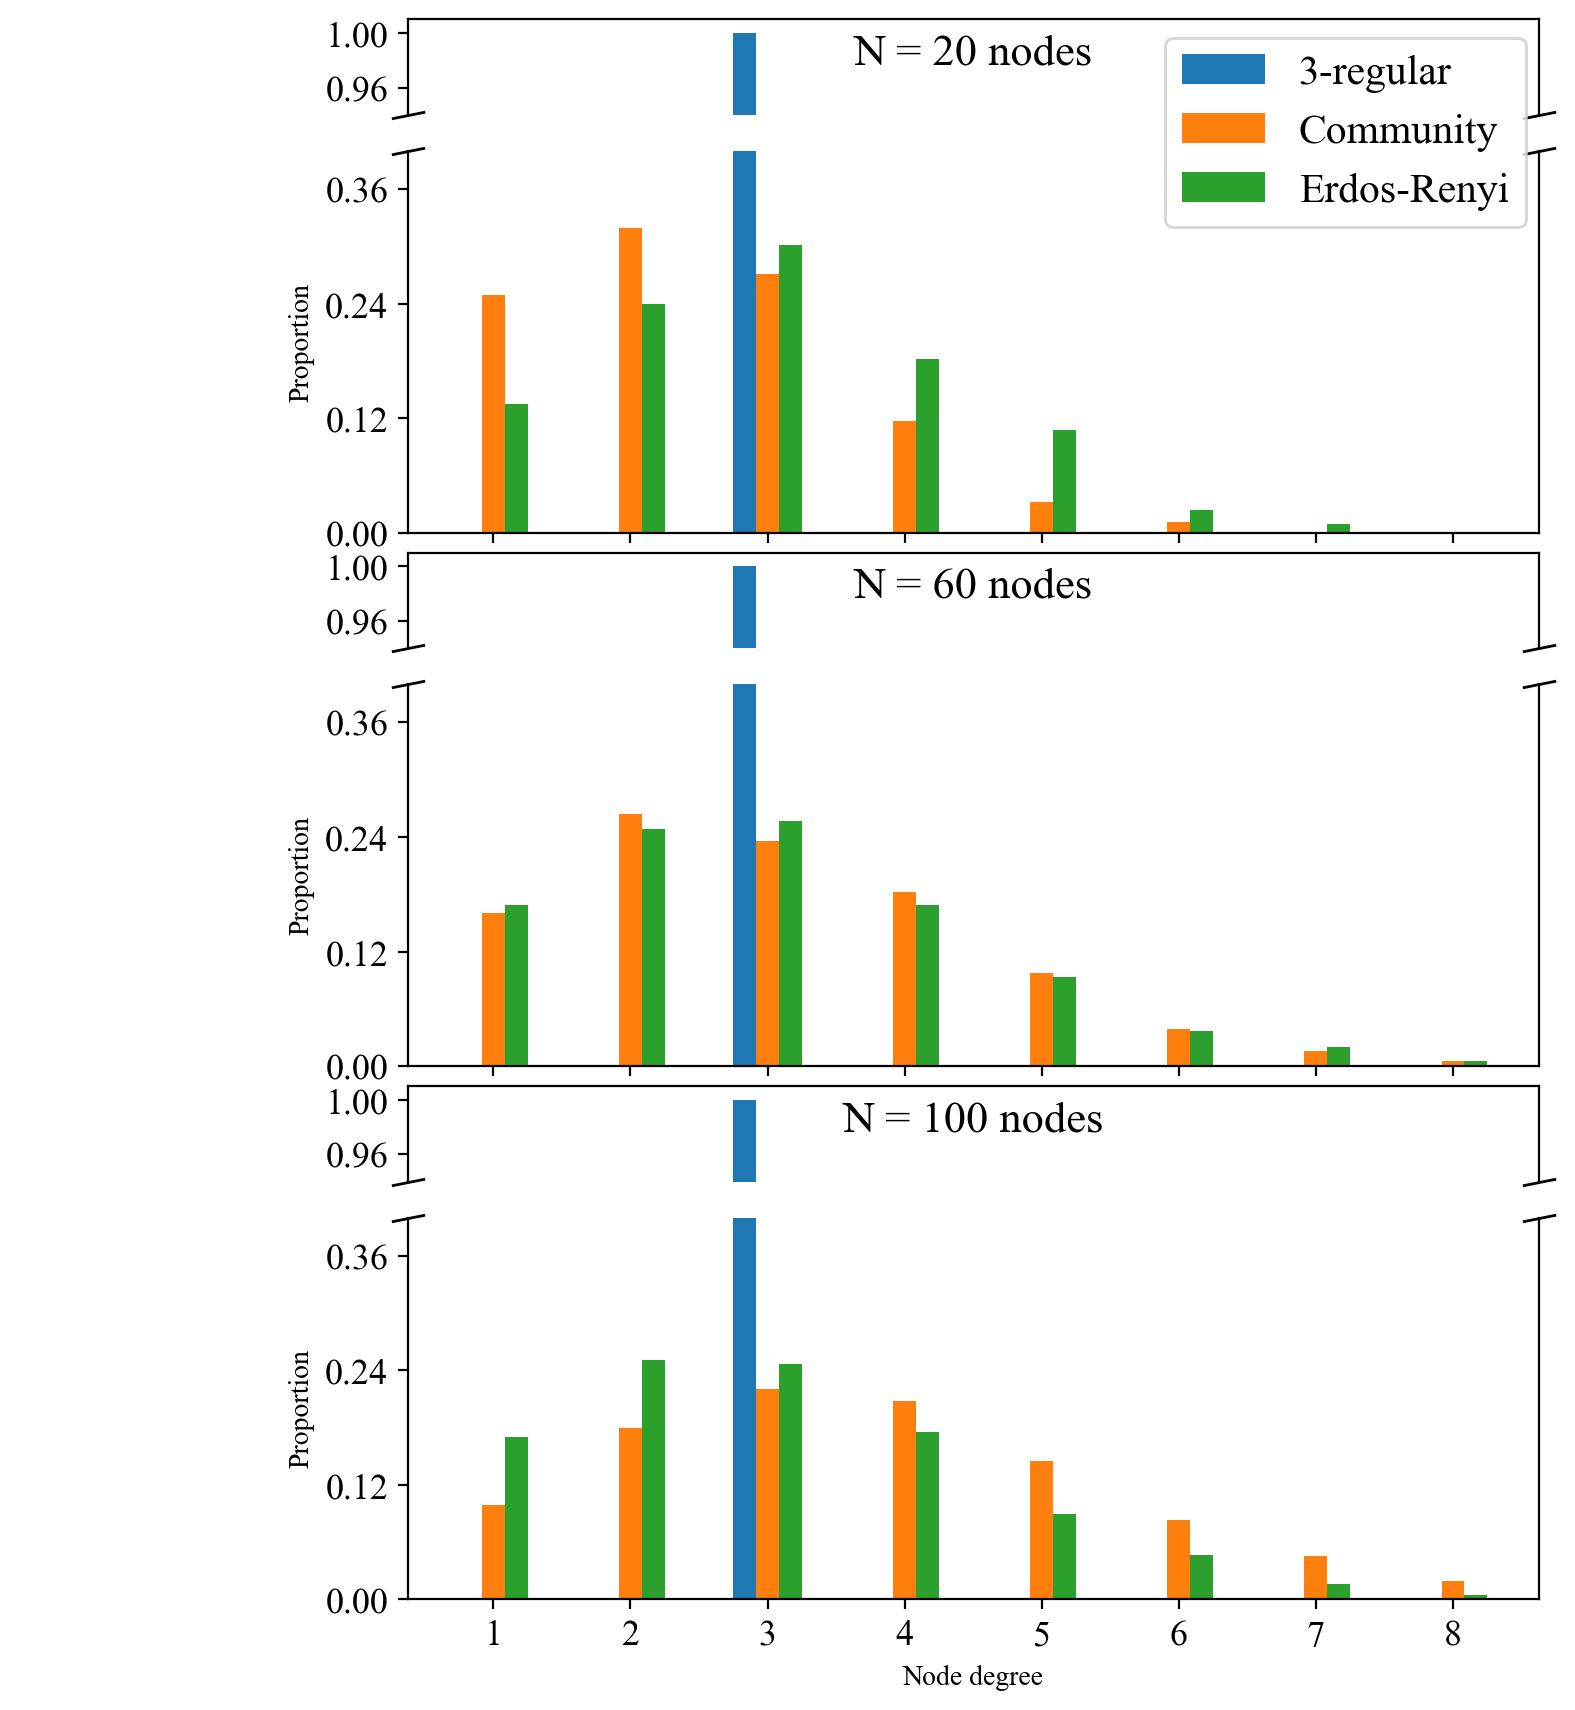

In [182]:
node_degree_histogram([20, 60, 100], savefn='figures/graph_stats.png')

## Graph examples

In [193]:
def erdosrenyi(average_degree, n):
    m = int(average_degree * n / 2)
    
    all_possible_edges = []
    for i in range(n-1):
        for j in range(i+1, n):
            all_possible_edges.append((i,j))
    
    while True:
        np.random.shuffle(all_possible_edges)
        G = nx.Graph()
        G.add_edges_from(all_possible_edges[:m])

        if nx.is_connected(G) and len(G.nodes) == n:
            return G
    
def communitygraph(numComm, commSize, pin, pout):
    while True:
        G = nx.generators.planted_partition_graph(l=numComm, k=commSize, p_in=pin, p_out=pout)
        if nx.is_connected(G):
            return G

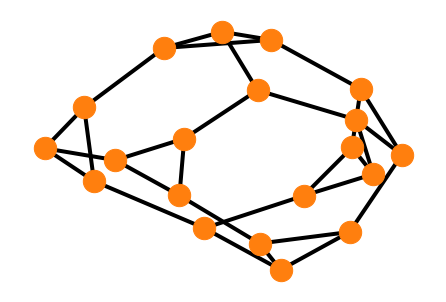

In [333]:
width = 4
size = 500
n = np.random.choice(range(1,41))
#dregular = nx.random_regular_graph(3, n)
dregular = qcopt.graph_funcs.graph_from_file(f"benchmark_graphs/N20_d3_graphs/G{n}.txt")
nx.draw_spring(dregular, with_labels=False, node_color='tab:orange', node_size=size, width=width)
plt.savefig("figures/example_regular_graph.pdf")

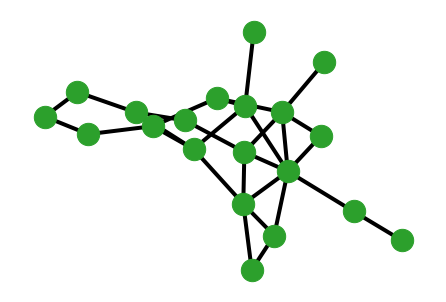

In [338]:
#erdos = erdosrenyi(3, n)
n = np.random.choice(range(1,41))
erdos = qcopt.graph_funcs.graph_from_file(f"benchmark_graphs/N20_er3_graphs/G{n}.txt")
nx.draw_spring(erdos, with_labels=False, node_color='tab:green', node_size=size, width=width)
plt.savefig("figures/example_erdosrenyi_graph.pdf")

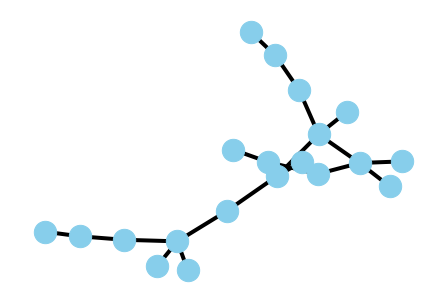

In [340]:
#community = communitygraph(2, 6, 0.1, 0.02)
n = np.random.choice(range(1,41))
community = qcopt.graph_funcs.graph_from_file(f"benchmark_graphs/N20_com1_pin10_pout2_graphs/G{n}.txt")
nx.draw_spring(community, with_labels=False, node_color='skyblue', node_size=size, width=width)
plt.savefig("figures/example_community_graph.pdf")

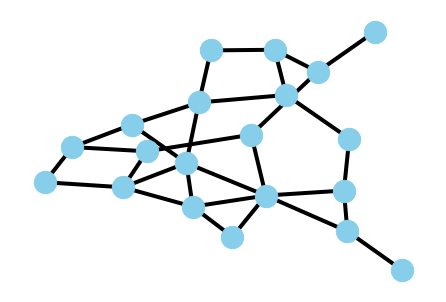

In [312]:
n=5

G = qcopt.graph_funcs.graph_from_file(f"benchmark_graphs/N20_er3_graphs/G{n}.txt")
nx.draw_spring(G, with_labels=False, node_color='skyblue', node_size=size, width=width)